# 필수 라이브러리 설치

In [1]:
import gym
from gym import spaces
from gym.utils import seeding

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from rl.callbacks import ModelIntervalCheckpoint, Callback, TestLogger
from rl.core import Processor

import itertools
import logging
from six import StringIO
import sys

import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import random

# 2048 게임 구현

In [2]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

class IllegalMove(Exception):
    pass

class Game2048Env(gym.Env):
    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self):
        # 게임 환경 초기화
        self.size = 4  # 보드 크기 (4x4)
        self.w = self.size
        self.h = self.size
        squares = self.size * self.size

        # 게임 점수 초기화
        self.score = 0

        # Gym 인터페이스를 위한 멤버 변수 초기화
        self.action_space = spaces.Discrete(4)  # 4가지 이동 방향 (위, 오른쪽, 아래, 왼쪽)
        self.observation_space = spaces.Box(0, 2**squares, (self.w * self.h, ), dtype=int)  # 보드 상태를 나타내는 공간
        self.reward_range = (0., float(2**squares))  # 가능한 보상 범위 설정

        # Gym 환경의 랜덤 시드 초기화
        self.seed()

        # 새 게임을 위해 보드 초기화
        self.reset()

    def seed(self, seed=None):
        # Gym 환경의 랜덤 시드 설정
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    # Gym 인터페이스 구현:
    def step(self, action):
        # 게임의 한 단계를 수행 (이동 및 새 타일 추가)
        logging.debug("Action {}".format(action))
        score = 0
        done = None
        try:
            score = float(self.move(action)) # 주어진 방향으로 이동
            self.score += score
            assert score <= 2**(self.w*self.h)
            self.add_tile() # 새 타일 추가
            done = self.isend() # 게임 종료 여부 확인
            reward = float(score)
        except IllegalMove as e:
            logging.debug("Illegal move")
            done = False
            reward = 0. # 이동하지 않은 action에 대한 보상은 0, 음수 보상을 설정할 수도 있다.

        observation = self.Matrix
        
        # 게임의 각 단계/이동을 실행한 후 호출자에게 추가 정보를 저장
        # 테스트 및 훈련 중인 에이전트를 모니터링하기 위한 콜백 함수로 사용
        info = {"max_tile": self.highest()}        
        
        # 관측값 (보드 상태), 보상, 종료 여부, 정보 반환
        return observation, reward, done, info

    def reset(self):
        # 게임 보드 초기화 및 2개의 타일 추가
        self.Matrix = np.zeros((self.h, self.w), int)
        self.score = 0

        logging.debug("Adding tiles")
        self.add_tile()
        self.add_tile()

        return self.Matrix

    def render(self, mode='human'):
        # 게임 보드 상태를 출력하여 렌더링
        outfile = StringIO() if mode == 'ansi' else sys.stdout
        s = 'Score: {}\n'.format(self.score)
        s += 'Highest: {}\n'.format(self.highest())
        npa = np.array(self.Matrix)
        grid = npa.reshape((self.size, self.size))
        s += "{}\n".format(grid)
        outfile.write(s)
        return outfile

    # 2048 게임 로직 구현:
    def add_tile(self):
        # 확률에 따라 값이 2 또는 4인 새 타일 추가
        val = 0
        if self.np_random.random() > 0.8:
            val = 4
        else:
            val = 2
        empties = self.empties() # 빈 칸 목록 가져오기
        assert empties
        empty_idx = self.np_random.choice(len(empties))
        empty = empties[empty_idx]
        logging.debug("Adding %s at %s", val, (empty[0], empty[1]))
        self.set(empty[0], empty[1], val)

    def get(self, x, y):
        # 지정된 위치의 타일 값 가져오기
        return self.Matrix[x, y]

    def set(self, x, y, val):
        # 지정된 위치의 타일 값 설정
        self.Matrix[x, y] = val

    def empties(self):
        # 빈 칸의 위치 목록 반환
        empties = list()
        for y in range(self.h):
            for x in range(self.w):
                if self.get(x, y) == 0:
                    empties.append((x, y))
        return empties

    def highest(self):
        # 보드에서 가장 높은 타일 값 반환
        highest = 0
        for y in range(self.h):
            for x in range(self.w):
                highest = max(highest, self.get(x, y))
        return highest

    def move(self, direction, trial=False):
        # 지정된 방향으로 이동 수행
        # 0=위, 1=오른쪽, 2=아래, 3=왼쪽
        if not trial:
            if direction == 0:
                logging.debug("Up")
            elif direction == 1:
                logging.debug("Right")
            elif direction == 2:
                logging.debug("Down")
            elif direction == 3:
                logging.debug("Left")

        changed = False
        move_score = 0
        dir_div_two = int(direction / 2)
        dir_mod_two = int(direction % 2)
        shift_direction = dir_mod_two ^ dir_div_two # 이동 방향 설정

        # 행/열 범위 구성
        rx = list(range(self.w))
        ry = list(range(self.h))

        if dir_mod_two == 0:
            # 위 또는 아래로 이동
            for y in range(self.h):
                old = [self.get(x, y) for x in rx]
                (new, ms) = self.shift(old, shift_direction)
                move_score += ms
                if old != new:
                    changed = True
                    if not trial:
                        for x in rx:
                            self.set(x, y, new[x])
        else:
            # 왼쪽 또는 오른쪽으로 이동
            for x in range(self.w):
                old = [self.get(x, y) for y in ry]
                (new, ms) = self.shift(old, shift_direction)
                move_score += ms
                if old != new:
                    changed = True
                    if not trial:
                        for y in ry:
                            self.set(x, y, new[y])
        if changed != True:
            raise IllegalMove

        return move_score

    def combine(self, shifted_row):
        # 한쪽으로 이동할 때 동일한 타일 결합 (왼쪽으로 이동)
        move_score = 0
        combined_row = [0] * self.size
        skip = False
        output_index = 0
        for p in pairwise(shifted_row):
            if skip:
                skip = False
                continue
            combined_row[output_index] = p[0]
            if p[0] == p[1]:
                combined_row[output_index] += p[1]
                move_score += p[0] + p[1]
                # 다음 항목을 리스트에서 건너뜁니다.
                skip = True
            output_index += 1
        if shifted_row and not skip:
            combined_row[output_index] = shifted_row[-1]

        return (combined_row, move_score)

    def shift(self, row, direction):
        # 한 행을 왼쪽 또는 오른쪽으로 이동 및 결합
        length = len(row)
        assert length == self.size
        assert direction == 0 or direction == 1

        # 모든 0이 아닌 숫자를 앞으로 이동
        shifted_row = [i for i in row if i != 0]

        # 오른쪽으로 이동하는 경우 리스트를 뒤집습니다.
        if direction:
            shifted_row.reverse()

        (combined_row, move_score) = self.combine(shifted_row)

        # 오른쪽으로 이동 시 리스트 뒤집기
        if direction:
            combined_row.reverse()

        assert len(combined_row) == self.size
        return (combined_row, move_score)

    def isend(self):
        # 게임 종료 여부 확인 (2048 타일 또는 합법적인 이동이 없는 경우)
        if self.highest() == 2048:
            return True

        for direction in range(4):
            try:
                self.move(direction, trial=True)
                # 어떤 이동도 할 수 있으면 종료되지 않음
                return False
            except IllegalMove:
                pass
        return True

    def get_board(self):
        # 전체 보드 매트릭스를 반환
        return self.Matrix

    def set_board(self, new_board):
        # 전체 보드 매트릭스를 설정
        self.Matrix = new_board

# 신경망 훈련 모니터링

In [3]:
# 신경망의 훈련 결과 실시간 업데이트 차트 출력
# CSV 파일에 결과 저장
class Train2048(Callback):
    def __init__(self):
        self.observations = {}
        self.rewards = {}
        self.max_tile = {}
        self.step = 0

        self.episodes = []

        self.max_tiles = []
        self.episodes_rewards = []
        self.fig_max_tile = plt.figure()
        self.ax1 = self.fig_max_tile.add_subplot(1,1,1)
        self.fig_reward = plt.figure()
        self.ax2 = self.fig_reward.add_subplot(1,1,1)

        self.max_tiles_means = 0
        self.episodes_rewards_means = 0
        self.fig_max_tile_mean = plt.figure()
        self.ax3 = self.fig_max_tile_mean.add_subplot(1,1,1)
        self.fig_reward_mean = plt.figure()
        self.ax4 = self.fig_reward_mean.add_subplot(1,1,1)

        self.nb_episodes_for_mean = 50 # 평균을 계산할 에피소드 수
        self.episode_counter = 0 # 에피소드 카운터

        self.csv_file_path = csv_file_path
        self.csv_file = None  # 파일 객체 초기화
        self.csv_writer = None  # CSV 작성기 초기화

        self.open_csv()

    def open_csv(self):
        if os.path.exists(self.csv_file_path):
            self.csv_file = open(self.csv_file_path, "a")
            self.csv_writer = csv.writer(self.csv_file, delimiter=',')
        else:
            self.csv_file = open(self.csv_file_path, "w")
            self.csv_writer = csv.writer(self.csv_file, delimiter=',')
            headers = ['episode', 'episode_steps', 'episode_reward', 'max_tile']
            self.csv_writer.writerow(headers)  # CSV 파일 헤더 작성

    def close_csv(self):
        if self.csv_file:
            self.csv_file.close()

    def __del__(self):
        self.close_csv()

    # 에피소드 시작 시 환경 변수를 재설정
    def on_episode_begin(self, episode, logs):
        self.observations[episode] = []
        self.rewards[episode] = []
        self.max_tile[episode] = 0

    # 에피소드 종료 시점의 훈련 통계를 계산하고 차트 출력
    # 훈련 데이터를 CSV 파일에 저장
    def on_episode_end(self, episode, logs):
        self.episode_counter += 1
        self.episodes = np.append(self.episodes, episode + 1)
        self.max_tiles = np.append(self.max_tiles, self.max_tile[episode])
        self.episodes_rewards = np.append(self.episodes_rewards, np.sum(self.rewards[episode]))

        nb_step_digits = str(int(np.ceil(np.log10(self.params['nb_steps']))) + 1) # used to monitor how many training steps are left to end the training phase
        template = '{step: ' + nb_step_digits + 'd}/{nb_steps} - episode: {episode}, episode steps: {episode_steps}, episode reward: {episode_reward}, max tile: {max_tile}'
        variables = {
            'step': self.step,
            'nb_steps': self.params['nb_steps'],
            'episode': episode + 1,
            'episode_steps': len(self.observations[episode]),
            'episode_reward': self.episodes_rewards[-1],
            'max_tile': self.max_tiles[-1]
        }
        print(template.format(**variables))

        # CSV 파일에 데이터 저장
        self.csv_writer.writerow((episode + 1, len(self.observations[episode]), self.episodes_rewards[-1], self.max_tiles[-1]))
        self.csv_file.flush()  # 파일 버퍼를 디스크 쓰기

        if self.episode_counter % self.nb_episodes_for_mean == 0 :
            # 최근 에피소드에 대한 평균 타일 값 출력 계산
            self.max_tiles_means = np.append(self.max_tiles_means,np.mean(self.max_tiles[-self.nb_episodes_for_mean:]))
            self.fig_max_tile_mean.clear()
            plt.figure(self.fig_max_tile_mean.number)
            plt.plot(np.arange(0,self.episode_counter+self.nb_episodes_for_mean,self.nb_episodes_for_mean), self.max_tiles_means)
            plt.title("max tiles means (over last {} episodes)".format(self.nb_episodes_for_mean))
            plt.xlabel("episode")
            plt.ylabel("max tiles mean")
            plt.show()
            
            # 최근 에피소드에 대한 평균 보상 출력 계산
            self.episodes_rewards_means = np.append(self.episodes_rewards_means,np.mean(self.episodes_rewards[-self.nb_episodes_for_mean:]))
            self.fig_reward_mean.clear()
            plt.figure(self.fig_reward_mean.number)            
            plt.plot(np.arange(0,self.episode_counter+self.nb_episodes_for_mean,self.nb_episodes_for_mean), self.episodes_rewards_means)
            plt.title("rewards means (over last {} episodes)".format(self.nb_episodes_for_mean))
            plt.xlabel("episode")
            plt.ylabel("rewards mean")
            plt.show()
        
            # 개별 에피소드의 최대 타일 값 출력
            self.fig_max_tile.clear()
            plt.figure(self.fig_max_tile.number)
            plt.scatter(self.episodes, self.max_tiles, s=1)
            plt.title("max tile (per episode)")
            plt.xlabel("episode")
            plt.ylabel("max tile")
            plt.show()

            # 개별 에피소드의 보상 출력
            self.fig_reward.clear()
            plt.figure(self.fig_reward.number)
            plt.scatter(self.episodes, self.episodes_rewards, s=1)
            plt.title("reward (per episode)")
            plt.xlabel("episode")
            plt.ylabel("reward")
            plt.show()

        # 자원 해제
        del self.observations[episode]
        del self.rewards[episode]
        del self.max_tile[episode]

    # 각 스텝 종료 후 에피소드 통계 업데이트
    def on_step_end(self, step, logs):
        episode = logs['episode']
        self.observations[episode].append(logs['observation'])
        self.rewards[episode].append(logs['reward'])
        self.max_tile[episode] = logs['info']['max_tile']
        self.step += 1
    
    # 훈련 시작 시 차트 표시
    def on_train_begin(self, logs):
        plt.show()
        
    # 훈련 종료 시 차트 표시
    def on_train_end(self, logs=None):
        if len(self.max_tiles_means) > 0:  # 빈 리스트가 아닌 경우에만 플롯
            plt.figure(self.fig_max_tile_mean.number)
            plt.plot(np.arange(1, len(self.max_tiles_means) + 1), self.max_tiles_means)
            plt.title("max tiles means (over last {} episodes)".format(self.nb_episodes_for_mean))
            plt.xlabel("episode")
            plt.ylabel("max tiles mean")
            plt.show()

        if len(self.episodes_rewards_means) > 0:  # 빈 리스트가 아닌 경우에만 플롯
            plt.figure(self.fig_reward_mean.number)
            plt.plot(np.arange(1, len(self.episodes_rewards_means) + 1), self.episodes_rewards_means)
            plt.title("rewards means (over last {} episodes)".format(self.nb_episodes_for_mean))
            plt.xlabel("episode")
            plt.ylabel("rewards mean")
            plt.show()

        plt.figure(self.fig_max_tile.number)
        plt.scatter(self.episodes, self.max_tiles, s=1)
        plt.title("max tile (per episode)")
        plt.xlabel("episode")
        plt.ylabel("max tile")
        plt.show()

        plt.figure(self.fig_reward.number)
        plt.scatter(self.episodes, self.episodes_rewards, s=1)
        plt.title("reward (per episode)")
        plt.xlabel("episode")
        plt.ylabel("reward")
        plt.show()


# 테스트 모니터링

In [4]:
# 에피소드 종료 시 보드 상태를 출력하고 로그 출력
class Test2048(TestLogger):
    def on_episode_end(self, episode, logs):
        grid = self.env.get_board()
        template = 'episode: {episode}, max tile: {max_tile}, episode reward: {episode_reward}, episode steps: {nb_steps}'
        variables = {
            'episode': episode + 1,
            'max_tile': np.amax(grid), # 최대 타일 값
            'episode_reward': logs['episode_reward'], # 에피소드 보상
            'nb_steps': logs['nb_steps'] # 에피소드 내 스텝 수
        }
        print(template.format(**variables))
        print("Final Grid: \n{0}\n".format(grid)) # 최종 보드 상태 출력

# 신경망 입력 정규화, 전처리

In [5]:
# 신경망 입력 정규화
class Log2NNInputProcessor(Processor):
    # Keras-RL에서 환경 상태의 각 관측값을 전처리
    def process_observation(self, observation): # observation : 2048 게임의 보드 매트릭스를 나타내는 numpy.array
        observation = np.reshape(observation, (4, 4))
        observation_temp = np.where(observation <= 0, 1, observation)
        processed_observation = np.log2(observation_temp)/np.log2(65536)
        return processed_observation # 정규화된 게임 보드 매트릭스를 나타내는 numpy.array

In [6]:
# 신경망 입력 전처리
class OneHotNNInputProcessor(Processor):
    def __init__(self, num_one_hot_matrices=16, window_length=1, model="dnn"): # num_one_hot_matrices: 각 게임 그리드를 인코딩하는 데 사용할 매트릭스 수
        self.num_one_hot_matrices = num_one_hot_matrices
        self.window_length = window_length
        self.model = model
        
        self.game_env = Game2048Env()
        
        self.table = {2**i:i for i in range(1,self.num_one_hot_matrices)}
        self.table[0] = 0
    
    # 그리드를 인코딩 : 원-핫 인코딩
    def one_hot_encoding(self, grid): # grid: 2048 게임의 보드 매트릭스를 나타내는 4x4 numpy.array
        grid_onehot = np.zeros(shape=(self.num_one_hot_matrices, 4, 4))
        for i in range(4):
            for j in range(4):
                grid_element = grid[i, j]
                grid_onehot[self.table[grid_element],i, j]=1
        return grid_onehot # num_one_hot_matrices 수의 4x4 numpy.array를 포함하는 numpy.array

    # 다음 스텝에 가능한 4개의 그리드 반환
    def get_grids_next_step(self, grid): # grid: 2048 게임의 보드 매트릭스를 나타내는 4x4 numpy.array 
        grids_list = []
        for movement in range(4):
            grid_before = grid.copy()
            self.game_env.set_board(grid_before)
            try:
                _ = self.game_env.move(movement)
            except:
                pass
            grid_after = self.game_env.get_board()
            grids_list.append(grid_after)
        return grids_list # 4개의 가능한 움직임에 대한 그리드를 나타내는 numpy.arrays의 리스트

    # 환경 상태의 각 관측값 전처리
    def process_observation(self, observation): # observation: 2048 게임의 보드 매트릭스를 나타내는 numpy.array
        # 다음 2단계 동안 게임 보드 매트릭스를 나타내는 그리드의 리스트 반환
        # 각 그리드는 원-핫 인코딩 방법으로 인코딩
        observation = np.reshape(observation, (4, 4))
        
        grids_list_step1 = self.get_grids_next_step(observation)
        grids_list_step2 =[]
        for grid in grids_list_step1:
            grids_list_step2.append(grid)
            grids_temp = self.get_grids_next_step(grid)
            for grid_temp in grids_temp:
                grids_list_step2.append(grid_temp)
        grids_list = np.array([self.one_hot_encoding(grid) for grid in grids_list_step2])
        
        return grids_list
    
    # 전체 상태의 배치를 처리, 반환
    def process_state_batch(self, batch): # batch (list): 상태의 리스트
        return batch # 처리된 상태의 리스트

# 파라미터

In [7]:
desktop_dir = os.path.join(os.path.expanduser("~"), 'Desktop') # 바탕화면 경로

file_path = desktop_dir + '/2048'
if not os.path.exists(file_path): # 폴더 생성
    os.makedirs(file_path)
    
csv_file_path = file_path + '/dqn_2048_train.csv' # CSV 파일 경로

In [8]:
# 하이퍼파라미터:
MODEL_TYPE = 'dnn' # 모델 유형
NUM_ACTIONS_OUTPUT_NN = 4 # 출력 액션의 수
WINDOW_LENGTH = 1 # 윈도우 길이
INPUT_SHAPE = (4, 4) # 입력 형태
PREPROC = "onehot2steps" # 전처리 방법 설정

NUM_ONE_HOT_MAT = 16 # 원핫 매트릭스의 수
NB_STEPS_TRAINING = int(1e6) # 훈련 단계 수
NB_STEPS_ANNEALED = int(1e5) # Annealing 단계 수
NB_STEPS_WARMUP = 5000 # 워밍업 단계 수
MEMORY_SIZE = 6000 # 메모리 크기
TARGET_MODEL_UPDATE = 1000 # 타겟 모델 업데이트 주기
LEARNING_RATE=.00025 # 학습률 설정
GAMMA=.99 # 할인 계수 설정 (미래 보상에 대한 중요도)

# 환경 설정:
ENV_NAME = '2048' # 환경 이름
env = Game2048Env() # 2048 게임 환경 생성

random_seed = random.randint(0, 1000) # 랜덤 시드 설정
print("random_seed: ",random_seed)
random.seed(random_seed) # Python 랜덤 시드 설정
np.random.seed(random_seed) # NumPy 랜덤 시드 설정
env.seed(random_seed) # 환경 랜덤 시드 설정

random_seed:  371


[371]

# 신경망 모델

In [9]:
print("훈련 모델 정의")
processor = OneHotNNInputProcessor(num_one_hot_matrices=NUM_ONE_HOT_MAT)
INPUT_SHAPE_DNN = (WINDOW_LENGTH, 4+4*4, NUM_ONE_HOT_MAT,) + INPUT_SHAPE

NUM_DENSE_NEURONS_DNN_L1 = 1024 # 첫 번째 Dense 레이어의 뉴런 수
NUM_DENSE_NEURONS_DNN_L2 = 512 # 두 번째 Dense 레이어의 뉴런 수
NUM_DENSE_NEURONS_DNN_L3 = 256 # 세 번째 Dense 레이어의 뉴런 수
ACTIVATION_FTN_DNN = 'relu' # 활성화 함수
ACTIVATION_FTN_DNN_OUTPUT = 'linear' # 출력 활성화 함수

model = Sequential() # Sequential 모델 생성
model.add(Flatten(input_shape=INPUT_SHAPE_DNN)) # Flatten 레이어 추가
model.add(Dense(units=NUM_DENSE_NEURONS_DNN_L1, activation=ACTIVATION_FTN_DNN)) # 첫 번째 Dense 레이어 추가
model.add(Dense(units=NUM_DENSE_NEURONS_DNN_L2, activation=ACTIVATION_FTN_DNN)) # 두 번째 Dense 레이어 추가
model.add(Dense(units=NUM_DENSE_NEURONS_DNN_L3, activation=ACTIVATION_FTN_DNN)) # 세 번째 Dense 레이어 추가
model.add(Dense(units=NUM_ACTIONS_OUTPUT_NN, activation=ACTIVATION_FTN_DNN_OUTPUT)) # 출력 레이어 추가
print(model.summary())

훈련 모델 정의
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dense (Dense)               (None, 1024)              5243904   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 5,901,060
Trainable params: 5,901,060
Non-trainable params: 0
_________________________________________________________________
None


# Q-Leaning

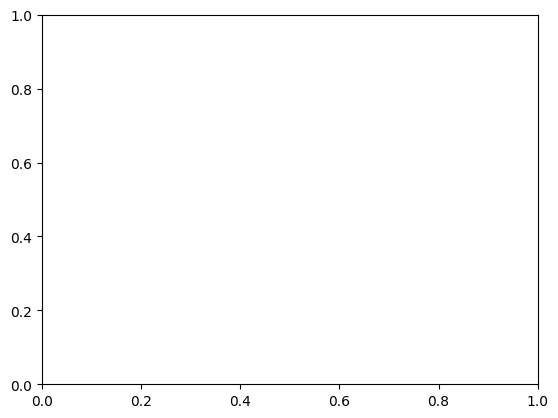

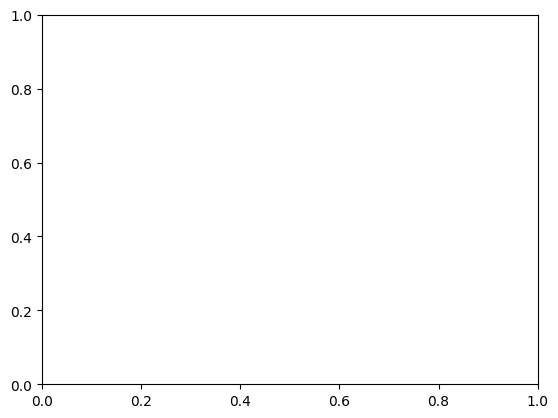

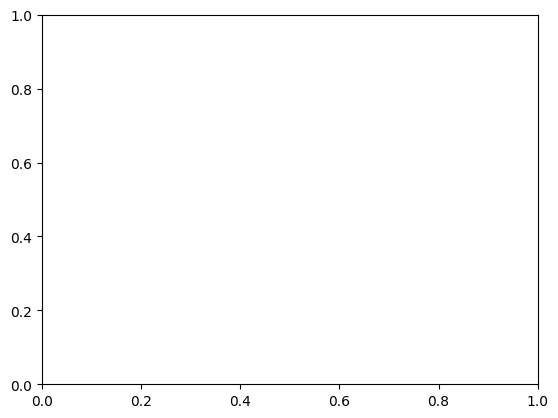

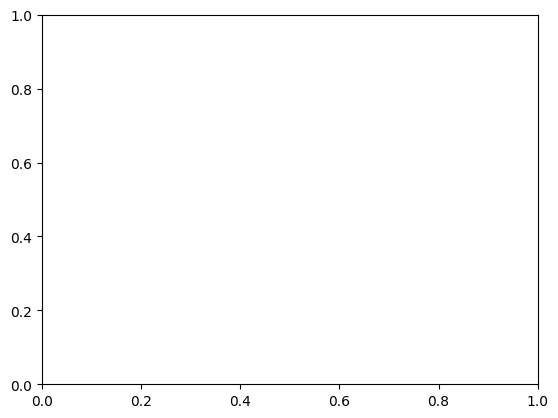

C:\Users\scnoh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    907/1000000 - episode: 1, episode steps: 907, episode reward: 1044.0, max tile: 128.0
   1602/1000000 - episode: 2, episode steps: 695, episode reward: 764.0, max tile: 64.0
   2406/1000000 - episode: 3, episode steps: 804, episode reward: 600.0, max tile: 64.0
   4453/1000000 - episode: 4, episode steps: 2047, episode reward: 3008.0, max tile: 256.0
   5044/1000000 - episode: 5, episode steps: 591, episode reward: 780.0, max tile: 64.0
   5212/1000000 - episode: 6, episode steps: 168, episode reward: 140.0, max tile: 16.0
   5430/1000000 - episode: 7, episode steps: 218, episode reward: 204.0, max tile: 16.0
   5955/1000000 - episode: 8, episode steps: 525, episode reward: 708.0, max tile: 64.0
   6538/1000000 - episode: 9, episode steps: 583, episode reward: 820.0, max tile: 64.0
   6917/1000000 - episode: 10, episode steps: 379, episode reward: 968.0, max tile: 64.0
   7761/1000000 - episode: 11, episode steps: 844, episode reward: 2468.0, max tile: 256.0
   9000/1000000 - episo

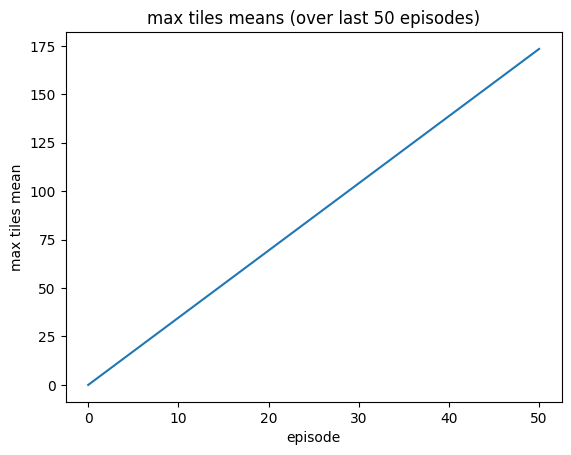

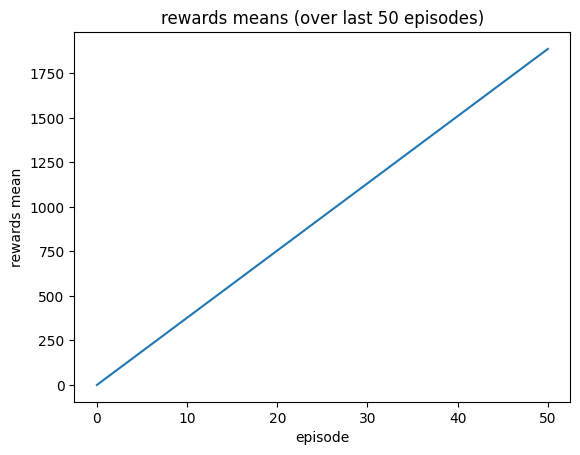

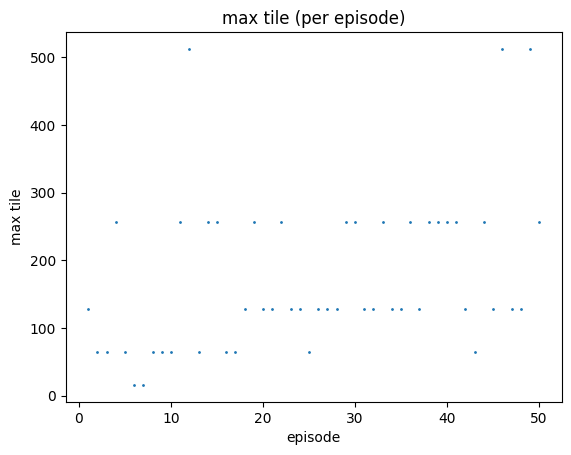

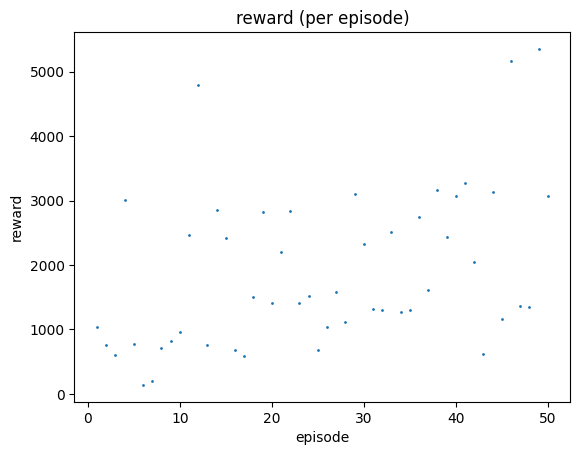

  20839/1000000 - episode: 51, episode steps: 233, episode reward: 1644.0, max tile: 128.0
  21055/1000000 - episode: 52, episode steps: 216, episode reward: 2684.0, max tile: 256.0
  21398/1000000 - episode: 53, episode steps: 343, episode reward: 3156.0, max tile: 256.0
  21529/1000000 - episode: 54, episode steps: 131, episode reward: 1380.0, max tile: 128.0
  21901/1000000 - episode: 55, episode steps: 372, episode reward: 3004.0, max tile: 256.0
  22121/1000000 - episode: 56, episode steps: 220, episode reward: 2260.0, max tile: 256.0
  22293/1000000 - episode: 57, episode steps: 172, episode reward: 1564.0, max tile: 128.0
  22377/1000000 - episode: 58, episode steps: 84, episode reward: 616.0, max tile: 64.0
  22532/1000000 - episode: 59, episode steps: 155, episode reward: 1424.0, max tile: 128.0
  22836/1000000 - episode: 60, episode steps: 304, episode reward: 3404.0, max tile: 256.0
  22945/1000000 - episode: 61, episode steps: 109, episode reward: 704.0, max tile: 64.0
  23

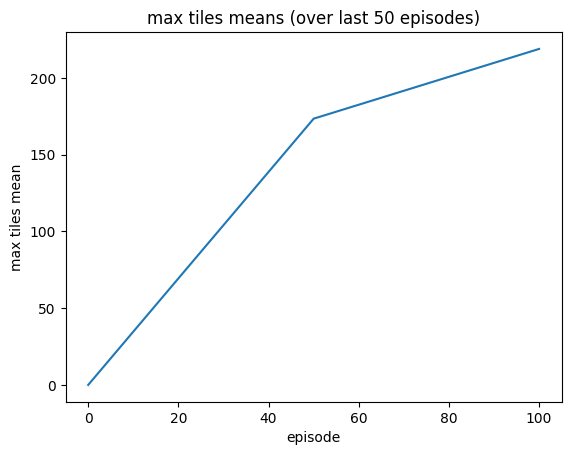

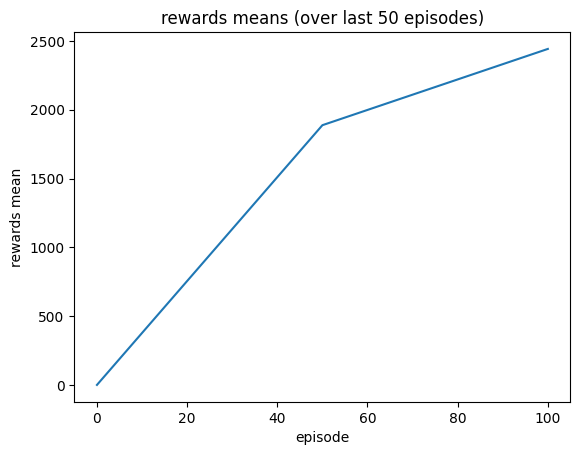

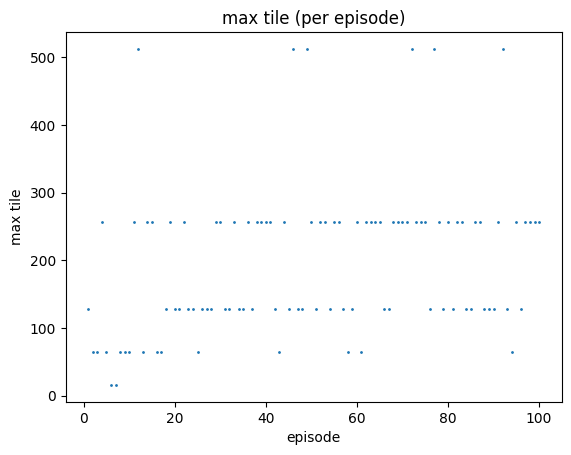

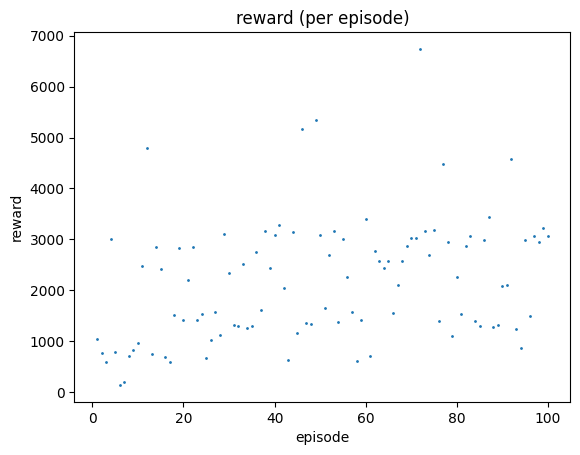

  34608/1000000 - episode: 101, episode steps: 150, episode reward: 1332.0, max tile: 128.0
  34853/1000000 - episode: 102, episode steps: 245, episode reward: 2812.0, max tile: 256.0
  35181/1000000 - episode: 103, episode steps: 328, episode reward: 2748.0, max tile: 256.0
  35404/1000000 - episode: 104, episode steps: 223, episode reward: 2412.0, max tile: 128.0
  35787/1000000 - episode: 105, episode steps: 383, episode reward: 2272.0, max tile: 256.0
  36039/1000000 - episode: 106, episode steps: 252, episode reward: 3264.0, max tile: 256.0
  36260/1000000 - episode: 107, episode steps: 221, episode reward: 2732.0, max tile: 256.0
  36553/1000000 - episode: 108, episode steps: 293, episode reward: 2524.0, max tile: 256.0
  36923/1000000 - episode: 109, episode steps: 370, episode reward: 3080.0, max tile: 256.0
  37161/1000000 - episode: 110, episode steps: 238, episode reward: 2800.0, max tile: 256.0
  37468/1000000 - episode: 111, episode steps: 307, episode reward: 3224.0, max 

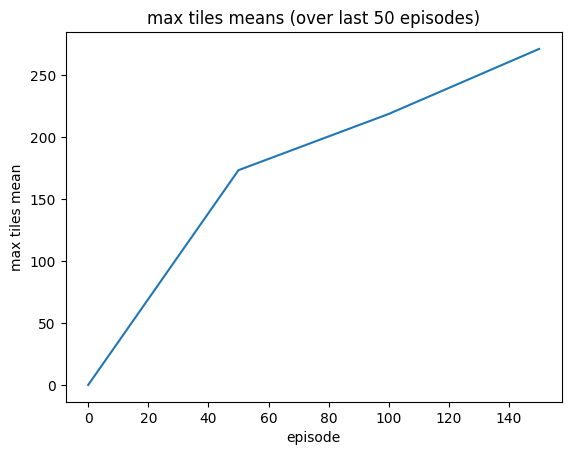

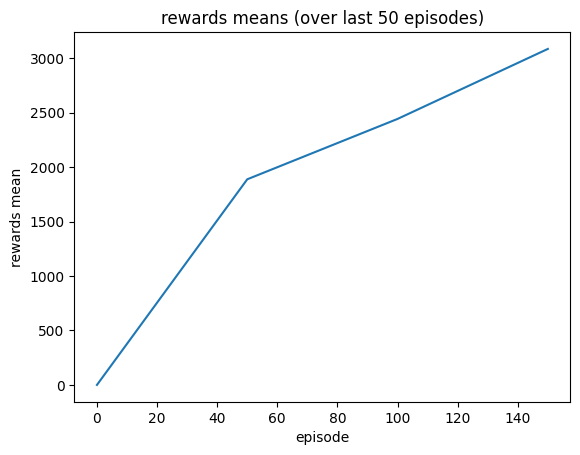

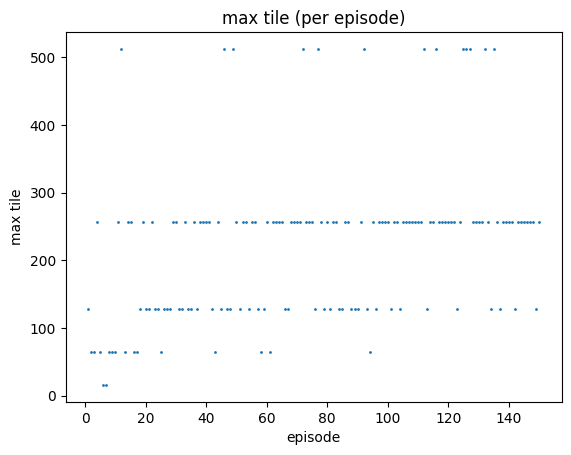

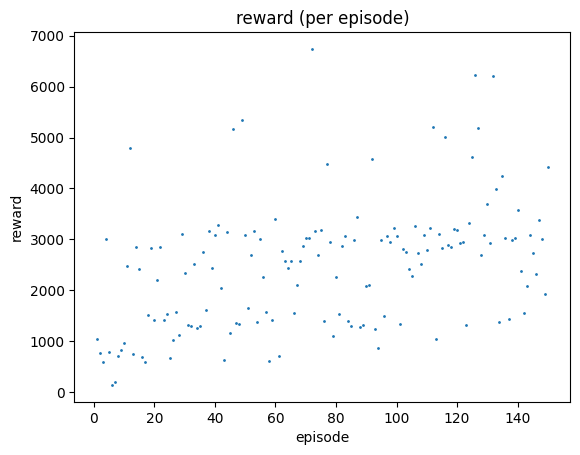

  49697/1000000 - episode: 151, episode steps: 451, episode reward: 6252.0, max tile: 512.0
  49983/1000000 - episode: 152, episode steps: 286, episode reward: 2472.0, max tile: 256.0
  50181/1000000 - episode: 153, episode steps: 198, episode reward: 2280.0, max tile: 256.0
  50601/1000000 - episode: 154, episode steps: 420, episode reward: 4680.0, max tile: 512.0
  50902/1000000 - episode: 155, episode steps: 301, episode reward: 2936.0, max tile: 256.0
  51198/1000000 - episode: 156, episode steps: 296, episode reward: 3240.0, max tile: 256.0
  51535/1000000 - episode: 157, episode steps: 337, episode reward: 2700.0, max tile: 256.0
  51776/1000000 - episode: 158, episode steps: 241, episode reward: 1700.0, max tile: 128.0
  52171/1000000 - episode: 159, episode steps: 395, episode reward: 5040.0, max tile: 512.0
  52427/1000000 - episode: 160, episode steps: 256, episode reward: 2352.0, max tile: 256.0
  52682/1000000 - episode: 161, episode steps: 255, episode reward: 3072.0, max 

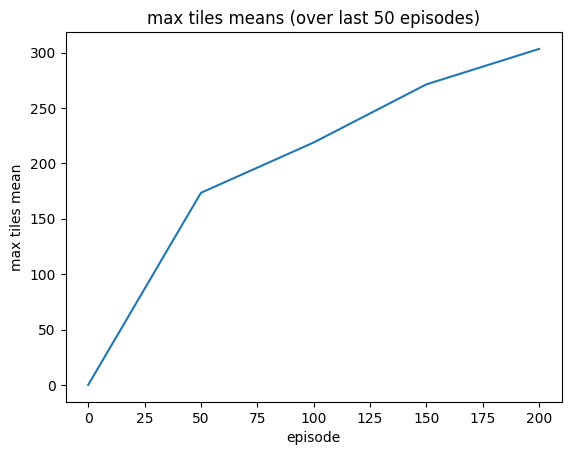

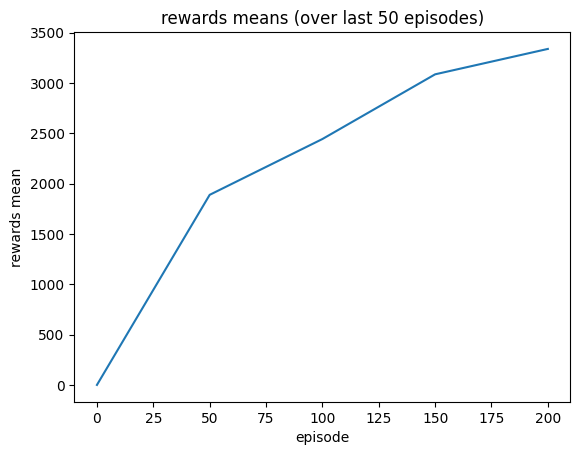

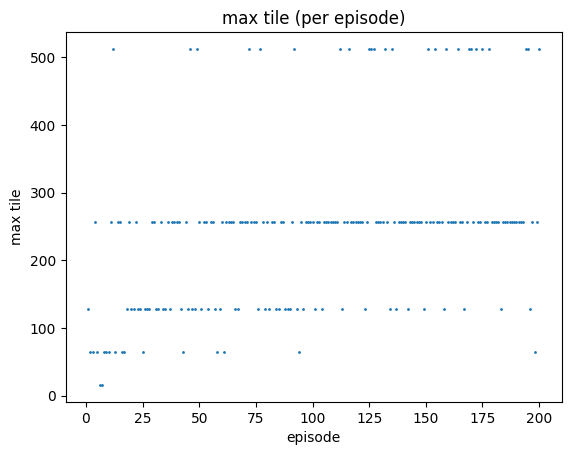

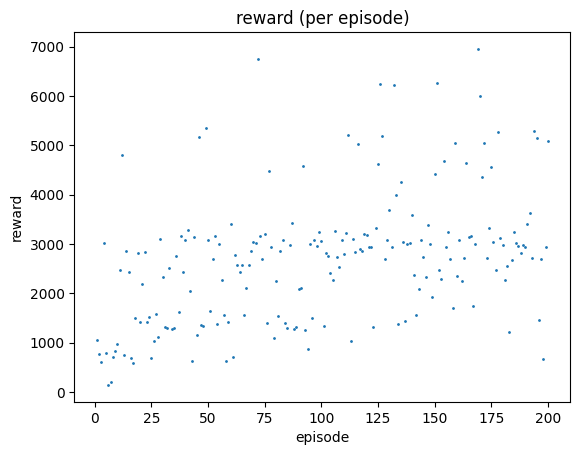

  65041/1000000 - episode: 201, episode steps: 475, episode reward: 3384.0, max tile: 256.0
  65396/1000000 - episode: 202, episode steps: 355, episode reward: 4772.0, max tile: 512.0
  65585/1000000 - episode: 203, episode steps: 189, episode reward: 1524.0, max tile: 128.0
  65764/1000000 - episode: 204, episode steps: 179, episode reward: 1716.0, max tile: 128.0
  66098/1000000 - episode: 205, episode steps: 334, episode reward: 3028.0, max tile: 256.0
  66295/1000000 - episode: 206, episode steps: 197, episode reward: 2248.0, max tile: 256.0
  66500/1000000 - episode: 207, episode steps: 205, episode reward: 2492.0, max tile: 256.0
  66772/1000000 - episode: 208, episode steps: 272, episode reward: 1732.0, max tile: 128.0
  67082/1000000 - episode: 209, episode steps: 310, episode reward: 3088.0, max tile: 256.0
  67278/1000000 - episode: 210, episode steps: 196, episode reward: 1692.0, max tile: 128.0
  67424/1000000 - episode: 211, episode steps: 146, episode reward: 1292.0, max 

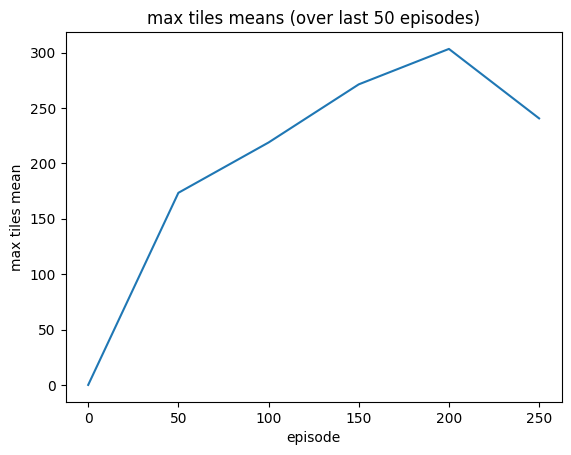

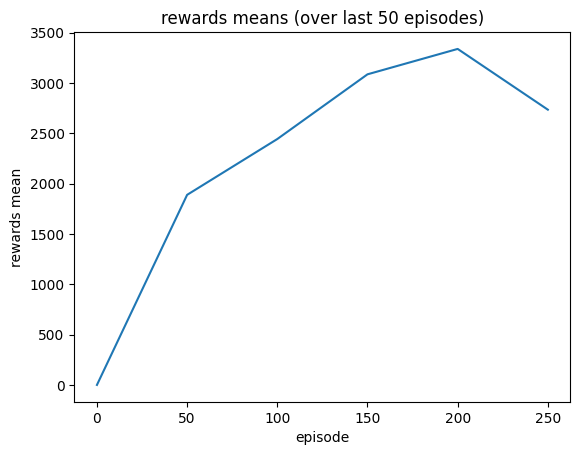

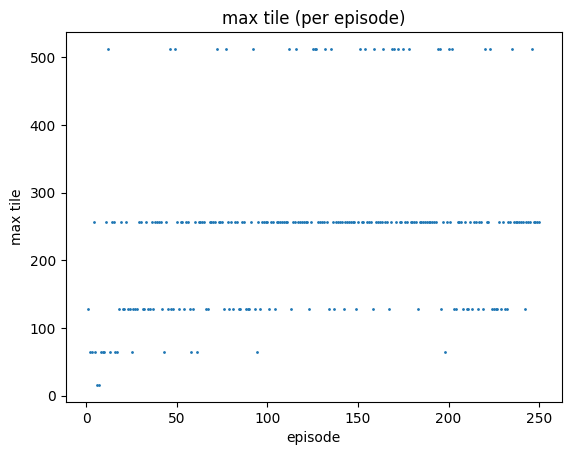

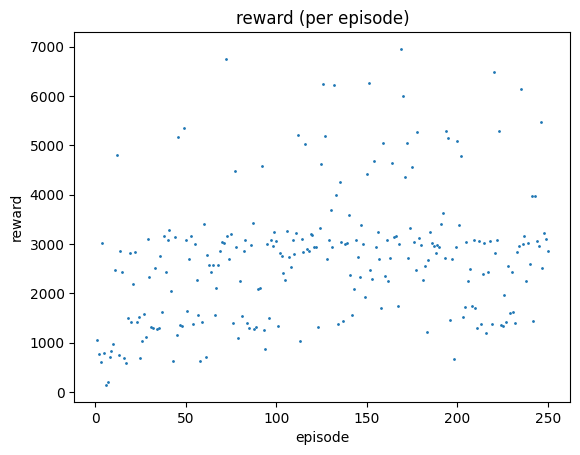

  80259/1000000 - episode: 251, episode steps: 405, episode reward: 3256.0, max tile: 256.0
  80708/1000000 - episode: 252, episode steps: 449, episode reward: 6228.0, max tile: 512.0
  81051/1000000 - episode: 253, episode steps: 343, episode reward: 5044.0, max tile: 512.0
  81522/1000000 - episode: 254, episode steps: 471, episode reward: 5032.0, max tile: 512.0
  82015/1000000 - episode: 255, episode steps: 493, episode reward: 5192.0, max tile: 512.0
  82290/1000000 - episode: 256, episode steps: 275, episode reward: 2104.0, max tile: 128.0
  82619/1000000 - episode: 257, episode steps: 329, episode reward: 3544.0, max tile: 256.0
  83020/1000000 - episode: 258, episode steps: 401, episode reward: 3592.0, max tile: 256.0
  83226/1000000 - episode: 259, episode steps: 206, episode reward: 2028.0, max tile: 128.0
  83543/1000000 - episode: 260, episode steps: 317, episode reward: 3176.0, max tile: 256.0
  83878/1000000 - episode: 261, episode steps: 335, episode reward: 3172.0, max 

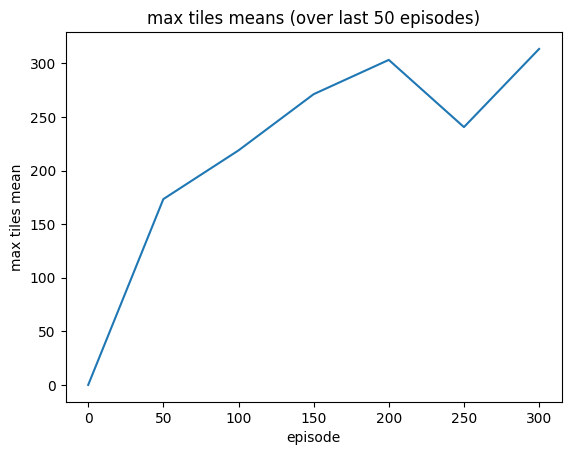

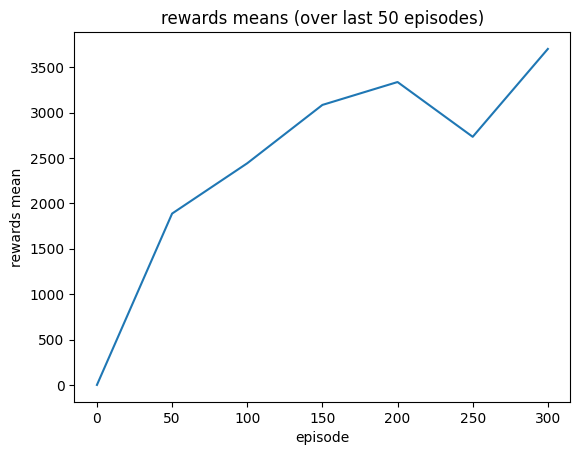

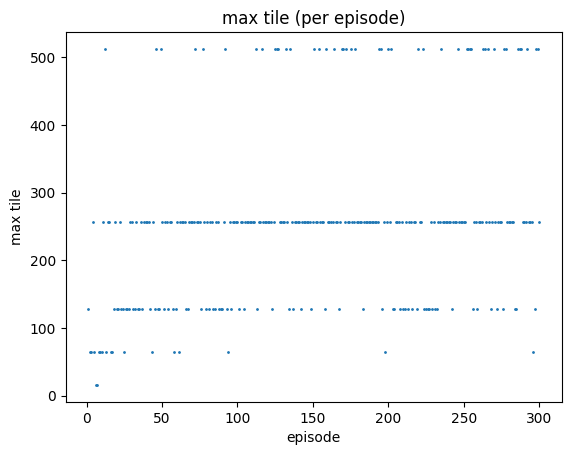

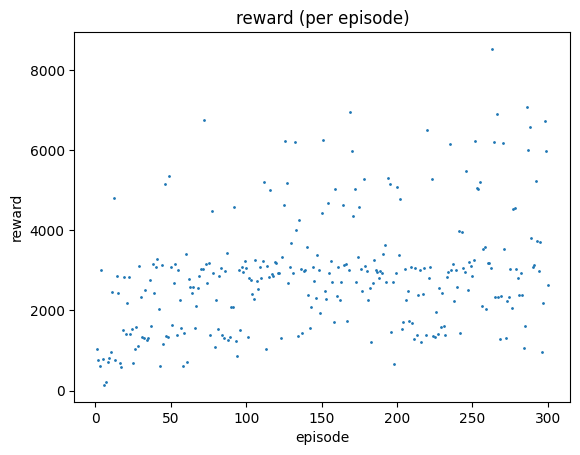

  98724/1000000 - episode: 301, episode steps: 420, episode reward: 4428.0, max tile: 256.0
  99030/1000000 - episode: 302, episode steps: 306, episode reward: 3252.0, max tile: 256.0
  99456/1000000 - episode: 303, episode steps: 426, episode reward: 4600.0, max tile: 512.0
  99666/1000000 - episode: 304, episode steps: 210, episode reward: 2644.0, max tile: 256.0
  99934/1000000 - episode: 305, episode steps: 268, episode reward: 3268.0, max tile: 256.0
 100552/1000000 - episode: 306, episode steps: 618, episode reward: 6880.0, max tile: 512.0
 100830/1000000 - episode: 307, episode steps: 278, episode reward: 2360.0, max tile: 256.0
 101067/1000000 - episode: 308, episode steps: 237, episode reward: 2932.0, max tile: 256.0
 101390/1000000 - episode: 309, episode steps: 323, episode reward: 3000.0, max tile: 256.0
 101683/1000000 - episode: 310, episode steps: 293, episode reward: 2452.0, max tile: 256.0
 101960/1000000 - episode: 311, episode steps: 277, episode reward: 2984.0, max 

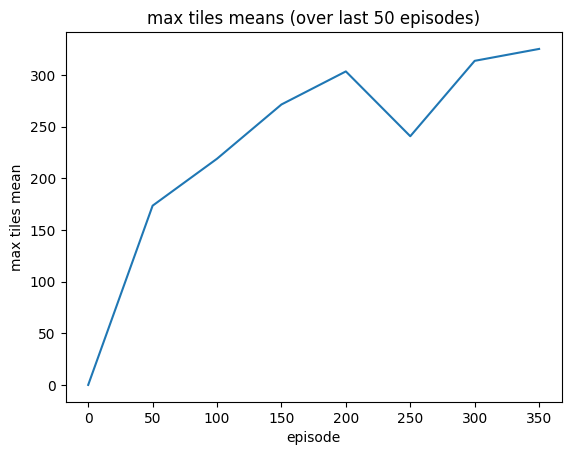

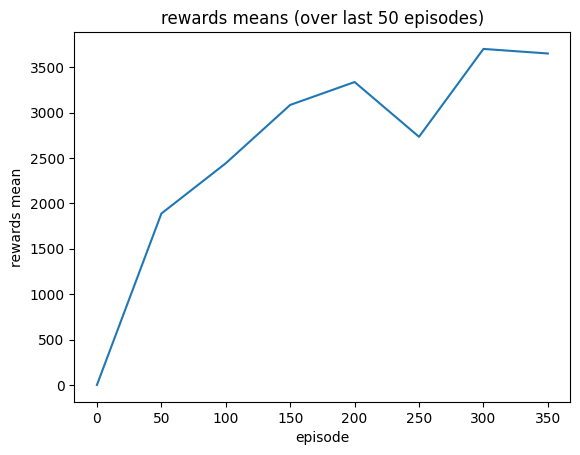

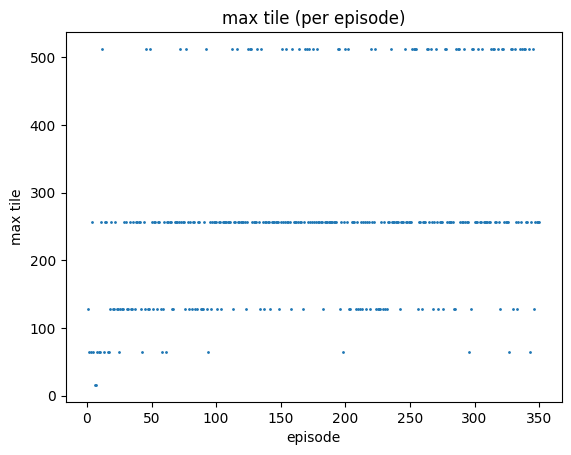

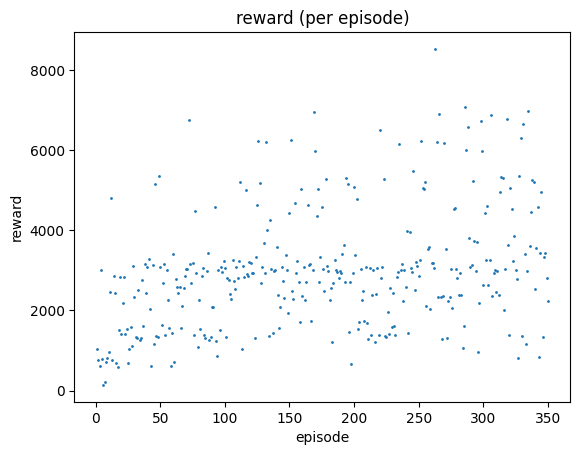

 116383/1000000 - episode: 351, episode steps: 361, episode reward: 3720.0, max tile: 256.0
 116702/1000000 - episode: 352, episode steps: 319, episode reward: 3088.0, max tile: 256.0
 117109/1000000 - episode: 353, episode steps: 407, episode reward: 3488.0, max tile: 256.0
 117614/1000000 - episode: 354, episode steps: 505, episode reward: 6168.0, max tile: 512.0
 117870/1000000 - episode: 355, episode steps: 256, episode reward: 3224.0, max tile: 256.0
 118068/1000000 - episode: 356, episode steps: 198, episode reward: 2068.0, max tile: 256.0
 118382/1000000 - episode: 357, episode steps: 314, episode reward: 2780.0, max tile: 256.0
 118760/1000000 - episode: 358, episode steps: 378, episode reward: 2120.0, max tile: 128.0
 119028/1000000 - episode: 359, episode steps: 268, episode reward: 2704.0, max tile: 256.0
 119229/1000000 - episode: 360, episode steps: 201, episode reward: 1372.0, max tile: 128.0
 119747/1000000 - episode: 361, episode steps: 518, episode reward: 3928.0, max 

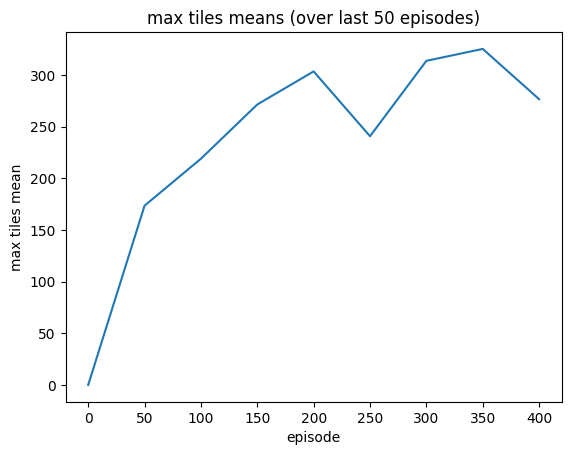

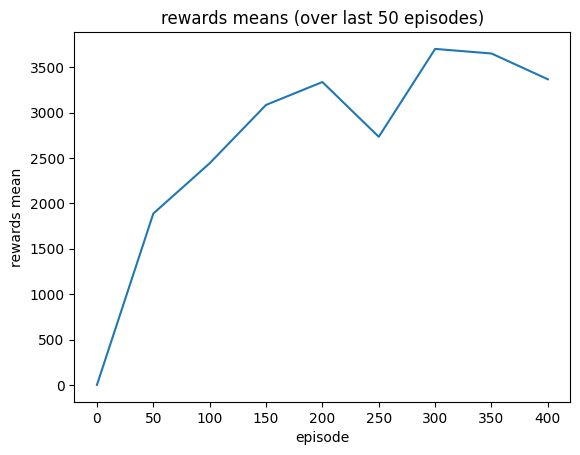

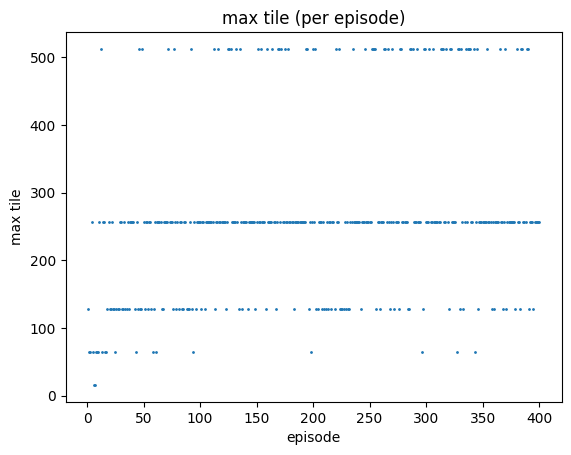

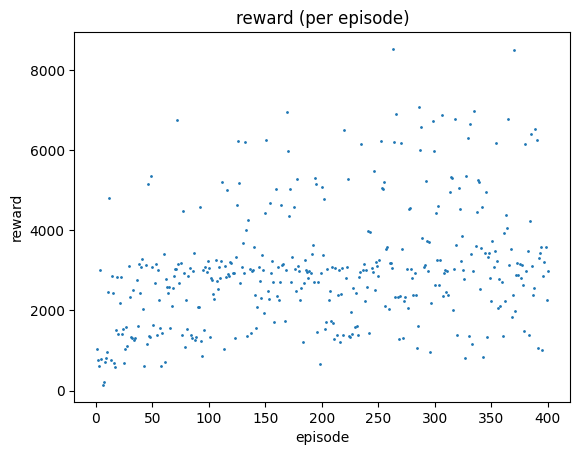

 132619/1000000 - episode: 401, episode steps: 228, episode reward: 2952.0, max tile: 256.0
 132793/1000000 - episode: 402, episode steps: 174, episode reward: 1368.0, max tile: 128.0
 133138/1000000 - episode: 403, episode steps: 345, episode reward: 3188.0, max tile: 256.0
 133518/1000000 - episode: 404, episode steps: 380, episode reward: 3300.0, max tile: 256.0
 133815/1000000 - episode: 405, episode steps: 297, episode reward: 2876.0, max tile: 256.0
 134141/1000000 - episode: 406, episode steps: 326, episode reward: 3412.0, max tile: 256.0
 134674/1000000 - episode: 407, episode steps: 533, episode reward: 5344.0, max tile: 512.0
 134902/1000000 - episode: 408, episode steps: 228, episode reward: 2356.0, max tile: 256.0
 135098/1000000 - episode: 409, episode steps: 196, episode reward: 1356.0, max tile: 128.0
 135422/1000000 - episode: 410, episode steps: 324, episode reward: 3308.0, max tile: 256.0
 135761/1000000 - episode: 411, episode steps: 339, episode reward: 5100.0, max 

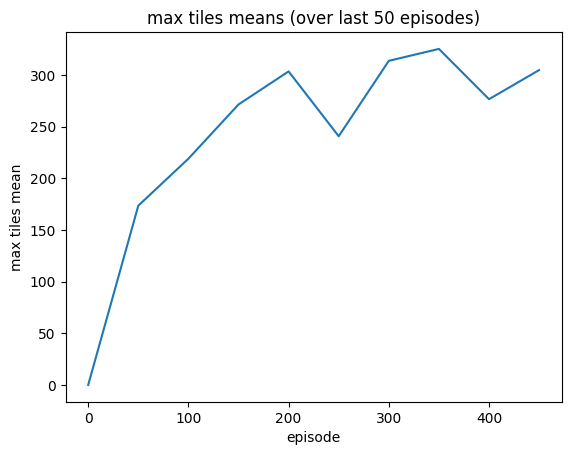

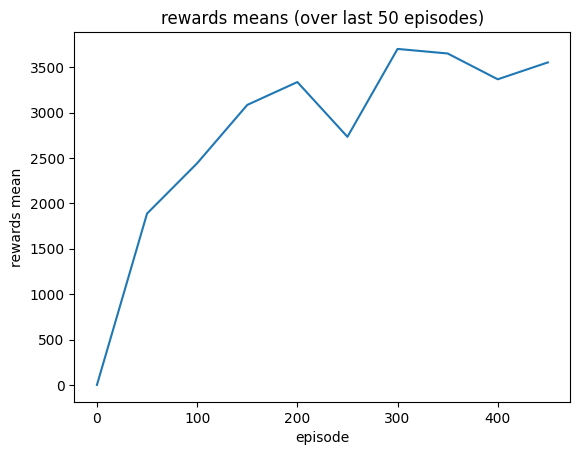

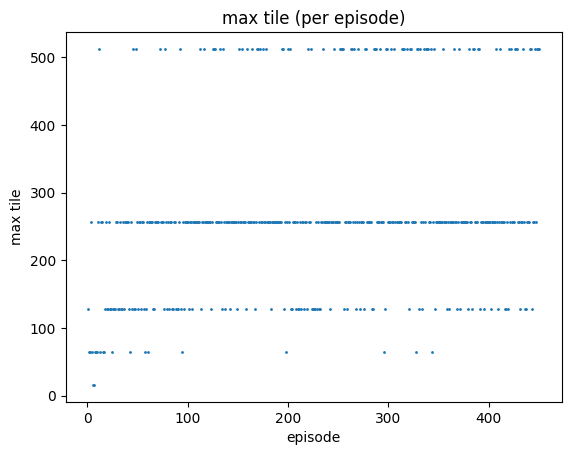

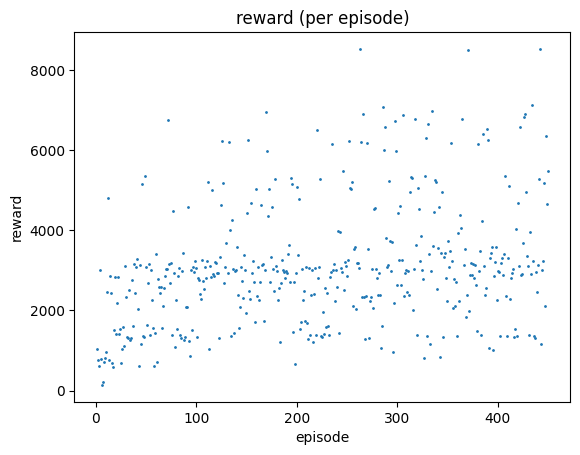

 149902/1000000 - episode: 451, episode steps: 247, episode reward: 2348.0, max tile: 256.0
 150220/1000000 - episode: 452, episode steps: 318, episode reward: 3320.0, max tile: 256.0
 150646/1000000 - episode: 453, episode steps: 426, episode reward: 5988.0, max tile: 512.0
 150913/1000000 - episode: 454, episode steps: 267, episode reward: 2320.0, max tile: 256.0
 151358/1000000 - episode: 455, episode steps: 445, episode reward: 5304.0, max tile: 512.0
 151573/1000000 - episode: 456, episode steps: 215, episode reward: 2276.0, max tile: 256.0
 152077/1000000 - episode: 457, episode steps: 504, episode reward: 7040.0, max tile: 512.0
 152485/1000000 - episode: 458, episode steps: 408, episode reward: 5288.0, max tile: 512.0
 152929/1000000 - episode: 459, episode steps: 444, episode reward: 5324.0, max tile: 512.0
 153422/1000000 - episode: 460, episode steps: 493, episode reward: 6020.0, max tile: 512.0
 153590/1000000 - episode: 461, episode steps: 168, episode reward: 1316.0, max 

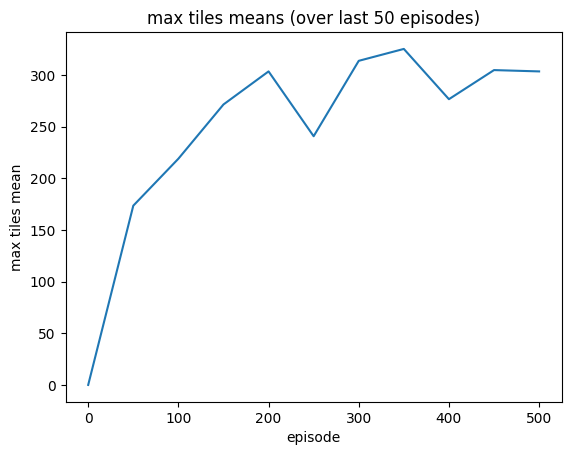

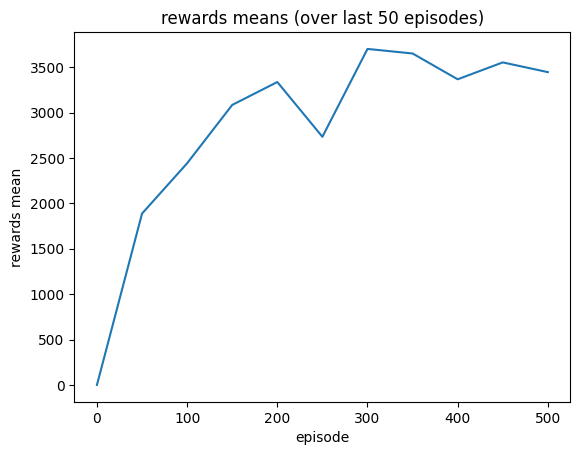

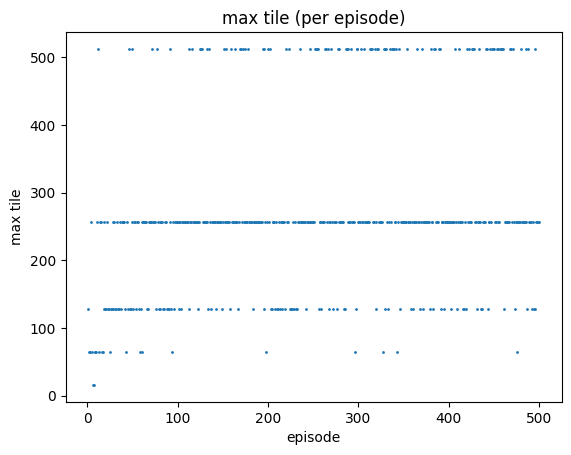

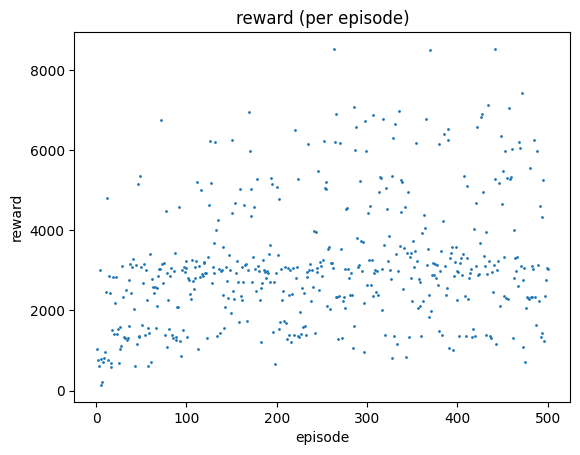

 166755/1000000 - episode: 501, episode steps: 659, episode reward: 6612.0, max tile: 512.0
 167257/1000000 - episode: 502, episode steps: 502, episode reward: 6676.0, max tile: 512.0
 167489/1000000 - episode: 503, episode steps: 232, episode reward: 2976.0, max tile: 256.0
 167781/1000000 - episode: 504, episode steps: 292, episode reward: 3356.0, max tile: 256.0
 167897/1000000 - episode: 505, episode steps: 116, episode reward: 1124.0, max tile: 128.0
 168158/1000000 - episode: 506, episode steps: 261, episode reward: 2308.0, max tile: 256.0
 168388/1000000 - episode: 507, episode steps: 230, episode reward: 1224.0, max tile: 128.0
 168619/1000000 - episode: 508, episode steps: 231, episode reward: 2028.0, max tile: 256.0
 168948/1000000 - episode: 509, episode steps: 329, episode reward: 4184.0, max tile: 512.0
 169240/1000000 - episode: 510, episode steps: 292, episode reward: 2980.0, max tile: 256.0
 169400/1000000 - episode: 511, episode steps: 160, episode reward: 1468.0, max 

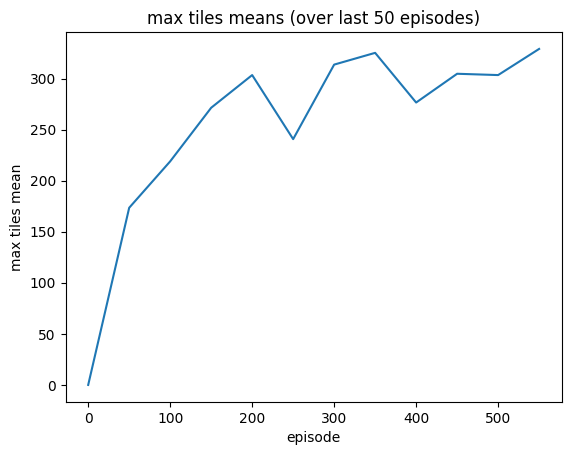

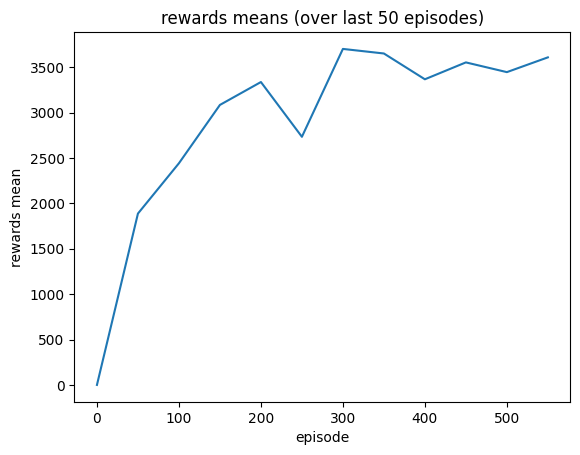

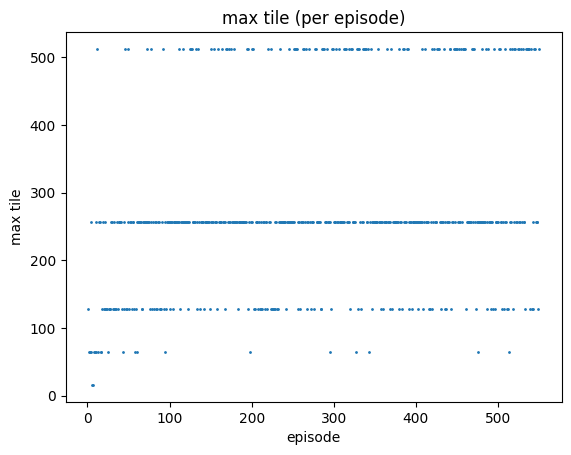

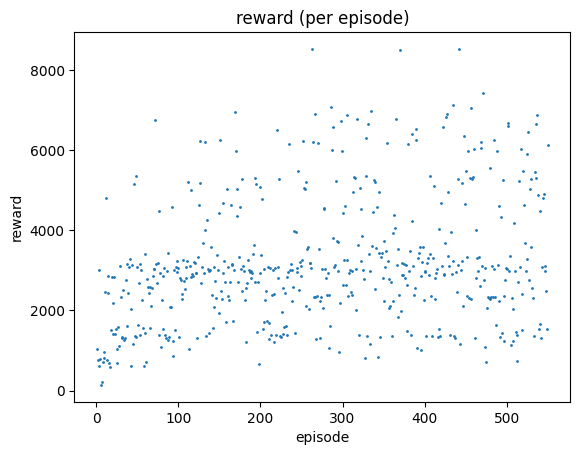

 183267/1000000 - episode: 551, episode steps: 287, episode reward: 2928.0, max tile: 256.0
 183569/1000000 - episode: 552, episode steps: 302, episode reward: 3048.0, max tile: 256.0
 183831/1000000 - episode: 553, episode steps: 262, episode reward: 2208.0, max tile: 256.0
 184111/1000000 - episode: 554, episode steps: 280, episode reward: 2024.0, max tile: 128.0
 184633/1000000 - episode: 555, episode steps: 522, episode reward: 6216.0, max tile: 512.0
 184845/1000000 - episode: 556, episode steps: 212, episode reward: 1352.0, max tile: 128.0
 185057/1000000 - episode: 557, episode steps: 212, episode reward: 2252.0, max tile: 256.0
 185437/1000000 - episode: 558, episode steps: 380, episode reward: 5428.0, max tile: 512.0
 185683/1000000 - episode: 559, episode steps: 246, episode reward: 3160.0, max tile: 256.0
 185890/1000000 - episode: 560, episode steps: 207, episode reward: 1980.0, max tile: 128.0
 186247/1000000 - episode: 561, episode steps: 357, episode reward: 5248.0, max 

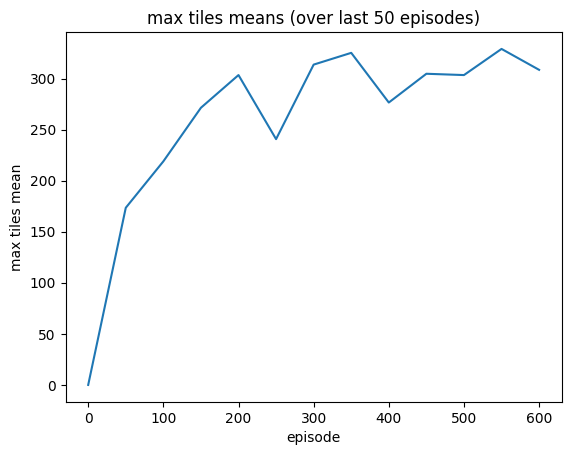

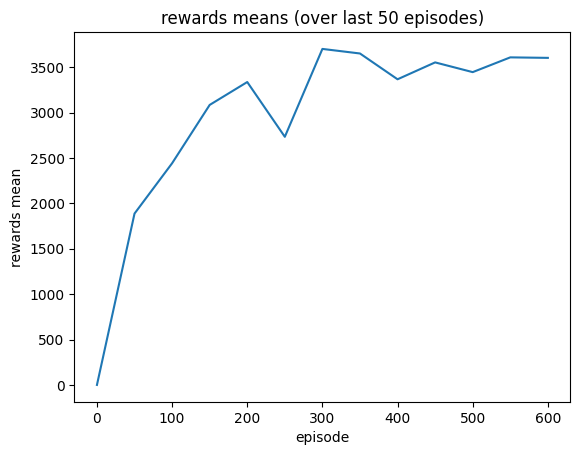

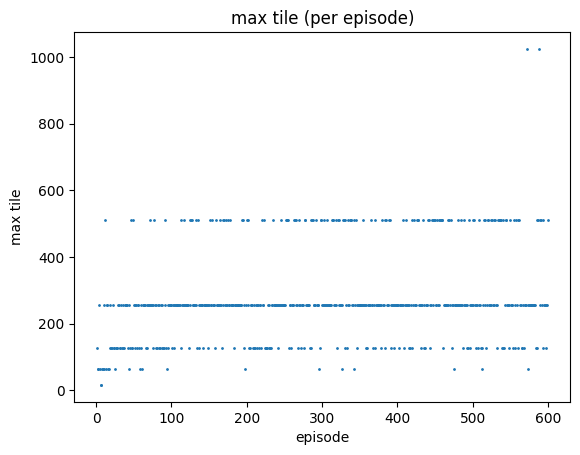

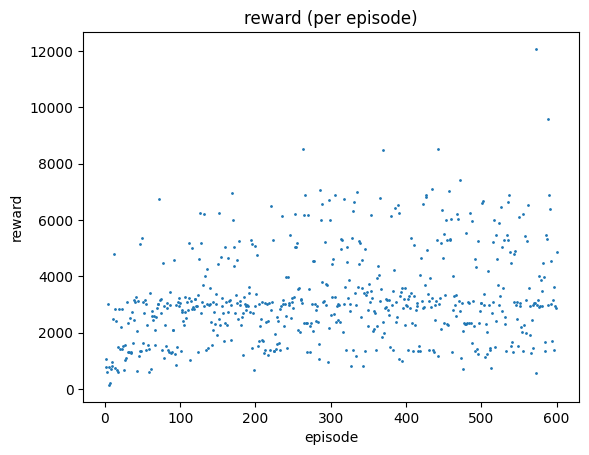

 200827/1000000 - episode: 601, episode steps: 178, episode reward: 2252.0, max tile: 256.0
 201087/1000000 - episode: 602, episode steps: 260, episode reward: 2736.0, max tile: 256.0
 201545/1000000 - episode: 603, episode steps: 458, episode reward: 4628.0, max tile: 512.0
 202005/1000000 - episode: 604, episode steps: 460, episode reward: 5536.0, max tile: 512.0
 202289/1000000 - episode: 605, episode steps: 284, episode reward: 2820.0, max tile: 256.0
 202535/1000000 - episode: 606, episode steps: 246, episode reward: 2856.0, max tile: 256.0
 202743/1000000 - episode: 607, episode steps: 208, episode reward: 2352.0, max tile: 256.0
 202917/1000000 - episode: 608, episode steps: 174, episode reward: 1892.0, max tile: 128.0
 203346/1000000 - episode: 609, episode steps: 429, episode reward: 6168.0, max tile: 512.0
 203551/1000000 - episode: 610, episode steps: 205, episode reward: 2312.0, max tile: 256.0
 203831/1000000 - episode: 611, episode steps: 280, episode reward: 2840.0, max 

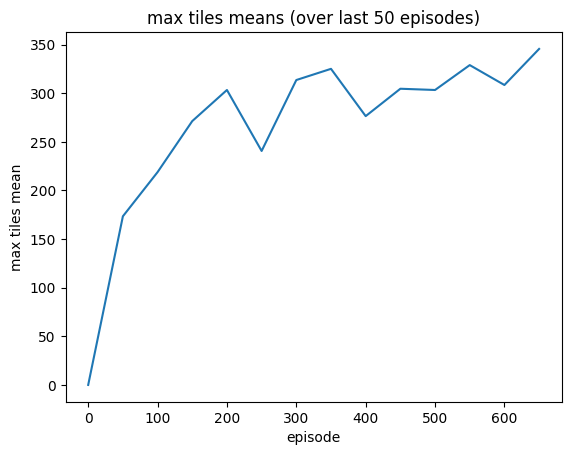

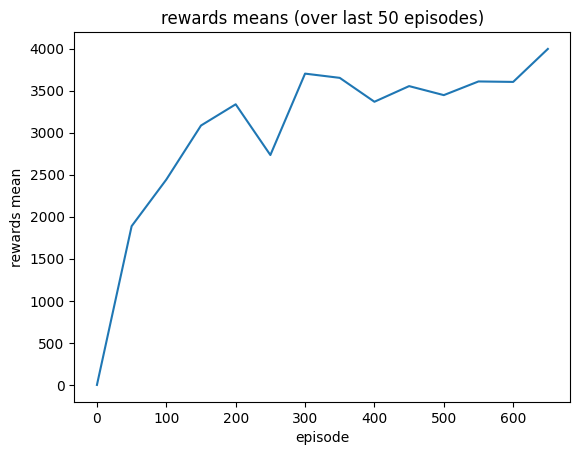

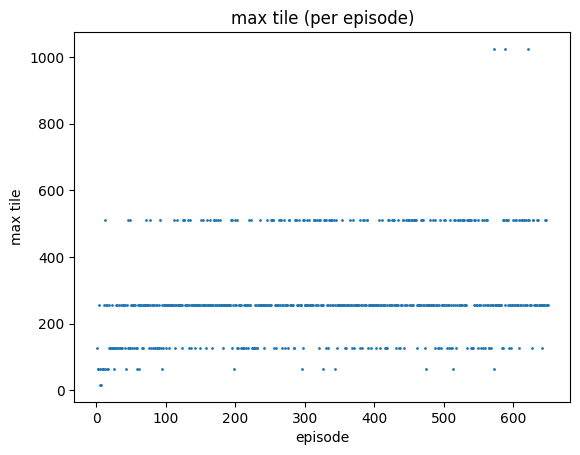

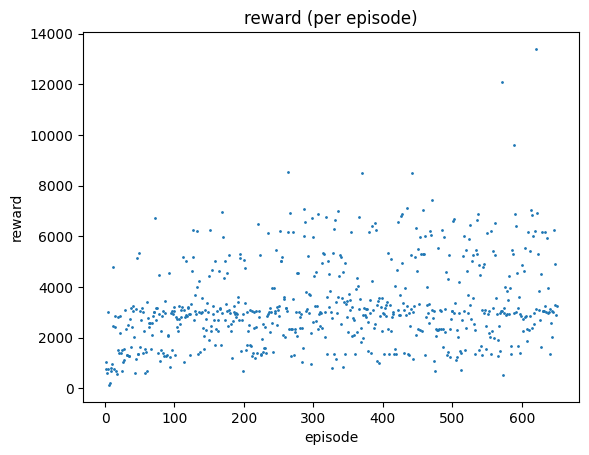

 218853/1000000 - episode: 651, episode steps: 473, episode reward: 7312.0, max tile: 512.0
 218977/1000000 - episode: 652, episode steps: 124, episode reward: 1288.0, max tile: 128.0
 219193/1000000 - episode: 653, episode steps: 216, episode reward: 2336.0, max tile: 256.0
 219658/1000000 - episode: 654, episode steps: 465, episode reward: 5636.0, max tile: 512.0
 219918/1000000 - episode: 655, episode steps: 260, episode reward: 2992.0, max tile: 256.0
 220216/1000000 - episode: 656, episode steps: 298, episode reward: 2984.0, max tile: 256.0
 220652/1000000 - episode: 657, episode steps: 436, episode reward: 3484.0, max tile: 256.0
 220979/1000000 - episode: 658, episode steps: 327, episode reward: 2908.0, max tile: 256.0
 221230/1000000 - episode: 659, episode steps: 251, episode reward: 2864.0, max tile: 256.0
 221447/1000000 - episode: 660, episode steps: 217, episode reward: 2708.0, max tile: 256.0
 221903/1000000 - episode: 661, episode steps: 456, episode reward: 5240.0, max 

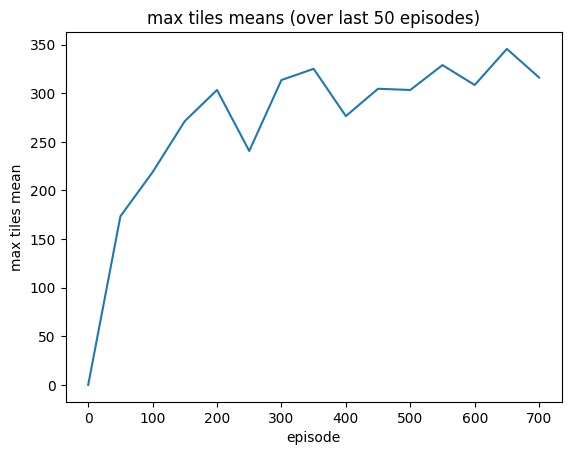

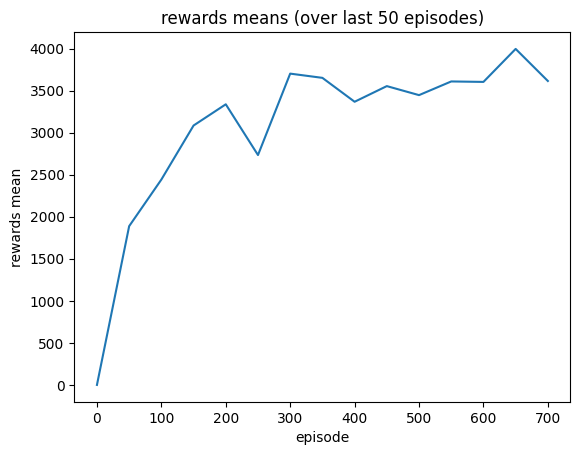

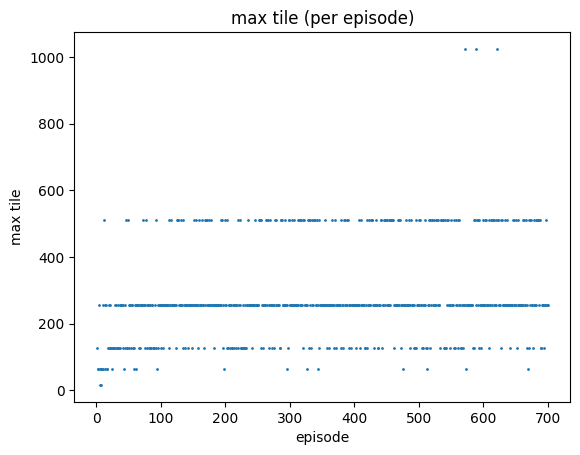

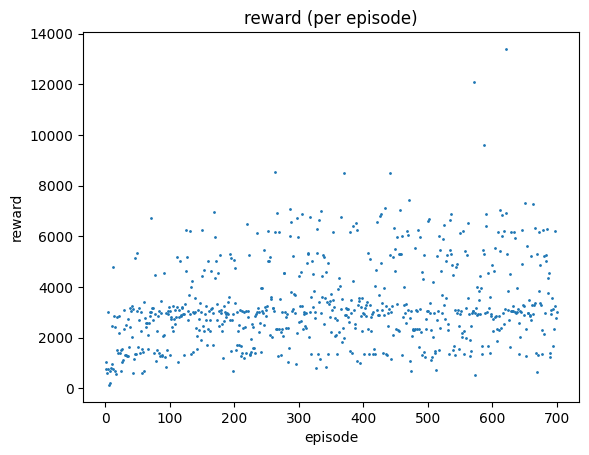

 236897/1000000 - episode: 701, episode steps: 326, episode reward: 3332.0, max tile: 256.0
 237455/1000000 - episode: 702, episode steps: 558, episode reward: 6864.0, max tile: 512.0
 238166/1000000 - episode: 703, episode steps: 711, episode reward: 10136.0, max tile: 1024.0
 238433/1000000 - episode: 704, episode steps: 267, episode reward: 2924.0, max tile: 256.0
 238699/1000000 - episode: 705, episode steps: 266, episode reward: 3028.0, max tile: 256.0
 239054/1000000 - episode: 706, episode steps: 355, episode reward: 2708.0, max tile: 256.0
 239293/1000000 - episode: 707, episode steps: 239, episode reward: 3028.0, max tile: 256.0
 239834/1000000 - episode: 708, episode steps: 541, episode reward: 5372.0, max tile: 512.0
 240365/1000000 - episode: 709, episode steps: 531, episode reward: 3048.0, max tile: 256.0
 240659/1000000 - episode: 710, episode steps: 294, episode reward: 2908.0, max tile: 256.0
 241001/1000000 - episode: 711, episode steps: 342, episode reward: 1536.0, ma

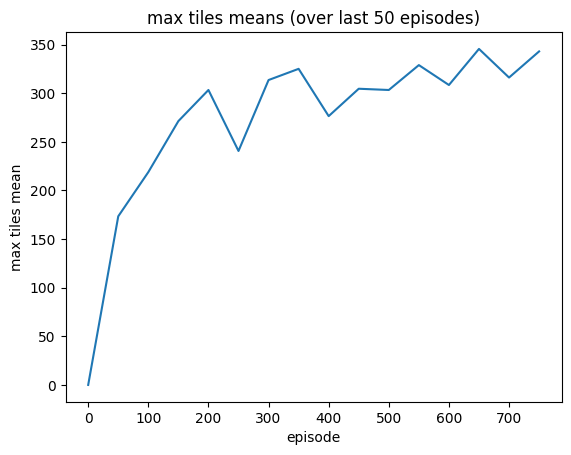

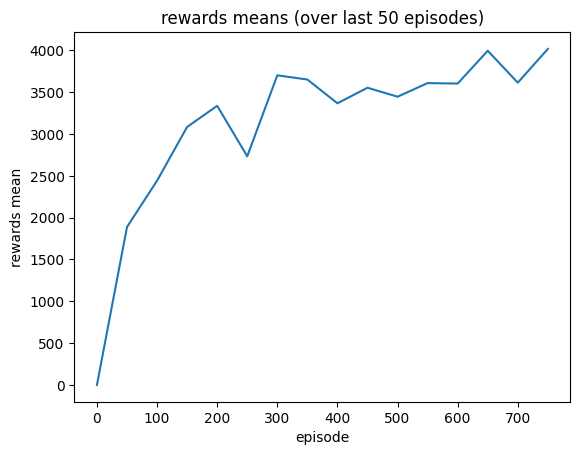

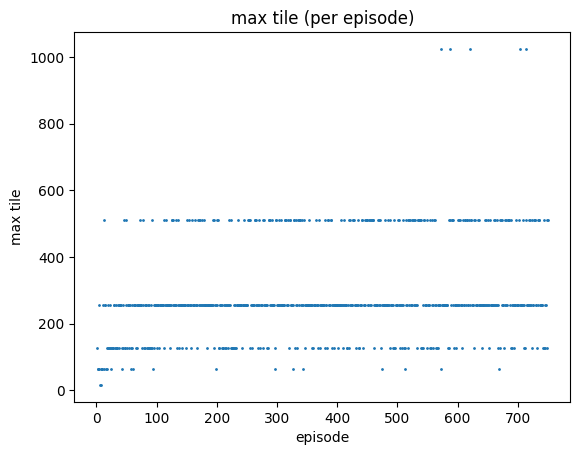

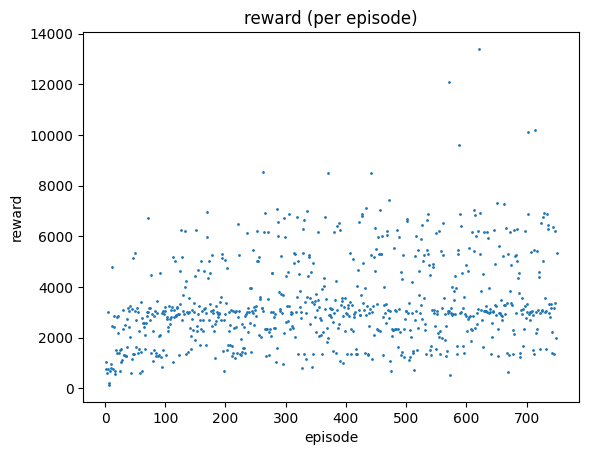

 256702/1000000 - episode: 751, episode steps: 185, episode reward: 1884.0, max tile: 128.0
 257196/1000000 - episode: 752, episode steps: 494, episode reward: 6248.0, max tile: 512.0
 257649/1000000 - episode: 753, episode steps: 453, episode reward: 3296.0, max tile: 256.0
 258097/1000000 - episode: 754, episode steps: 448, episode reward: 2900.0, max tile: 256.0
 258723/1000000 - episode: 755, episode steps: 626, episode reward: 6716.0, max tile: 512.0
 259062/1000000 - episode: 756, episode steps: 339, episode reward: 5172.0, max tile: 512.0
 259414/1000000 - episode: 757, episode steps: 352, episode reward: 2068.0, max tile: 128.0
 259598/1000000 - episode: 758, episode steps: 184, episode reward: 1436.0, max tile: 128.0
 260014/1000000 - episode: 759, episode steps: 416, episode reward: 3068.0, max tile: 256.0
 260162/1000000 - episode: 760, episode steps: 148, episode reward: 1240.0, max tile: 128.0
 260476/1000000 - episode: 761, episode steps: 314, episode reward: 3604.0, max 

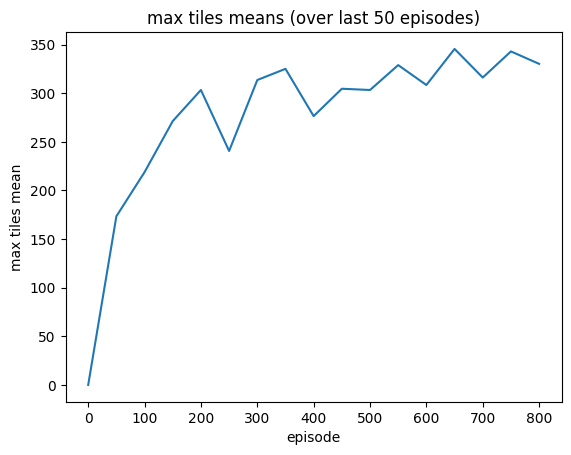

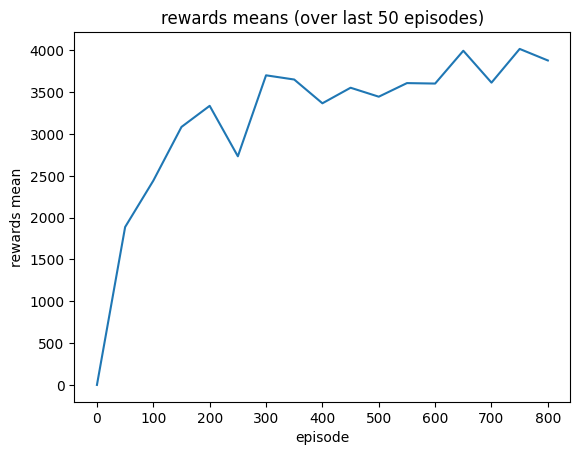

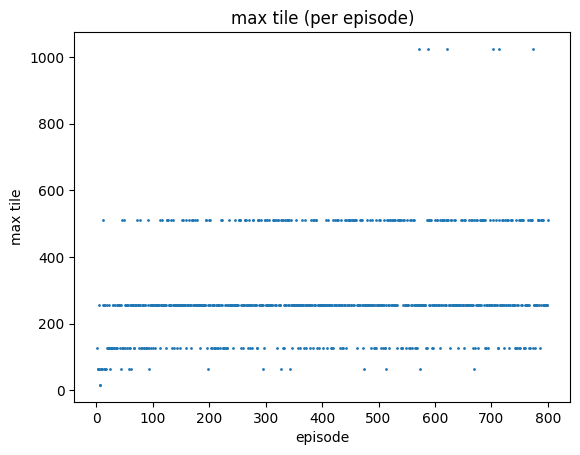

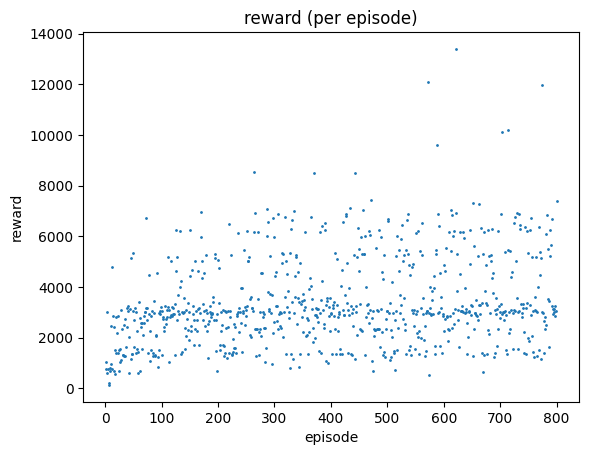

 276786/1000000 - episode: 801, episode steps: 536, episode reward: 6196.0, max tile: 512.0
 276945/1000000 - episode: 802, episode steps: 159, episode reward: 1324.0, max tile: 128.0
 277593/1000000 - episode: 803, episode steps: 648, episode reward: 7252.0, max tile: 512.0
 278027/1000000 - episode: 804, episode steps: 434, episode reward: 5684.0, max tile: 512.0
 278230/1000000 - episode: 805, episode steps: 203, episode reward: 1916.0, max tile: 128.0
 278761/1000000 - episode: 806, episode steps: 531, episode reward: 5692.0, max tile: 256.0
 279040/1000000 - episode: 807, episode steps: 279, episode reward: 2916.0, max tile: 256.0
 279521/1000000 - episode: 808, episode steps: 481, episode reward: 5672.0, max tile: 512.0
 280015/1000000 - episode: 809, episode steps: 494, episode reward: 5252.0, max tile: 512.0
 280503/1000000 - episode: 810, episode steps: 488, episode reward: 5408.0, max tile: 512.0
 281320/1000000 - episode: 811, episode steps: 817, episode reward: 6900.0, max 

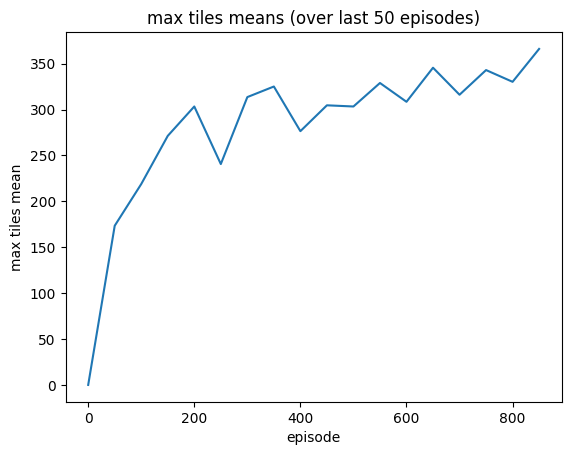

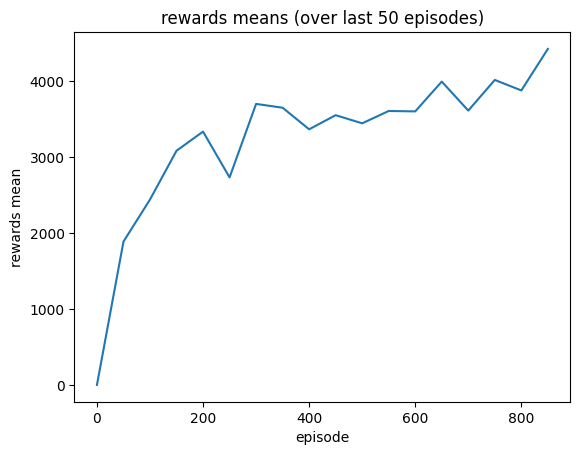

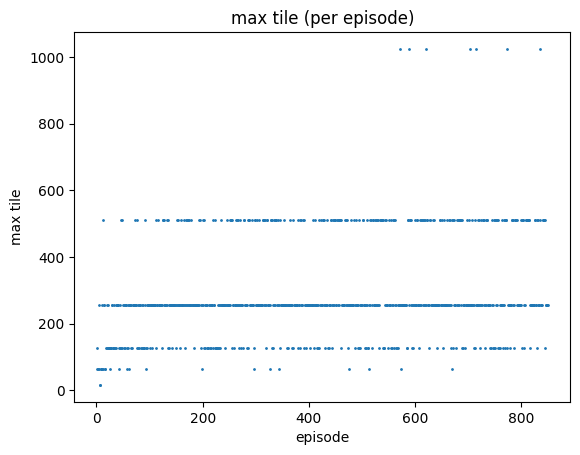

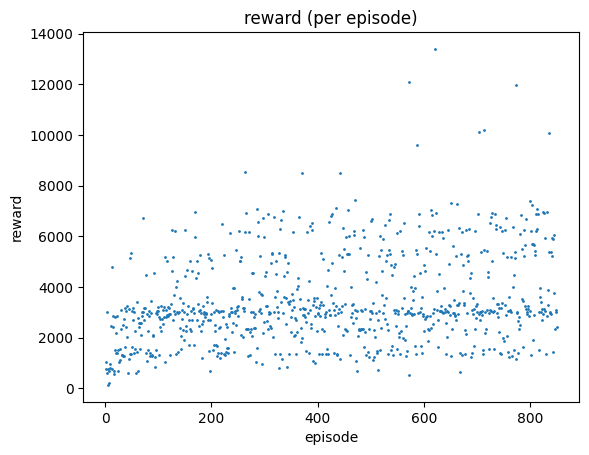

 297647/1000000 - episode: 851, episode steps: 365, episode reward: 5324.0, max tile: 512.0
 297940/1000000 - episode: 852, episode steps: 293, episode reward: 3044.0, max tile: 256.0
 298454/1000000 - episode: 853, episode steps: 514, episode reward: 6564.0, max tile: 512.0
 298971/1000000 - episode: 854, episode steps: 517, episode reward: 3328.0, max tile: 256.0
 299424/1000000 - episode: 855, episode steps: 453, episode reward: 5508.0, max tile: 512.0
 299934/1000000 - episode: 856, episode steps: 510, episode reward: 6220.0, max tile: 512.0
 300440/1000000 - episode: 857, episode steps: 506, episode reward: 4656.0, max tile: 256.0
 300908/1000000 - episode: 858, episode steps: 468, episode reward: 5500.0, max tile: 512.0
 301660/1000000 - episode: 859, episode steps: 752, episode reward: 7208.0, max tile: 512.0
 301869/1000000 - episode: 860, episode steps: 209, episode reward: 2244.0, max tile: 256.0
 302202/1000000 - episode: 861, episode steps: 333, episode reward: 3448.0, max 

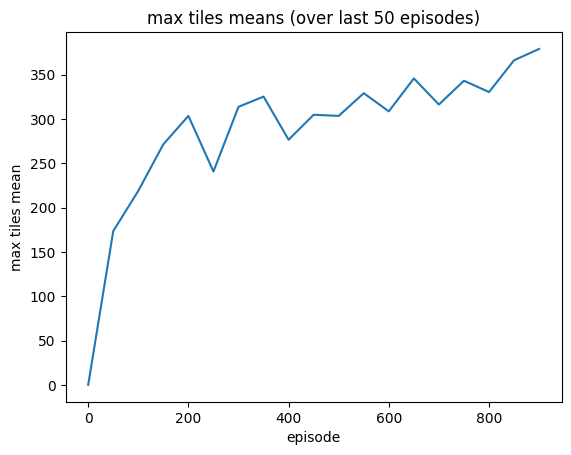

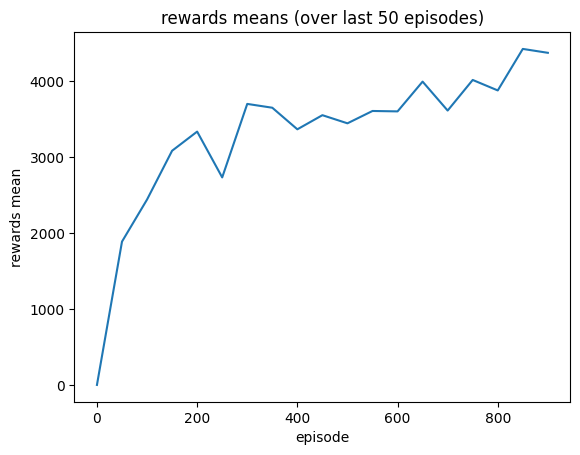

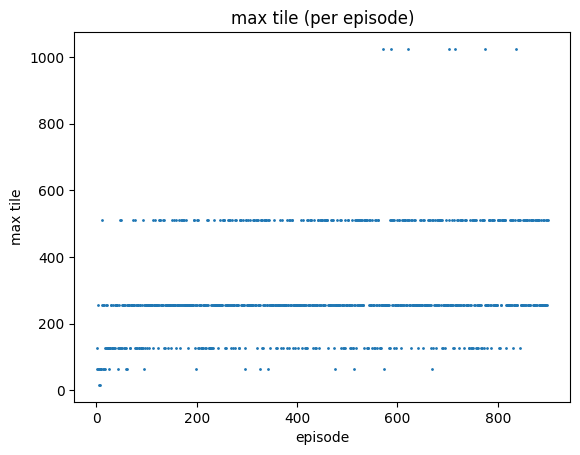

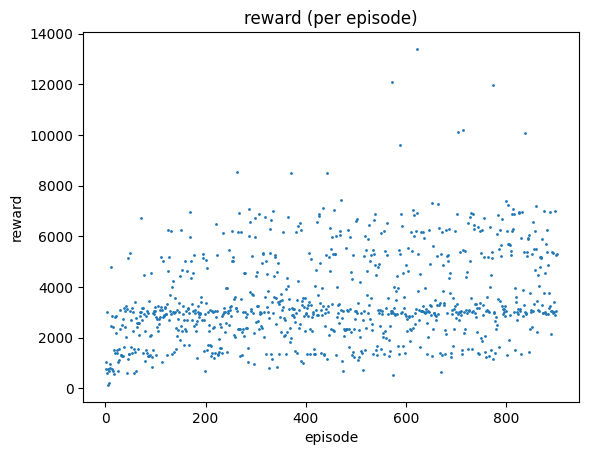

 317772/1000000 - episode: 901, episode steps: 446, episode reward: 4608.0, max tile: 512.0
 318147/1000000 - episode: 902, episode steps: 375, episode reward: 5156.0, max tile: 512.0
 318518/1000000 - episode: 903, episode steps: 371, episode reward: 4840.0, max tile: 512.0
 318841/1000000 - episode: 904, episode steps: 323, episode reward: 1596.0, max tile: 128.0
 319161/1000000 - episode: 905, episode steps: 320, episode reward: 2704.0, max tile: 256.0
 319442/1000000 - episode: 906, episode steps: 281, episode reward: 3228.0, max tile: 256.0
 319689/1000000 - episode: 907, episode steps: 247, episode reward: 2108.0, max tile: 128.0
 319909/1000000 - episode: 908, episode steps: 220, episode reward: 2384.0, max tile: 256.0
 320204/1000000 - episode: 909, episode steps: 295, episode reward: 3260.0, max tile: 256.0
 320655/1000000 - episode: 910, episode steps: 451, episode reward: 3484.0, max tile: 256.0
 321059/1000000 - episode: 911, episode steps: 404, episode reward: 5256.0, max 

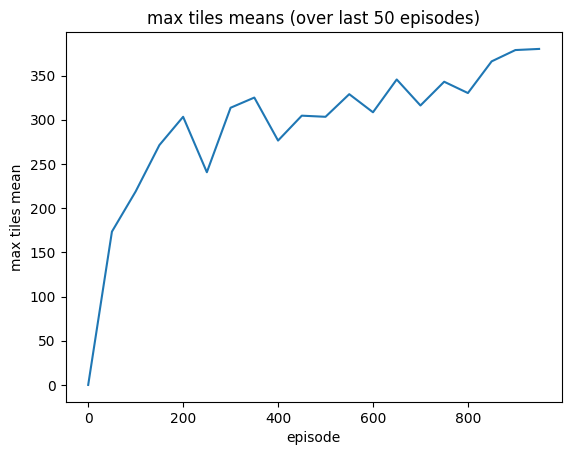

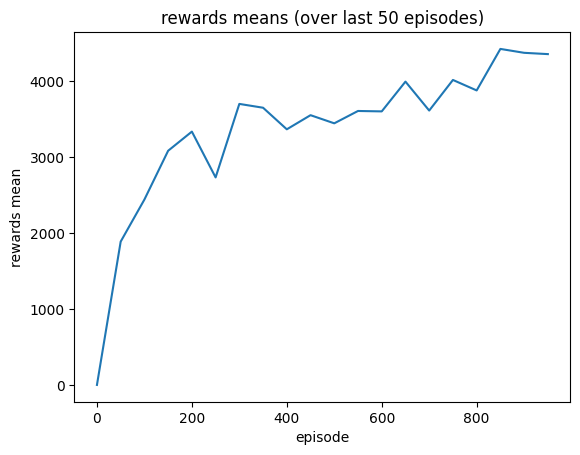

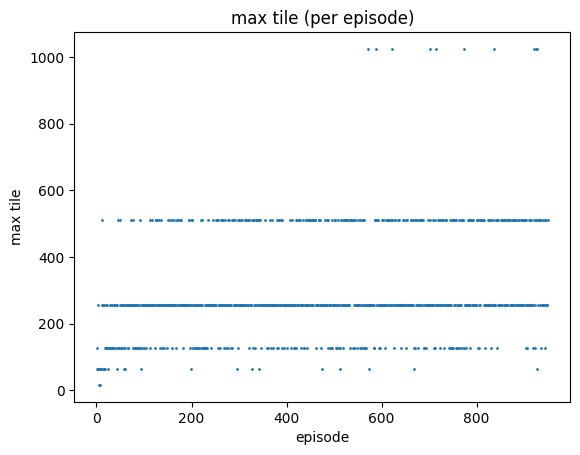

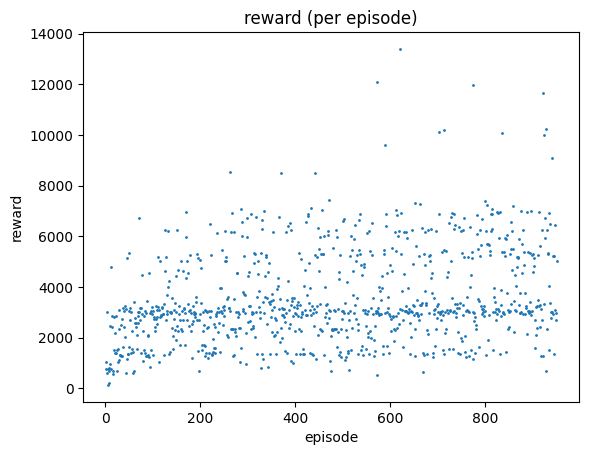

 338262/1000000 - episode: 951, episode steps: 387, episode reward: 3912.0, max tile: 256.0
 338635/1000000 - episode: 952, episode steps: 373, episode reward: 2968.0, max tile: 256.0
 338942/1000000 - episode: 953, episode steps: 307, episode reward: 3092.0, max tile: 256.0
 339239/1000000 - episode: 954, episode steps: 297, episode reward: 2996.0, max tile: 256.0
 339435/1000000 - episode: 955, episode steps: 196, episode reward: 2312.0, max tile: 256.0
 339750/1000000 - episode: 956, episode steps: 315, episode reward: 3152.0, max tile: 256.0
 340103/1000000 - episode: 957, episode steps: 353, episode reward: 2600.0, max tile: 256.0
 340529/1000000 - episode: 958, episode steps: 426, episode reward: 4480.0, max tile: 256.0
 341048/1000000 - episode: 959, episode steps: 519, episode reward: 5392.0, max tile: 512.0
 341501/1000000 - episode: 960, episode steps: 453, episode reward: 3600.0, max tile: 256.0
 342168/1000000 - episode: 961, episode steps: 667, episode reward: 10236.0, max

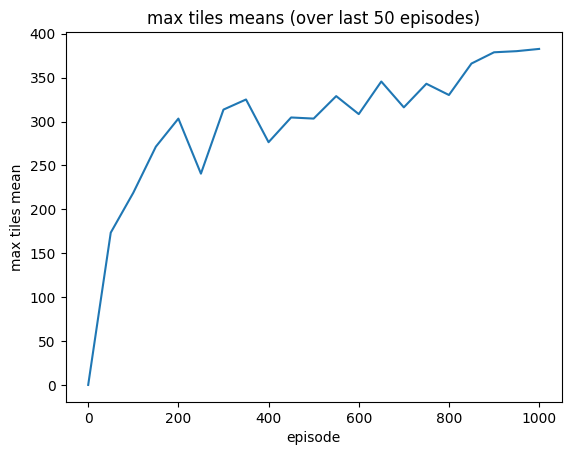

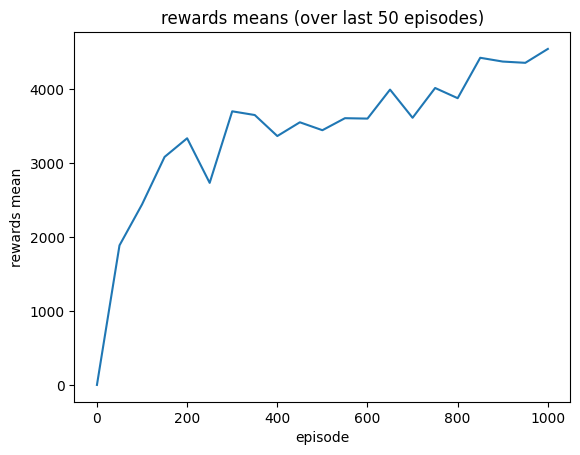

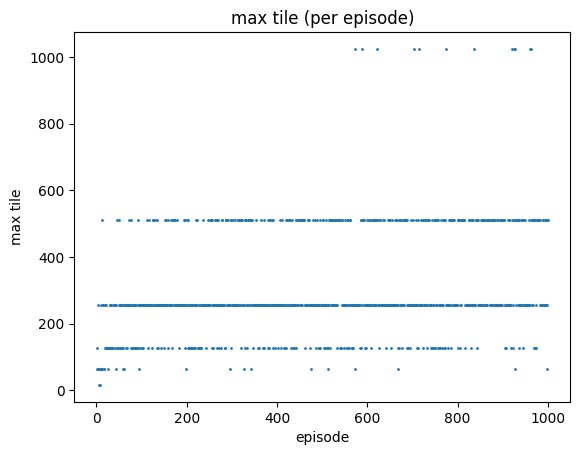

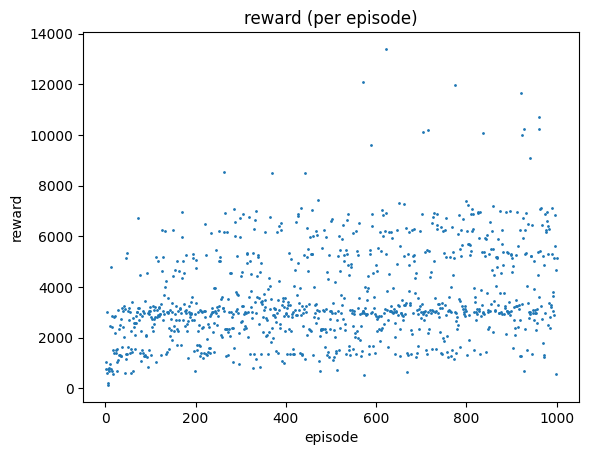

 359488/1000000 - episode: 1001, episode steps: 523, episode reward: 6976.0, max tile: 512.0
 359954/1000000 - episode: 1002, episode steps: 466, episode reward: 5376.0, max tile: 512.0
 360382/1000000 - episode: 1003, episode steps: 428, episode reward: 5280.0, max tile: 512.0
 360676/1000000 - episode: 1004, episode steps: 294, episode reward: 2864.0, max tile: 256.0
 361324/1000000 - episode: 1005, episode steps: 648, episode reward: 6704.0, max tile: 512.0
 361945/1000000 - episode: 1006, episode steps: 621, episode reward: 7088.0, max tile: 512.0
 362461/1000000 - episode: 1007, episode steps: 516, episode reward: 6896.0, max tile: 512.0
 362847/1000000 - episode: 1008, episode steps: 386, episode reward: 5000.0, max tile: 512.0
 363111/1000000 - episode: 1009, episode steps: 264, episode reward: 2204.0, max tile: 256.0
 363742/1000000 - episode: 1010, episode steps: 631, episode reward: 6872.0, max tile: 512.0
 363919/1000000 - episode: 1011, episode steps: 177, episode reward: 2

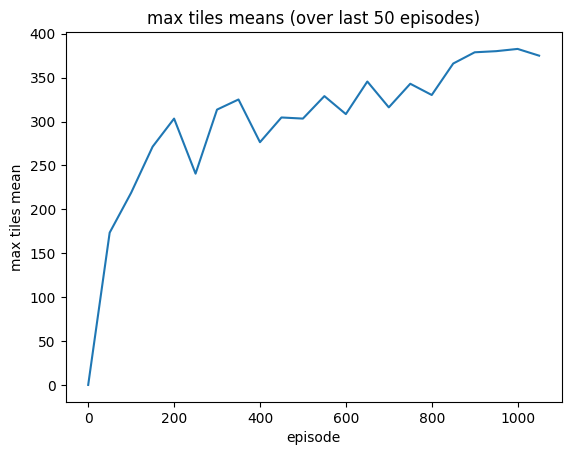

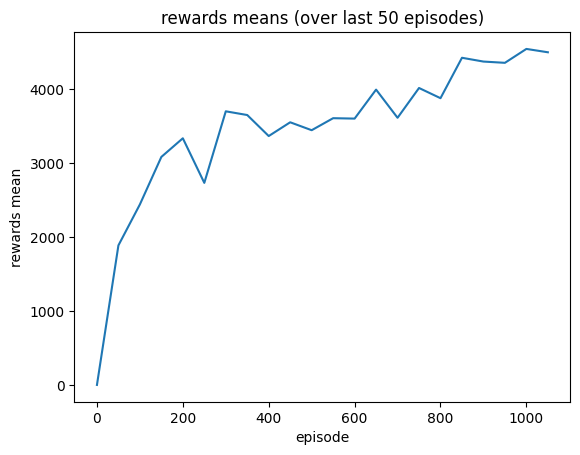

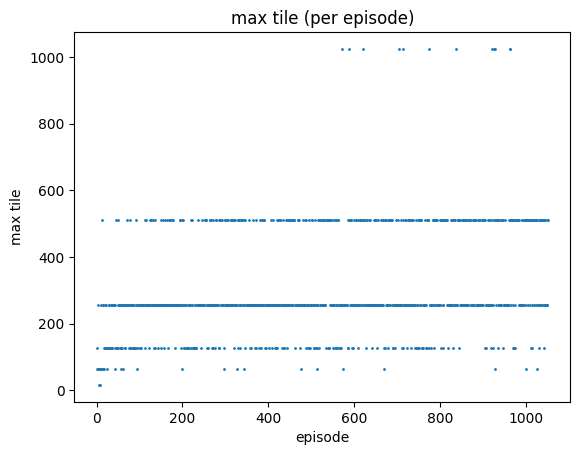

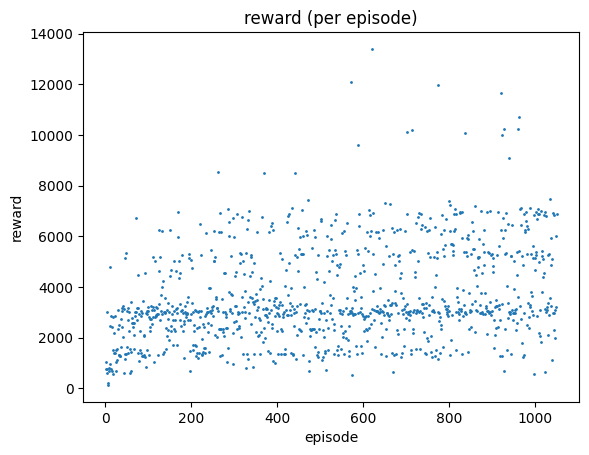

 379367/1000000 - episode: 1051, episode steps: 246, episode reward: 2612.0, max tile: 256.0
 379694/1000000 - episode: 1052, episode steps: 327, episode reward: 3044.0, max tile: 256.0
 379833/1000000 - episode: 1053, episode steps: 139, episode reward: 1260.0, max tile: 128.0
 380138/1000000 - episode: 1054, episode steps: 305, episode reward: 2912.0, max tile: 256.0
 380429/1000000 - episode: 1055, episode steps: 291, episode reward: 2924.0, max tile: 256.0
 380676/1000000 - episode: 1056, episode steps: 247, episode reward: 3044.0, max tile: 256.0
 380921/1000000 - episode: 1057, episode steps: 245, episode reward: 2952.0, max tile: 256.0
 381235/1000000 - episode: 1058, episode steps: 314, episode reward: 4588.0, max tile: 512.0
 381673/1000000 - episode: 1059, episode steps: 438, episode reward: 5544.0, max tile: 512.0
 382394/1000000 - episode: 1060, episode steps: 721, episode reward: 5352.0, max tile: 512.0
 382643/1000000 - episode: 1061, episode steps: 249, episode reward: 3

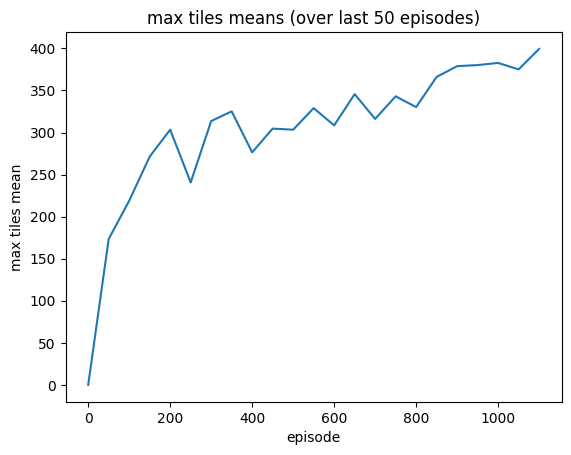

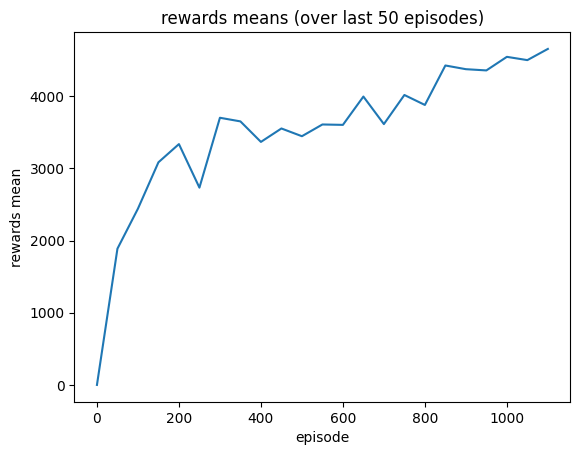

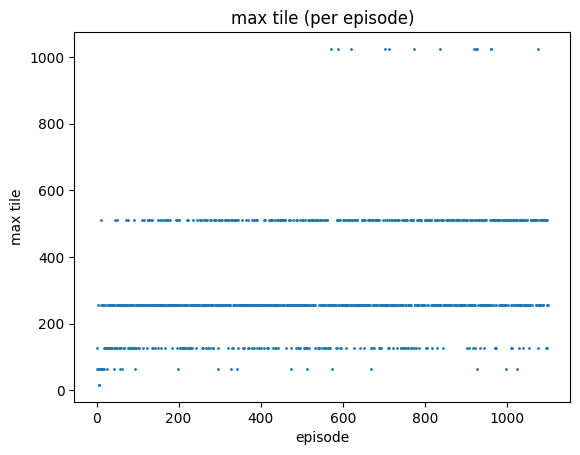

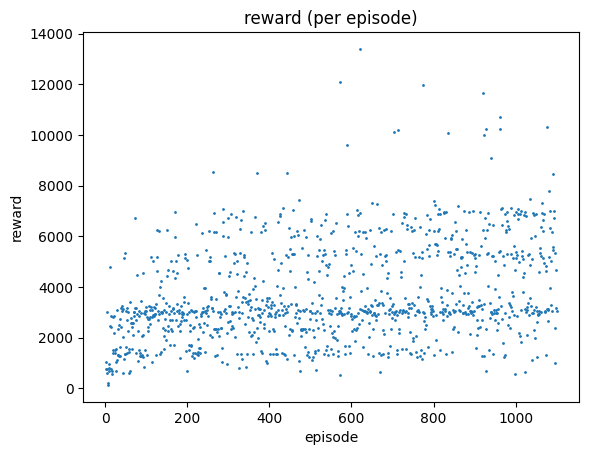

 400897/1000000 - episode: 1101, episode steps: 218, episode reward: 1360.0, max tile: 128.0
 401375/1000000 - episode: 1102, episode steps: 478, episode reward: 5548.0, max tile: 512.0
 402085/1000000 - episode: 1103, episode steps: 710, episode reward: 7012.0, max tile: 512.0
 402397/1000000 - episode: 1104, episode steps: 312, episode reward: 3024.0, max tile: 256.0
 402671/1000000 - episode: 1105, episode steps: 274, episode reward: 1484.0, max tile: 128.0
 403072/1000000 - episode: 1106, episode steps: 401, episode reward: 5336.0, max tile: 512.0
 403625/1000000 - episode: 1107, episode steps: 553, episode reward: 5812.0, max tile: 512.0
 403944/1000000 - episode: 1108, episode steps: 319, episode reward: 2512.0, max tile: 256.0
 404281/1000000 - episode: 1109, episode steps: 337, episode reward: 3488.0, max tile: 256.0
 404734/1000000 - episode: 1110, episode steps: 453, episode reward: 2828.0, max tile: 256.0
 405120/1000000 - episode: 1111, episode steps: 386, episode reward: 5

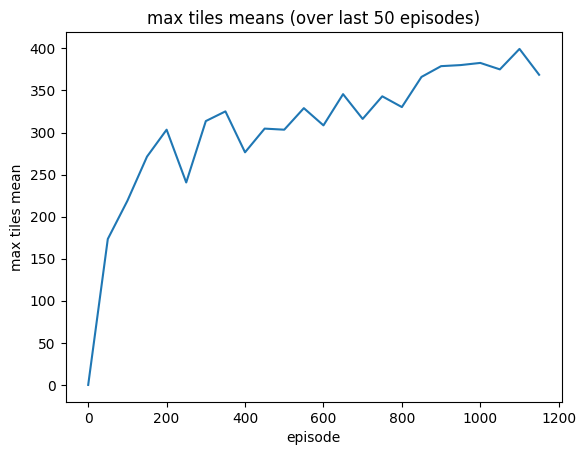

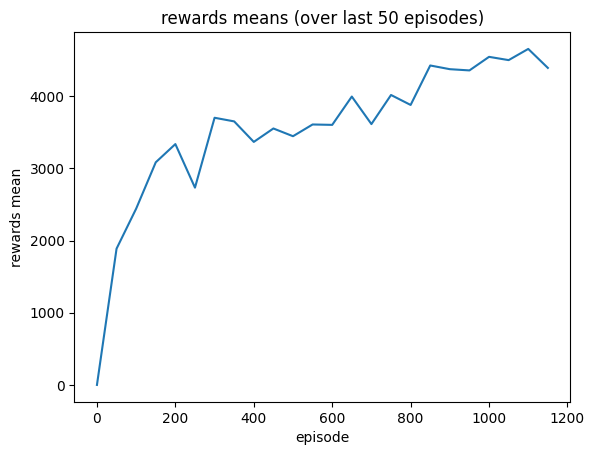

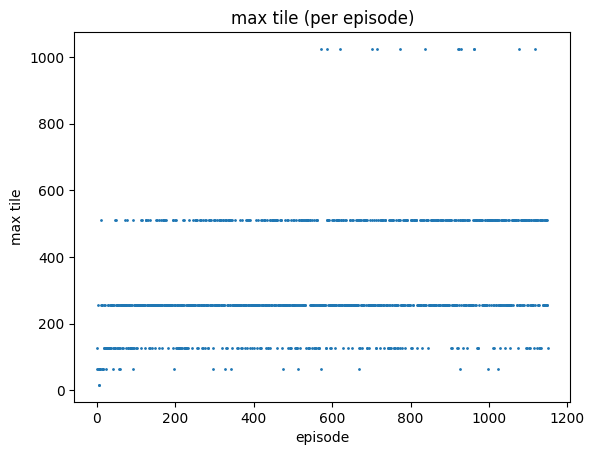

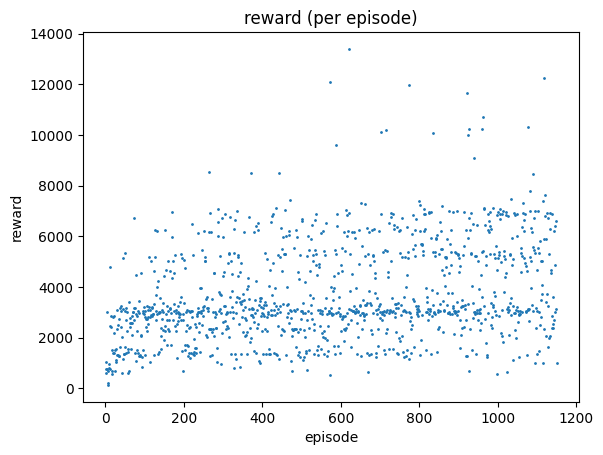

 421351/1000000 - episode: 1151, episode steps: 170, episode reward: 1596.0, max tile: 128.0
 421529/1000000 - episode: 1152, episode steps: 178, episode reward: 1380.0, max tile: 128.0
 421746/1000000 - episode: 1153, episode steps: 217, episode reward: 2384.0, max tile: 256.0
 422068/1000000 - episode: 1154, episode steps: 322, episode reward: 3052.0, max tile: 256.0
 422244/1000000 - episode: 1155, episode steps: 176, episode reward: 1604.0, max tile: 128.0
 422599/1000000 - episode: 1156, episode steps: 355, episode reward: 3608.0, max tile: 256.0
 423010/1000000 - episode: 1157, episode steps: 411, episode reward: 4880.0, max tile: 512.0
 423549/1000000 - episode: 1158, episode steps: 539, episode reward: 5412.0, max tile: 512.0
 423871/1000000 - episode: 1159, episode steps: 322, episode reward: 3068.0, max tile: 256.0
 424343/1000000 - episode: 1160, episode steps: 472, episode reward: 4620.0, max tile: 512.0
 425424/1000000 - episode: 1161, episode steps: 1081, episode reward: 

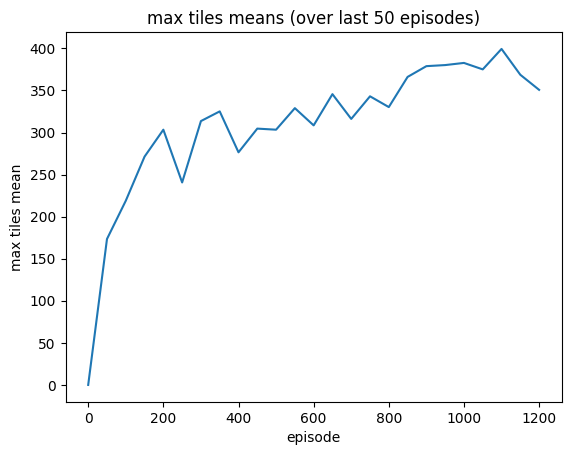

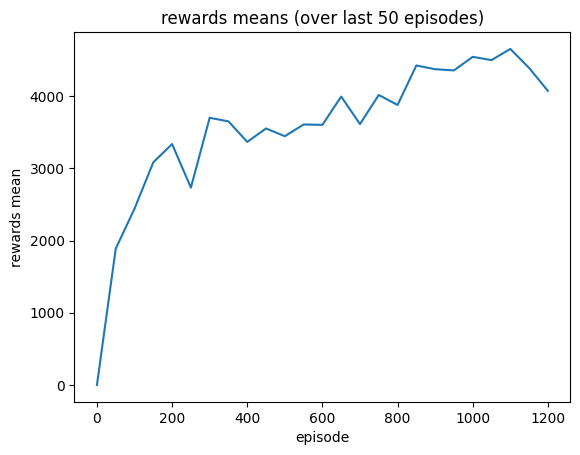

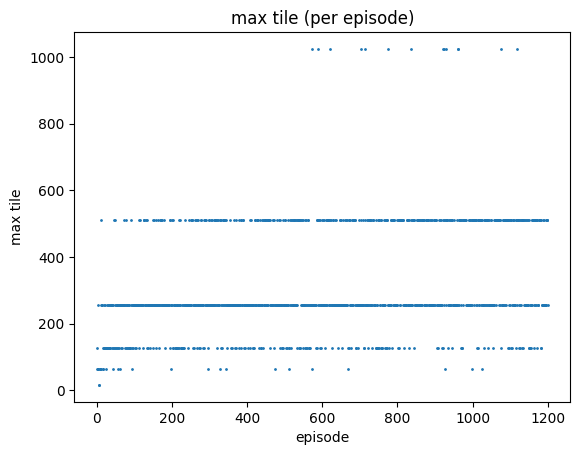

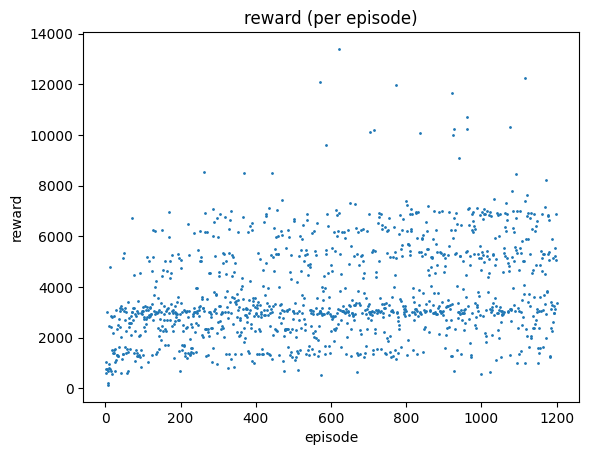

 441417/1000000 - episode: 1201, episode steps: 448, episode reward: 5248.0, max tile: 512.0
 441623/1000000 - episode: 1202, episode steps: 206, episode reward: 2644.0, max tile: 256.0
 442049/1000000 - episode: 1203, episode steps: 426, episode reward: 5556.0, max tile: 512.0
 442372/1000000 - episode: 1204, episode steps: 323, episode reward: 4728.0, max tile: 512.0
 442783/1000000 - episode: 1205, episode steps: 411, episode reward: 4016.0, max tile: 256.0
 443019/1000000 - episode: 1206, episode steps: 236, episode reward: 2932.0, max tile: 256.0
 443214/1000000 - episode: 1207, episode steps: 195, episode reward: 1688.0, max tile: 128.0
 444141/1000000 - episode: 1208, episode steps: 927, episode reward: 7504.0, max tile: 512.0
 444446/1000000 - episode: 1209, episode steps: 305, episode reward: 2708.0, max tile: 256.0
 444944/1000000 - episode: 1210, episode steps: 498, episode reward: 5892.0, max tile: 512.0
 445245/1000000 - episode: 1211, episode steps: 301, episode reward: 2

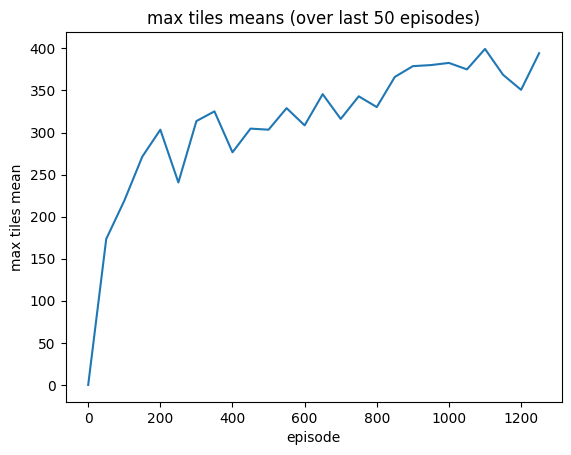

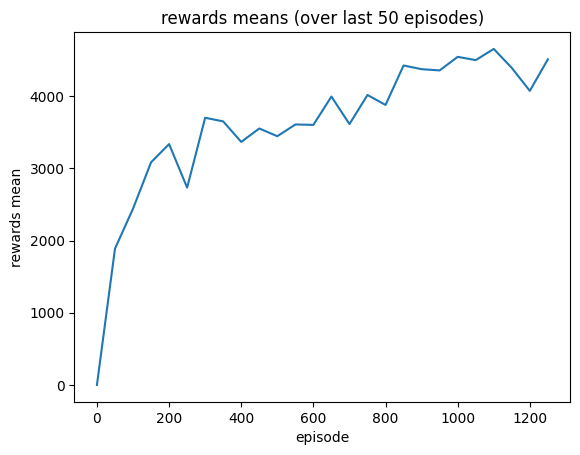

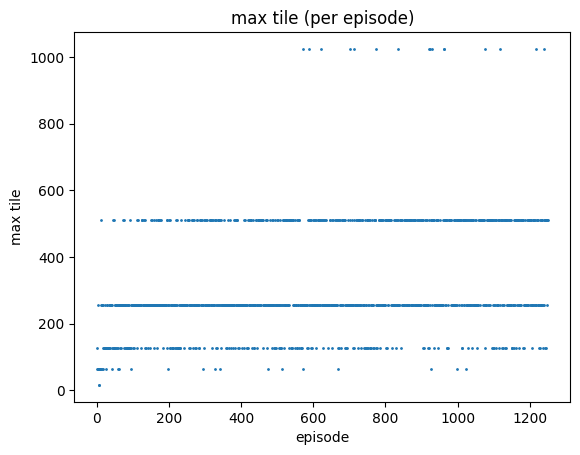

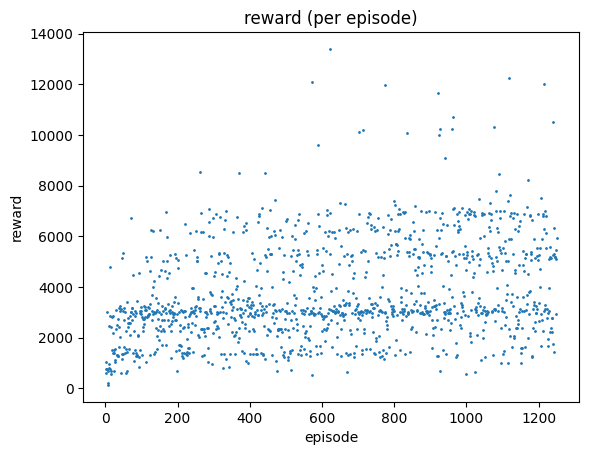

 461816/1000000 - episode: 1251, episode steps: 590, episode reward: 7880.0, max tile: 512.0
 462101/1000000 - episode: 1252, episode steps: 285, episode reward: 2304.0, max tile: 256.0
 462347/1000000 - episode: 1253, episode steps: 246, episode reward: 2668.0, max tile: 256.0
 462805/1000000 - episode: 1254, episode steps: 458, episode reward: 3192.0, max tile: 256.0
 463301/1000000 - episode: 1255, episode steps: 496, episode reward: 6164.0, max tile: 512.0
 463591/1000000 - episode: 1256, episode steps: 290, episode reward: 2936.0, max tile: 256.0
 464045/1000000 - episode: 1257, episode steps: 454, episode reward: 6720.0, max tile: 512.0
 464329/1000000 - episode: 1258, episode steps: 284, episode reward: 2968.0, max tile: 256.0
 464740/1000000 - episode: 1259, episode steps: 411, episode reward: 6068.0, max tile: 512.0
 465053/1000000 - episode: 1260, episode steps: 313, episode reward: 2992.0, max tile: 256.0
 465546/1000000 - episode: 1261, episode steps: 493, episode reward: 3

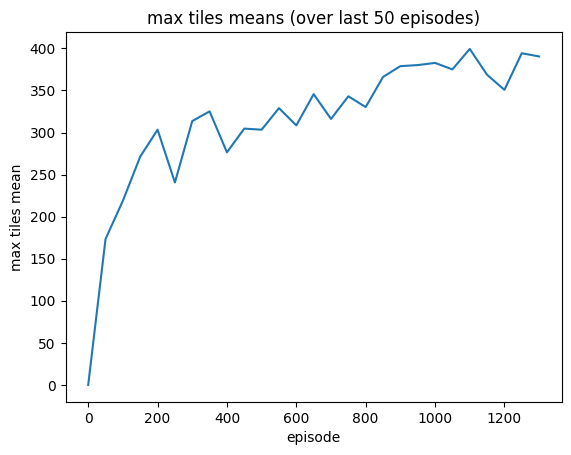

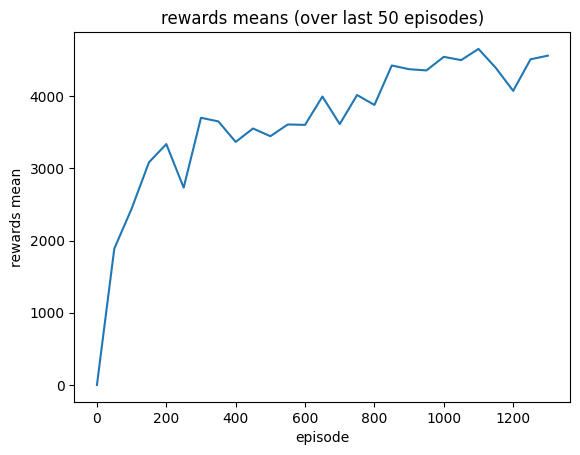

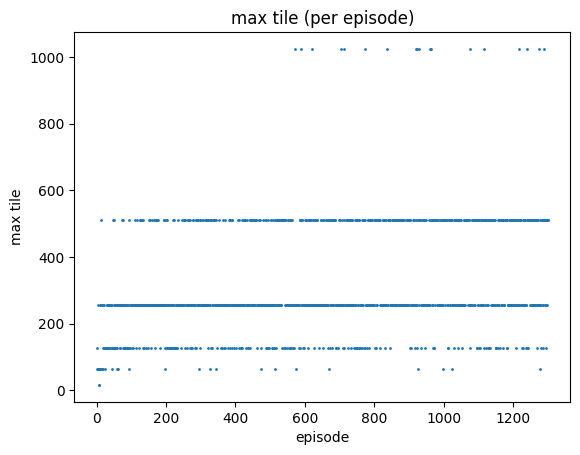

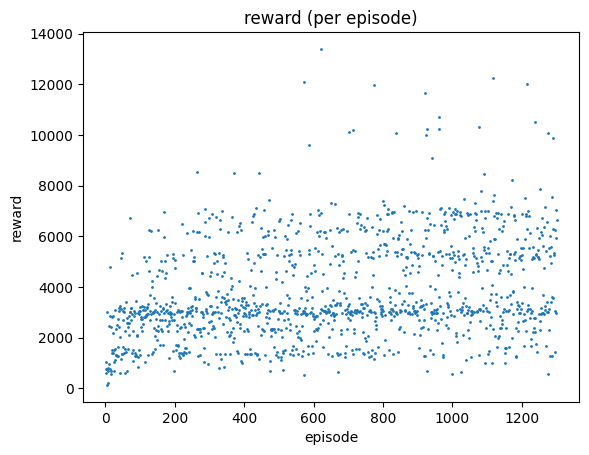

 481919/1000000 - episode: 1301, episode steps: 454, episode reward: 6132.0, max tile: 512.0
 482112/1000000 - episode: 1302, episode steps: 193, episode reward: 1408.0, max tile: 128.0
 482456/1000000 - episode: 1303, episode steps: 344, episode reward: 3180.0, max tile: 256.0
 483039/1000000 - episode: 1304, episode steps: 583, episode reward: 7568.0, max tile: 512.0
 483618/1000000 - episode: 1305, episode steps: 579, episode reward: 6860.0, max tile: 512.0
 484035/1000000 - episode: 1306, episode steps: 417, episode reward: 3356.0, max tile: 256.0
 484429/1000000 - episode: 1307, episode steps: 394, episode reward: 5956.0, max tile: 512.0
 484922/1000000 - episode: 1308, episode steps: 493, episode reward: 6888.0, max tile: 512.0
 485106/1000000 - episode: 1309, episode steps: 184, episode reward: 1604.0, max tile: 128.0
 485424/1000000 - episode: 1310, episode steps: 318, episode reward: 3972.0, max tile: 256.0
 485782/1000000 - episode: 1311, episode steps: 358, episode reward: 3

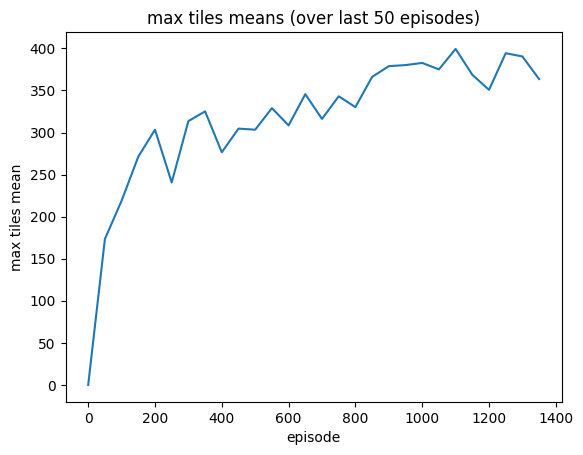

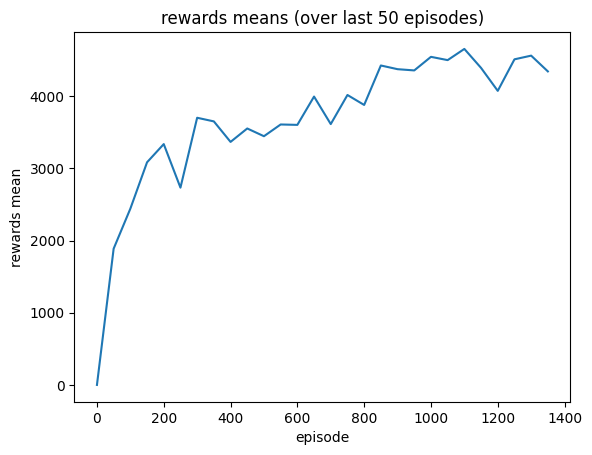

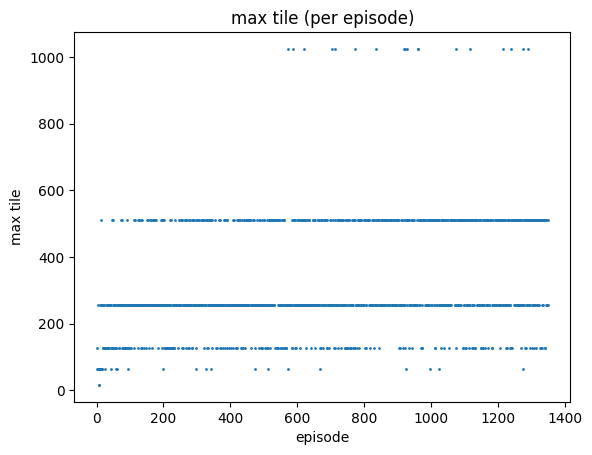

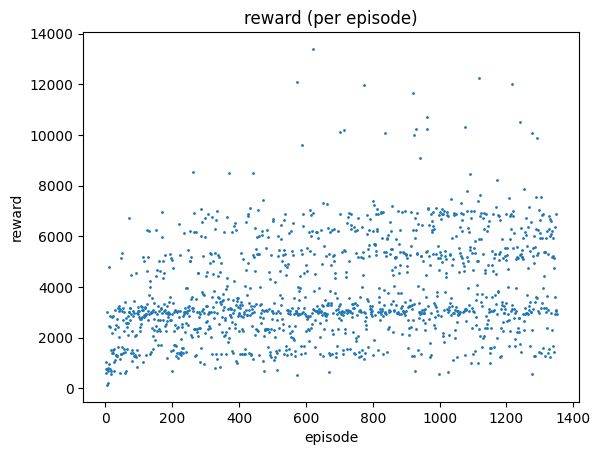

 501510/1000000 - episode: 1351, episode steps: 564, episode reward: 5900.0, max tile: 512.0
 502276/1000000 - episode: 1352, episode steps: 766, episode reward: 7004.0, max tile: 512.0
 502793/1000000 - episode: 1353, episode steps: 517, episode reward: 6844.0, max tile: 512.0
 503158/1000000 - episode: 1354, episode steps: 365, episode reward: 5496.0, max tile: 512.0
 503403/1000000 - episode: 1355, episode steps: 245, episode reward: 3068.0, max tile: 256.0
 503688/1000000 - episode: 1356, episode steps: 285, episode reward: 3112.0, max tile: 256.0
 503893/1000000 - episode: 1357, episode steps: 205, episode reward: 2656.0, max tile: 256.0
 504203/1000000 - episode: 1358, episode steps: 310, episode reward: 3512.0, max tile: 256.0
 504697/1000000 - episode: 1359, episode steps: 494, episode reward: 6916.0, max tile: 512.0
 505193/1000000 - episode: 1360, episode steps: 496, episode reward: 6468.0, max tile: 512.0
 505912/1000000 - episode: 1361, episode steps: 719, episode reward: 6

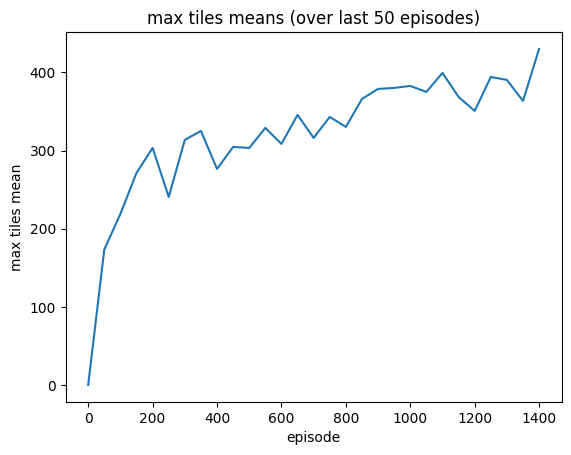

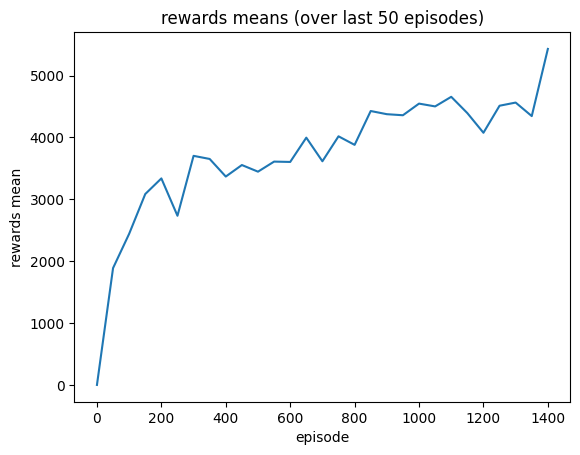

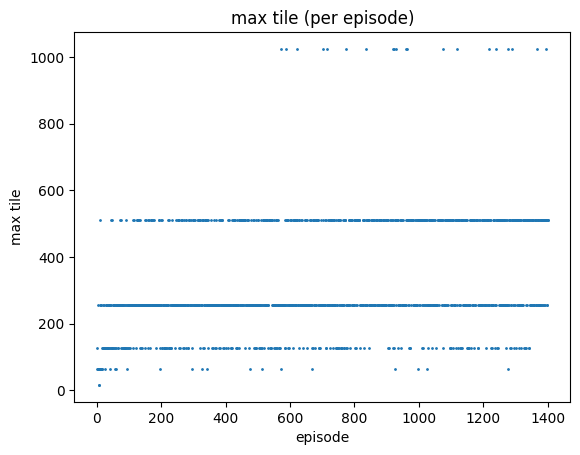

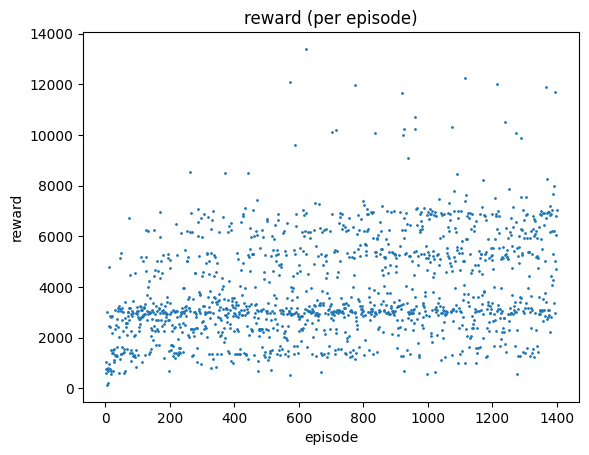

 524494/1000000 - episode: 1401, episode steps: 541, episode reward: 7048.0, max tile: 512.0
 525004/1000000 - episode: 1402, episode steps: 510, episode reward: 6192.0, max tile: 512.0
 525289/1000000 - episode: 1403, episode steps: 285, episode reward: 3096.0, max tile: 256.0
 525630/1000000 - episode: 1404, episode steps: 341, episode reward: 5192.0, max tile: 512.0
 526081/1000000 - episode: 1405, episode steps: 451, episode reward: 5196.0, max tile: 512.0
 526519/1000000 - episode: 1406, episode steps: 438, episode reward: 2656.0, max tile: 256.0
 526987/1000000 - episode: 1407, episode steps: 468, episode reward: 6672.0, max tile: 512.0
 527429/1000000 - episode: 1408, episode steps: 442, episode reward: 6204.0, max tile: 512.0
 527685/1000000 - episode: 1409, episode steps: 256, episode reward: 3376.0, max tile: 256.0
 528198/1000000 - episode: 1410, episode steps: 513, episode reward: 6944.0, max tile: 512.0
 528548/1000000 - episode: 1411, episode steps: 350, episode reward: 5

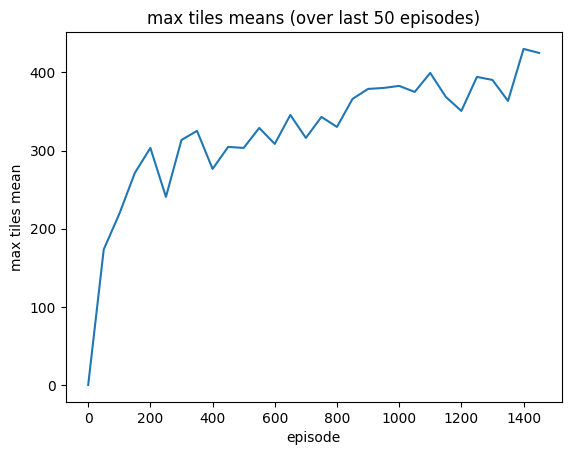

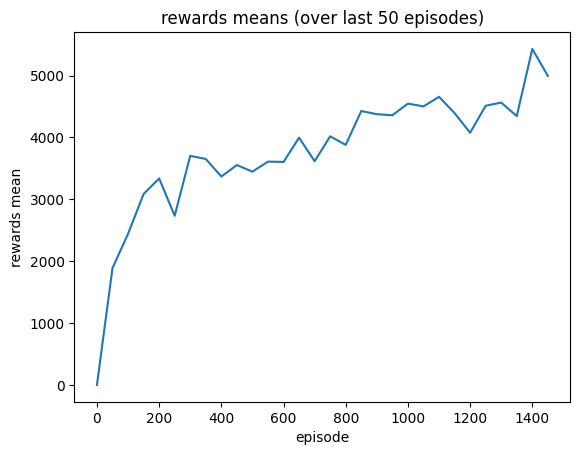

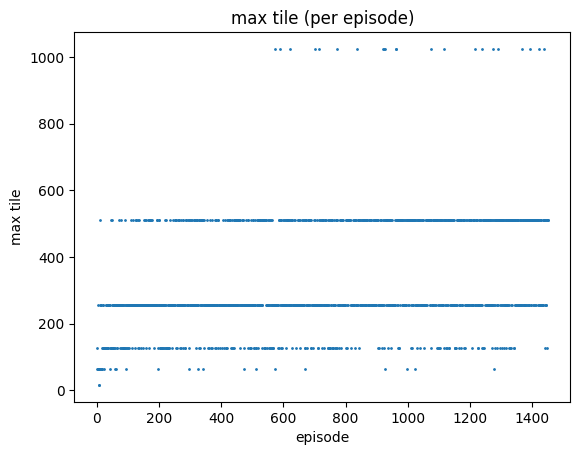

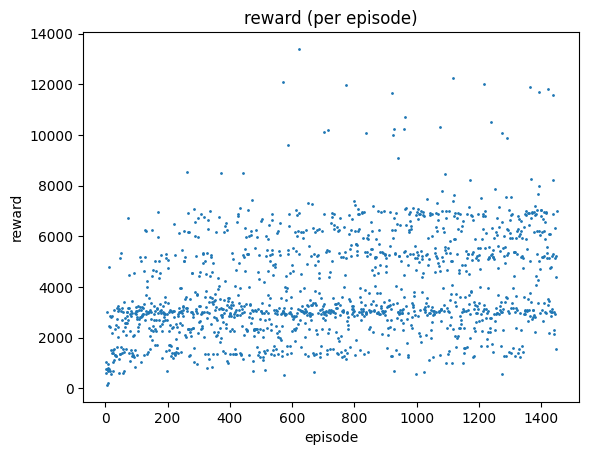

 545653/1000000 - episode: 1451, episode steps: 370, episode reward: 5520.0, max tile: 512.0
 546179/1000000 - episode: 1452, episode steps: 526, episode reward: 6996.0, max tile: 512.0
 546657/1000000 - episode: 1453, episode steps: 478, episode reward: 6500.0, max tile: 512.0
 547064/1000000 - episode: 1454, episode steps: 407, episode reward: 5136.0, max tile: 512.0
 547256/1000000 - episode: 1455, episode steps: 192, episode reward: 2384.0, max tile: 256.0
 547752/1000000 - episode: 1456, episode steps: 496, episode reward: 5436.0, max tile: 512.0
 548180/1000000 - episode: 1457, episode steps: 428, episode reward: 5280.0, max tile: 512.0
 548498/1000000 - episode: 1458, episode steps: 318, episode reward: 3284.0, max tile: 256.0
 548783/1000000 - episode: 1459, episode steps: 285, episode reward: 3020.0, max tile: 256.0
 549270/1000000 - episode: 1460, episode steps: 487, episode reward: 6900.0, max tile: 512.0
 549563/1000000 - episode: 1461, episode steps: 293, episode reward: 2

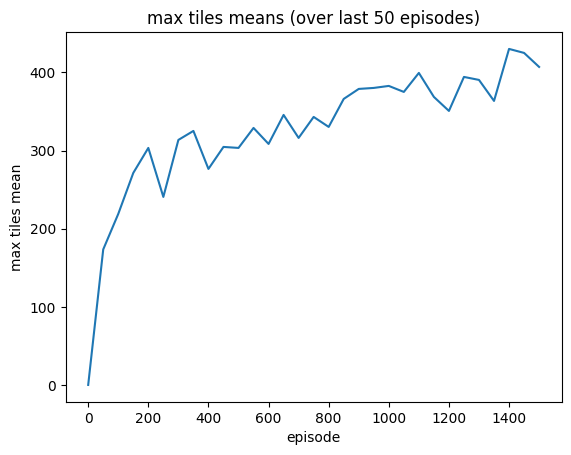

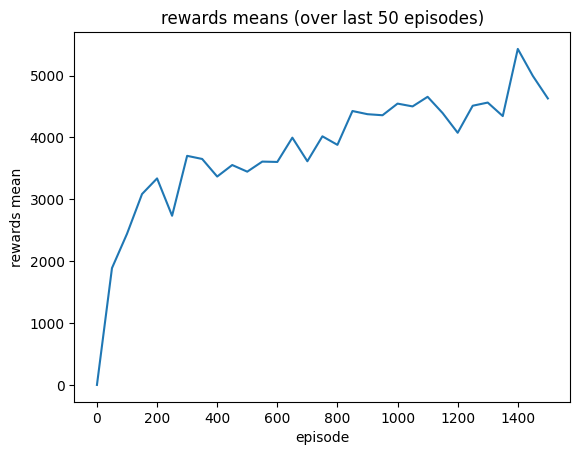

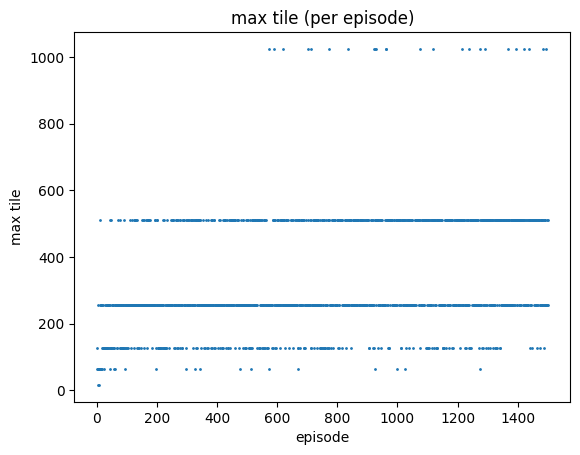

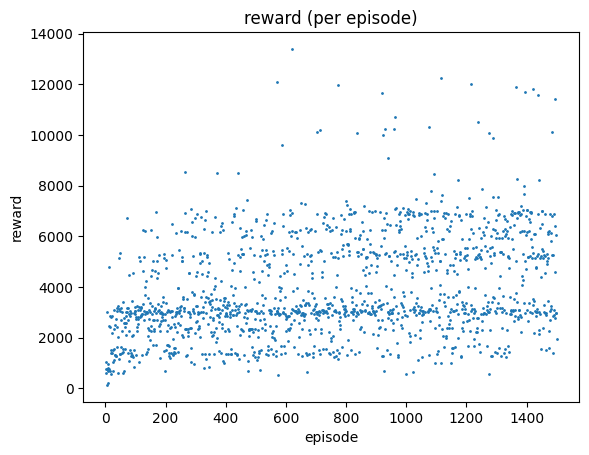

 565008/1000000 - episode: 1501, episode steps: 354, episode reward: 5452.0, max tile: 512.0
 565374/1000000 - episode: 1502, episode steps: 366, episode reward: 3772.0, max tile: 256.0
 565756/1000000 - episode: 1503, episode steps: 382, episode reward: 5336.0, max tile: 512.0
 566040/1000000 - episode: 1504, episode steps: 284, episode reward: 2940.0, max tile: 256.0
 566492/1000000 - episode: 1505, episode steps: 452, episode reward: 6172.0, max tile: 512.0
 566877/1000000 - episode: 1506, episode steps: 385, episode reward: 5120.0, max tile: 512.0
 567346/1000000 - episode: 1507, episode steps: 469, episode reward: 6220.0, max tile: 512.0
 567782/1000000 - episode: 1508, episode steps: 436, episode reward: 5468.0, max tile: 512.0
 568304/1000000 - episode: 1509, episode steps: 522, episode reward: 7020.0, max tile: 512.0
 568510/1000000 - episode: 1510, episode steps: 206, episode reward: 2472.0, max tile: 256.0
 569064/1000000 - episode: 1511, episode steps: 554, episode reward: 5

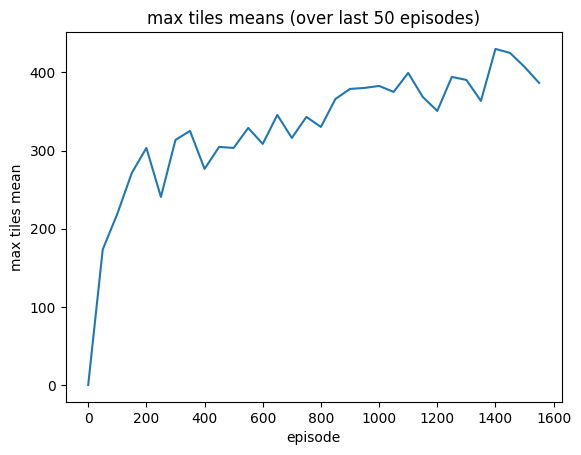

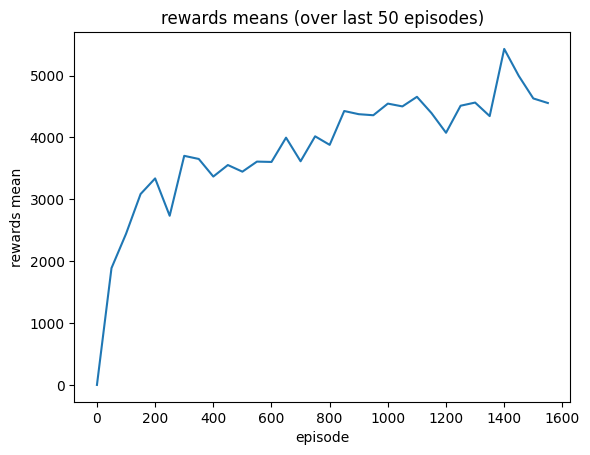

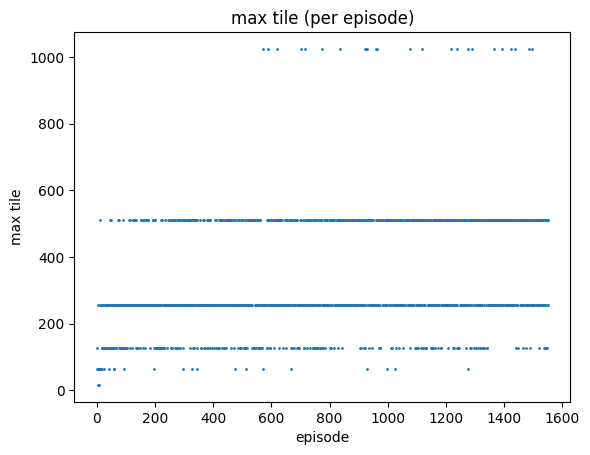

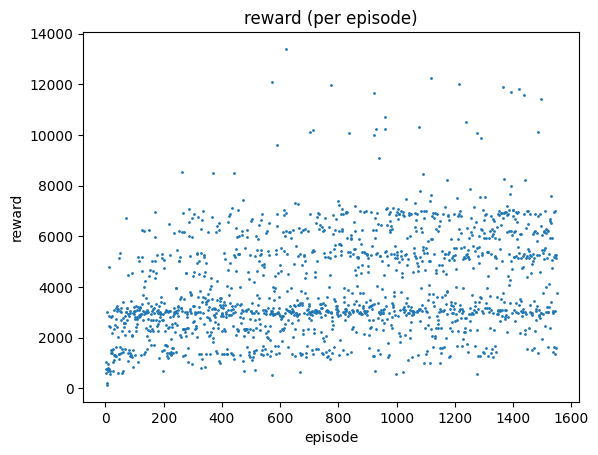

 584487/1000000 - episode: 1551, episode steps: 393, episode reward: 4884.0, max tile: 512.0
 585081/1000000 - episode: 1552, episode steps: 594, episode reward: 5628.0, max tile: 512.0
 585307/1000000 - episode: 1553, episode steps: 226, episode reward: 2980.0, max tile: 256.0
 585858/1000000 - episode: 1554, episode steps: 551, episode reward: 6684.0, max tile: 512.0
 586322/1000000 - episode: 1555, episode steps: 464, episode reward: 3844.0, max tile: 256.0
 586815/1000000 - episode: 1556, episode steps: 493, episode reward: 7000.0, max tile: 512.0
 586964/1000000 - episode: 1557, episode steps: 149, episode reward: 1624.0, max tile: 128.0
 587464/1000000 - episode: 1558, episode steps: 500, episode reward: 8364.0, max tile: 512.0
 587763/1000000 - episode: 1559, episode steps: 299, episode reward: 3140.0, max tile: 256.0
 588163/1000000 - episode: 1560, episode steps: 400, episode reward: 5480.0, max tile: 512.0
 588467/1000000 - episode: 1561, episode steps: 304, episode reward: 3

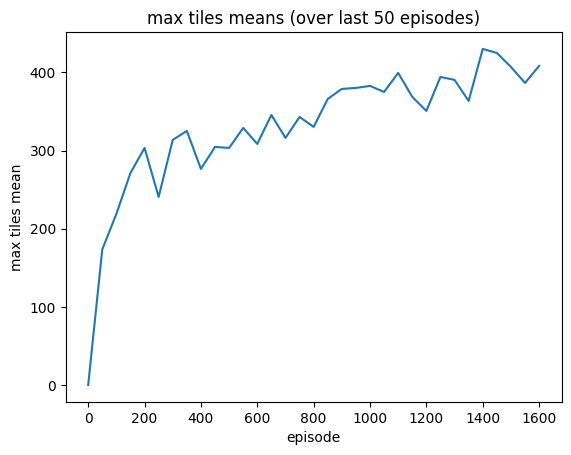

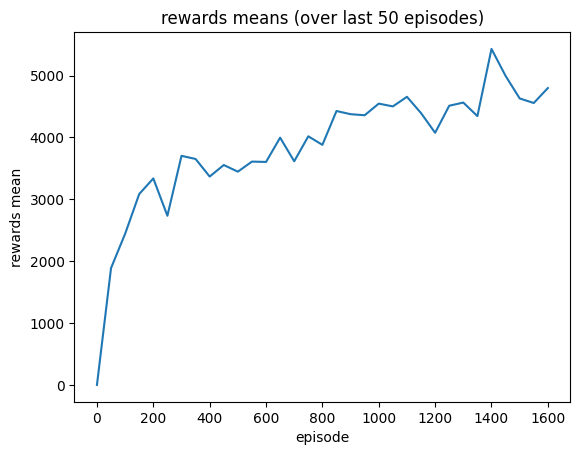

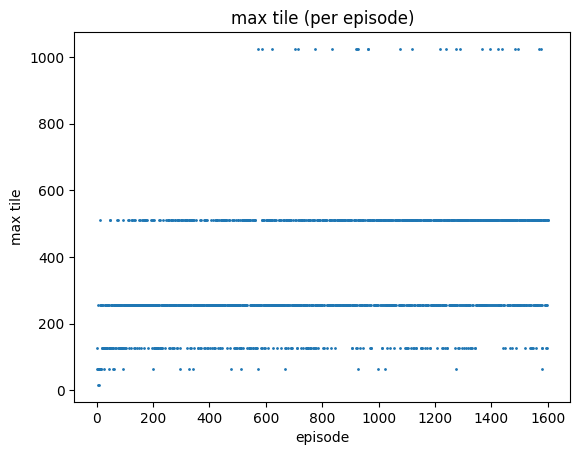

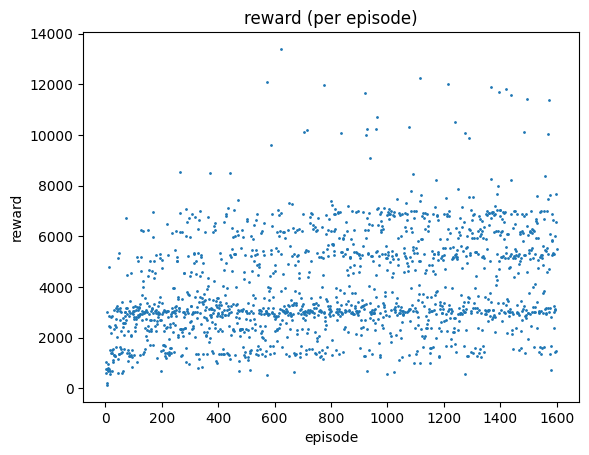

 604798/1000000 - episode: 1601, episode steps: 321, episode reward: 2988.0, max tile: 256.0
 605356/1000000 - episode: 1602, episode steps: 558, episode reward: 5280.0, max tile: 512.0
 606172/1000000 - episode: 1603, episode steps: 816, episode reward: 11672.0, max tile: 1024.0
 606588/1000000 - episode: 1604, episode steps: 416, episode reward: 5196.0, max tile: 512.0
 606676/1000000 - episode: 1605, episode steps: 88, episode reward: 692.0, max tile: 64.0
 607467/1000000 - episode: 1606, episode steps: 791, episode reward: 5420.0, max tile: 512.0
 608319/1000000 - episode: 1607, episode steps: 852, episode reward: 10760.0, max tile: 1024.0
 608564/1000000 - episode: 1608, episode steps: 245, episode reward: 3064.0, max tile: 256.0
 608846/1000000 - episode: 1609, episode steps: 282, episode reward: 3020.0, max tile: 256.0
 609092/1000000 - episode: 1610, episode steps: 246, episode reward: 2992.0, max tile: 256.0
 609661/1000000 - episode: 1611, episode steps: 569, episode reward: 

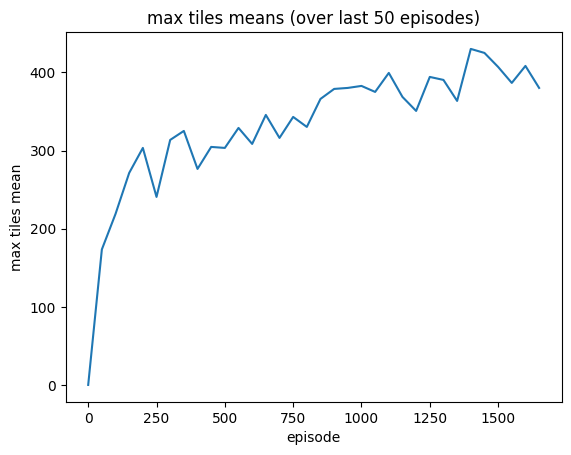

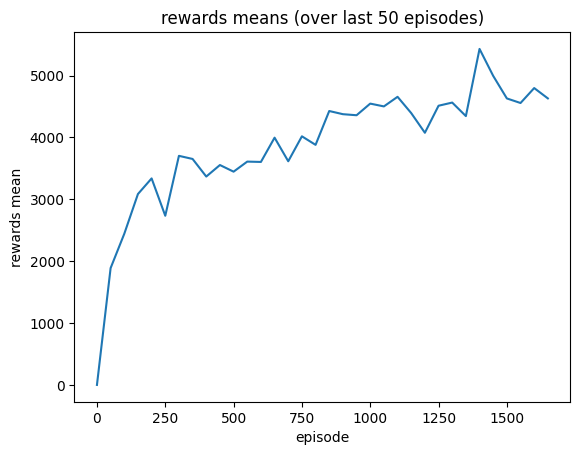

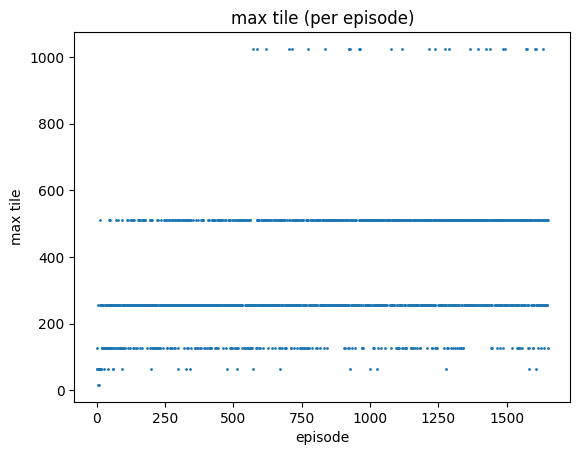

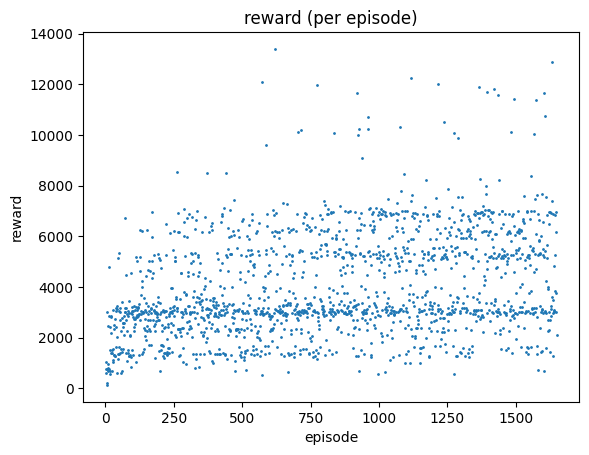

 625998/1000000 - episode: 1651, episode steps: 545, episode reward: 6880.0, max tile: 512.0
 626303/1000000 - episode: 1652, episode steps: 305, episode reward: 3080.0, max tile: 256.0
 626915/1000000 - episode: 1653, episode steps: 612, episode reward: 6880.0, max tile: 512.0
 627251/1000000 - episode: 1654, episode steps: 336, episode reward: 3144.0, max tile: 256.0
 627536/1000000 - episode: 1655, episode steps: 285, episode reward: 2976.0, max tile: 256.0
 627678/1000000 - episode: 1656, episode steps: 142, episode reward: 1364.0, max tile: 128.0
 628123/1000000 - episode: 1657, episode steps: 445, episode reward: 3304.0, max tile: 256.0
 628679/1000000 - episode: 1658, episode steps: 556, episode reward: 6792.0, max tile: 512.0
 628849/1000000 - episode: 1659, episode steps: 170, episode reward: 1592.0, max tile: 128.0
 629127/1000000 - episode: 1660, episode steps: 278, episode reward: 3004.0, max tile: 256.0
 629780/1000000 - episode: 1661, episode steps: 653, episode reward: 5

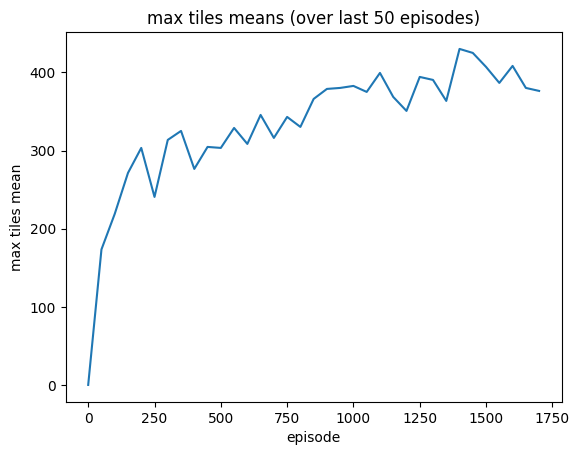

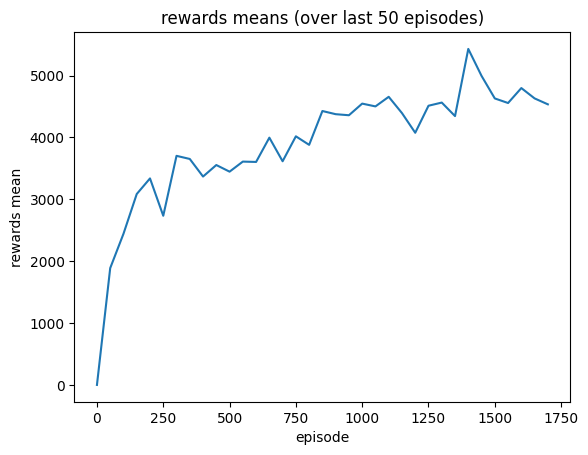

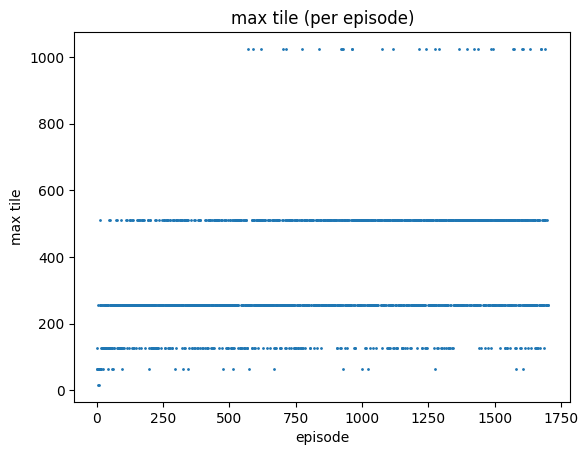

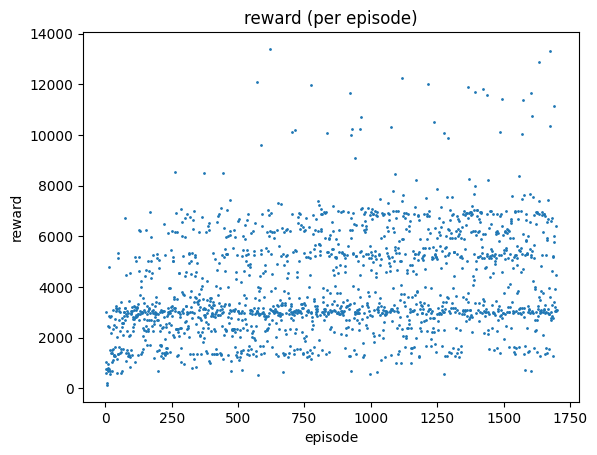

 646561/1000000 - episode: 1701, episode steps: 527, episode reward: 6804.0, max tile: 512.0
 646969/1000000 - episode: 1702, episode steps: 408, episode reward: 5200.0, max tile: 512.0
 647441/1000000 - episode: 1703, episode steps: 472, episode reward: 6300.0, max tile: 512.0
 647925/1000000 - episode: 1704, episode steps: 484, episode reward: 4020.0, max tile: 256.0
 648271/1000000 - episode: 1705, episode steps: 346, episode reward: 3644.0, max tile: 256.0
 648744/1000000 - episode: 1706, episode steps: 473, episode reward: 6920.0, max tile: 512.0
 649221/1000000 - episode: 1707, episode steps: 477, episode reward: 6568.0, max tile: 512.0
 649726/1000000 - episode: 1708, episode steps: 505, episode reward: 6896.0, max tile: 512.0
 650230/1000000 - episode: 1709, episode steps: 504, episode reward: 5080.0, max tile: 512.0
 650961/1000000 - episode: 1710, episode steps: 731, episode reward: 6200.0, max tile: 512.0
 651236/1000000 - episode: 1711, episode steps: 275, episode reward: 2

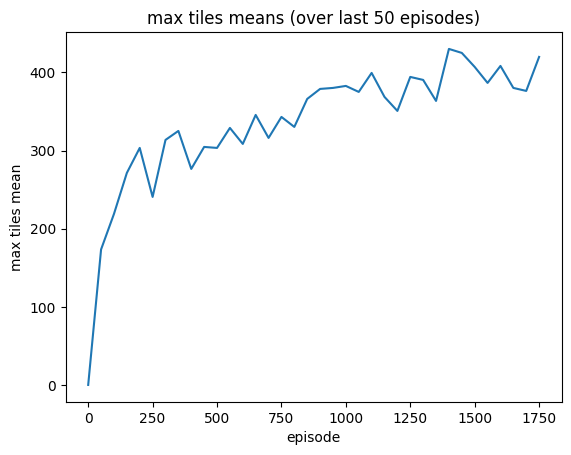

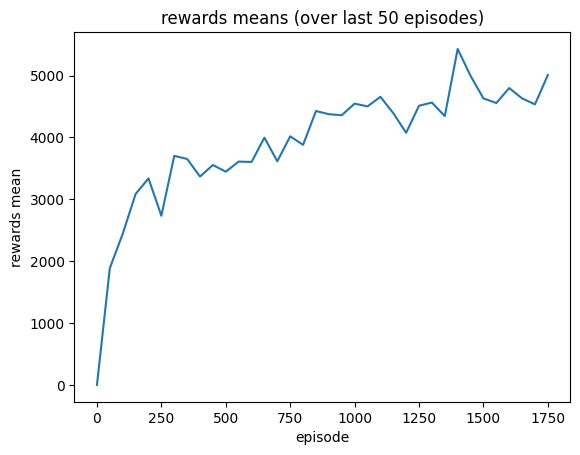

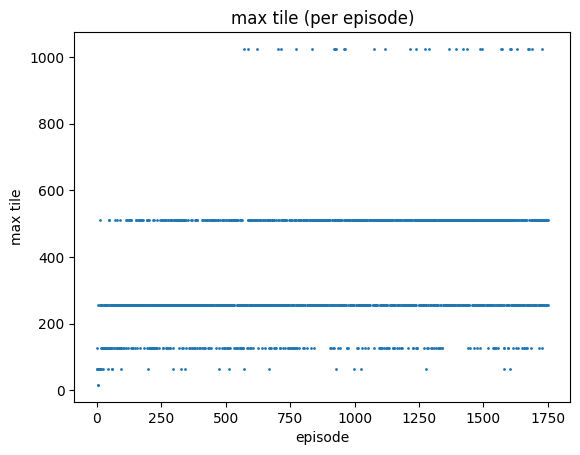

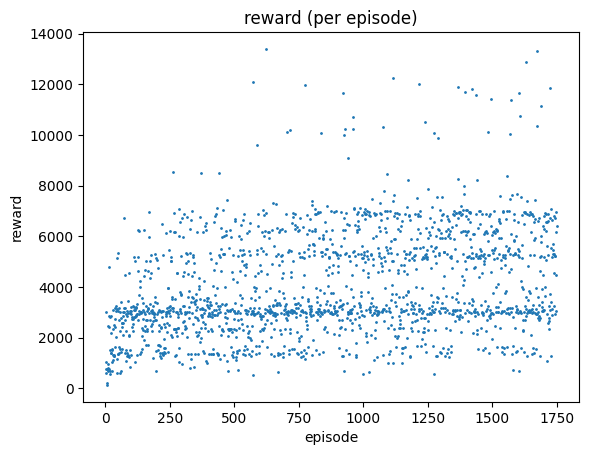

 668190/1000000 - episode: 1751, episode steps: 535, episode reward: 7008.0, max tile: 512.0
 668615/1000000 - episode: 1752, episode steps: 425, episode reward: 6732.0, max tile: 512.0
 669169/1000000 - episode: 1753, episode steps: 554, episode reward: 5492.0, max tile: 512.0
 669619/1000000 - episode: 1754, episode steps: 450, episode reward: 3160.0, max tile: 256.0
 669789/1000000 - episode: 1755, episode steps: 170, episode reward: 1500.0, max tile: 128.0
 670233/1000000 - episode: 1756, episode steps: 444, episode reward: 5200.0, max tile: 512.0
 670843/1000000 - episode: 1757, episode steps: 610, episode reward: 7428.0, max tile: 512.0
 671303/1000000 - episode: 1758, episode steps: 460, episode reward: 2440.0, max tile: 256.0
 671742/1000000 - episode: 1759, episode steps: 439, episode reward: 3276.0, max tile: 256.0
 672239/1000000 - episode: 1760, episode steps: 497, episode reward: 5288.0, max tile: 512.0
 672695/1000000 - episode: 1761, episode steps: 456, episode reward: 5

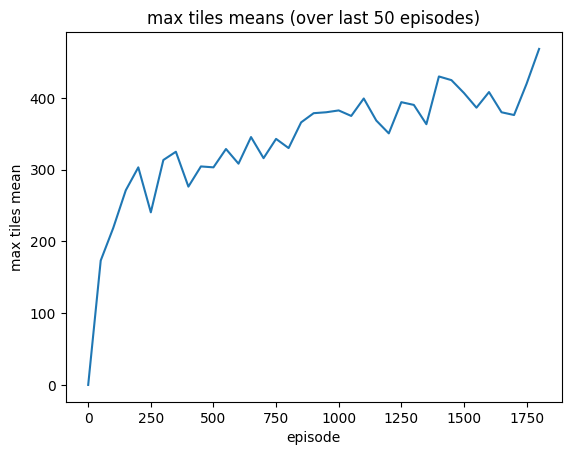

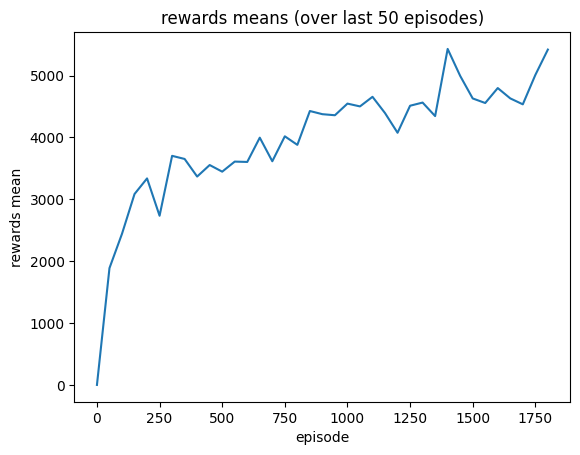

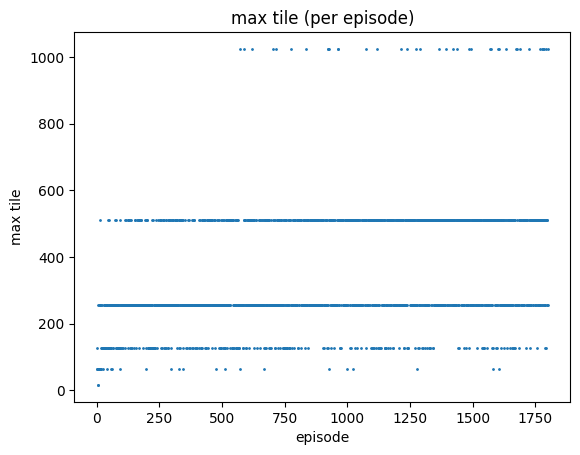

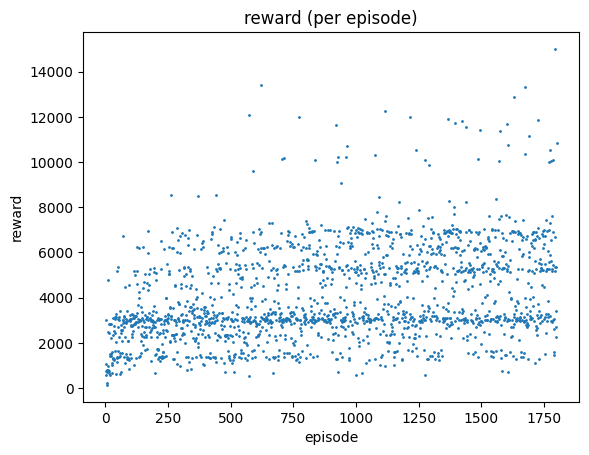

 691975/1000000 - episode: 1801, episode steps: 562, episode reward: 7168.0, max tile: 512.0
 692580/1000000 - episode: 1802, episode steps: 605, episode reward: 6844.0, max tile: 512.0
 692972/1000000 - episode: 1803, episode steps: 392, episode reward: 3264.0, max tile: 256.0
 693241/1000000 - episode: 1804, episode steps: 269, episode reward: 3060.0, max tile: 256.0
 693697/1000000 - episode: 1805, episode steps: 456, episode reward: 6896.0, max tile: 512.0
 694325/1000000 - episode: 1806, episode steps: 628, episode reward: 6852.0, max tile: 512.0
 694644/1000000 - episode: 1807, episode steps: 319, episode reward: 3204.0, max tile: 256.0
 695058/1000000 - episode: 1808, episode steps: 414, episode reward: 2560.0, max tile: 128.0
 695599/1000000 - episode: 1809, episode steps: 541, episode reward: 6780.0, max tile: 512.0
 695788/1000000 - episode: 1810, episode steps: 189, episode reward: 1772.0, max tile: 128.0
 696197/1000000 - episode: 1811, episode steps: 409, episode reward: 5

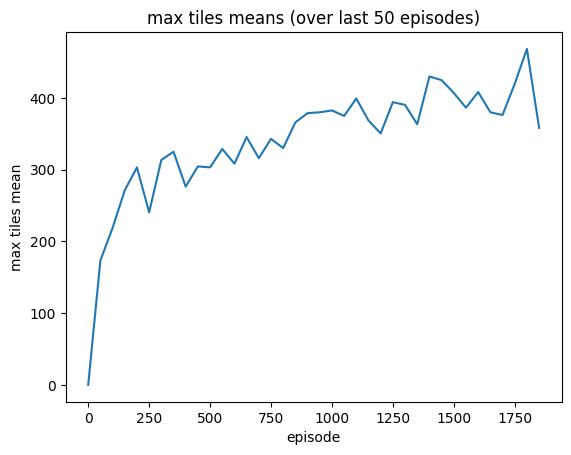

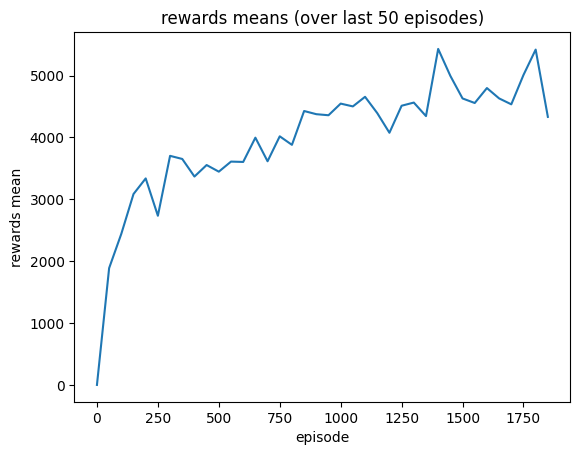

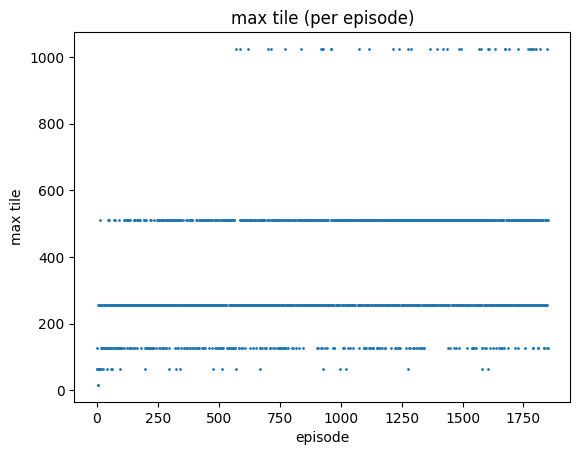

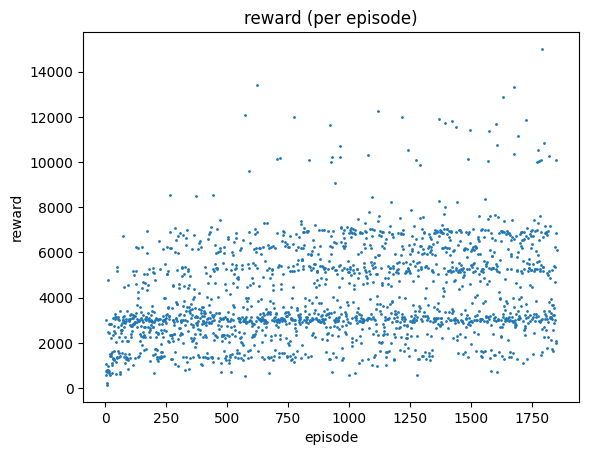

 711016/1000000 - episode: 1851, episode steps: 195, episode reward: 2240.0, max tile: 256.0
 711443/1000000 - episode: 1852, episode steps: 427, episode reward: 2976.0, max tile: 256.0
 711841/1000000 - episode: 1853, episode steps: 398, episode reward: 5212.0, max tile: 512.0
 712192/1000000 - episode: 1854, episode steps: 351, episode reward: 3360.0, max tile: 256.0
 712523/1000000 - episode: 1855, episode steps: 331, episode reward: 3444.0, max tile: 256.0
 713024/1000000 - episode: 1856, episode steps: 501, episode reward: 5232.0, max tile: 512.0
 713786/1000000 - episode: 1857, episode steps: 762, episode reward: 11944.0, max tile: 1024.0
 714103/1000000 - episode: 1858, episode steps: 317, episode reward: 3172.0, max tile: 256.0
 714426/1000000 - episode: 1859, episode steps: 323, episode reward: 3272.0, max tile: 256.0
 714977/1000000 - episode: 1860, episode steps: 551, episode reward: 6260.0, max tile: 512.0
 715281/1000000 - episode: 1861, episode steps: 304, episode reward:

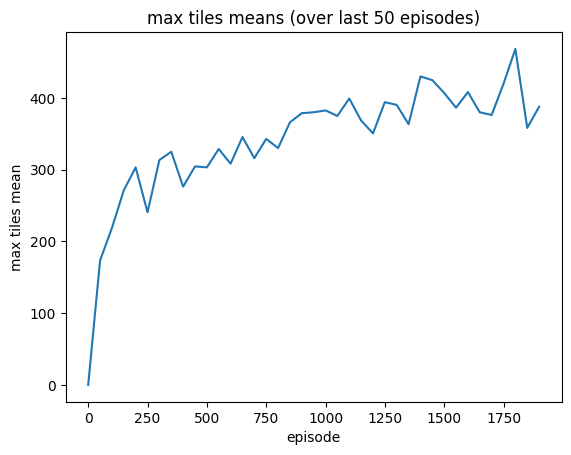

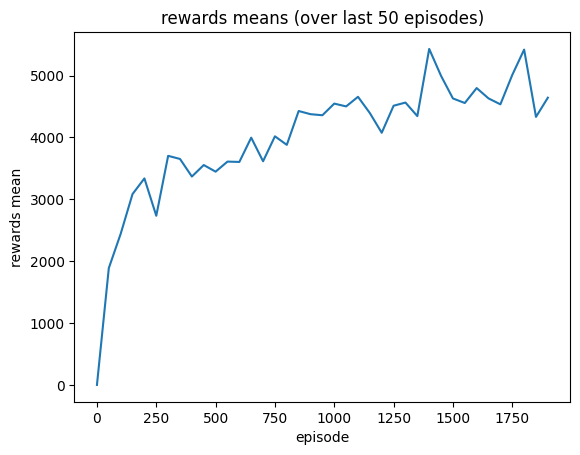

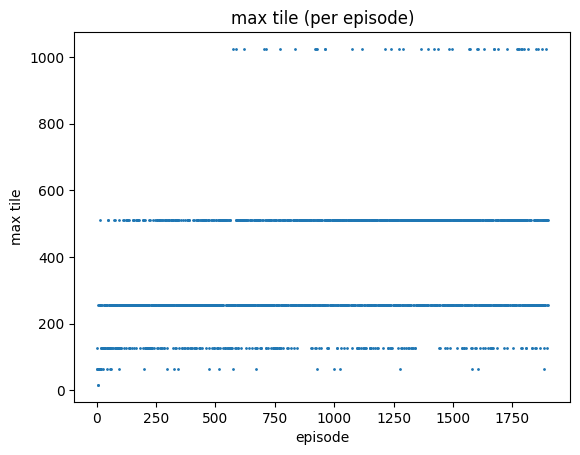

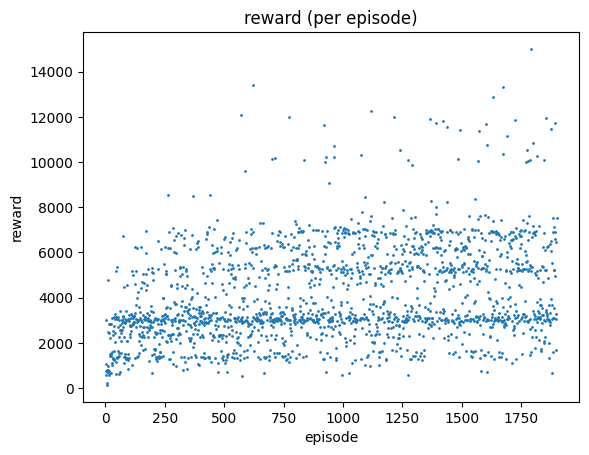

 731964/1000000 - episode: 1901, episode steps: 593, episode reward: 7100.0, max tile: 512.0
 732500/1000000 - episode: 1902, episode steps: 536, episode reward: 5652.0, max tile: 512.0
 732979/1000000 - episode: 1903, episode steps: 479, episode reward: 6948.0, max tile: 512.0
 733405/1000000 - episode: 1904, episode steps: 426, episode reward: 5308.0, max tile: 512.0
 733947/1000000 - episode: 1905, episode steps: 542, episode reward: 6932.0, max tile: 512.0
 734222/1000000 - episode: 1906, episode steps: 275, episode reward: 3116.0, max tile: 256.0
 734710/1000000 - episode: 1907, episode steps: 488, episode reward: 5876.0, max tile: 512.0
 734827/1000000 - episode: 1908, episode steps: 117, episode reward: 1144.0, max tile: 128.0
 735305/1000000 - episode: 1909, episode steps: 478, episode reward: 6164.0, max tile: 512.0
 735449/1000000 - episode: 1910, episode steps: 144, episode reward: 1472.0, max tile: 128.0
 736022/1000000 - episode: 1911, episode steps: 573, episode reward: 6

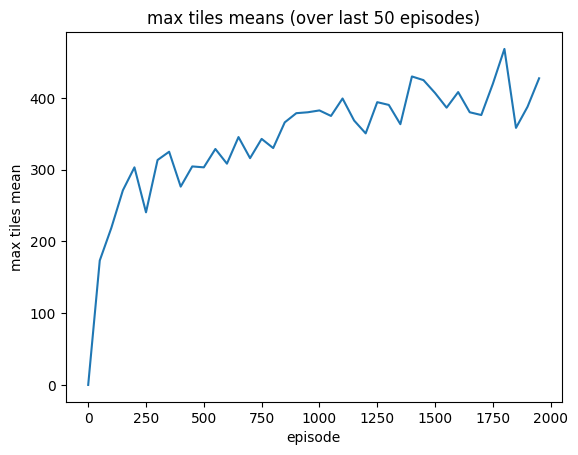

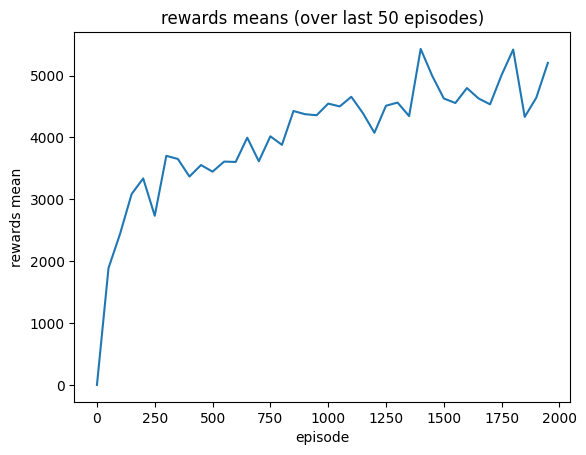

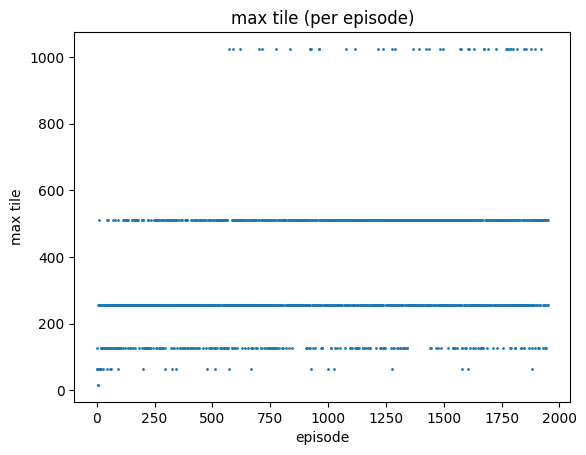

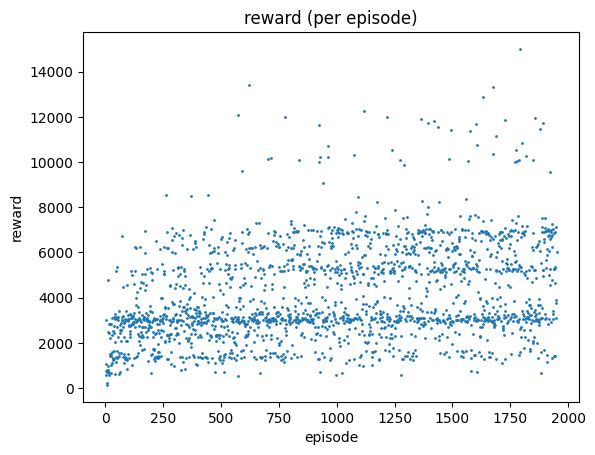

 754141/1000000 - episode: 1951, episode steps: 430, episode reward: 5328.0, max tile: 512.0
 754771/1000000 - episode: 1952, episode steps: 630, episode reward: 6108.0, max tile: 512.0
 755221/1000000 - episode: 1953, episode steps: 450, episode reward: 3272.0, max tile: 256.0
 755952/1000000 - episode: 1954, episode steps: 731, episode reward: 11884.0, max tile: 1024.0
 756201/1000000 - episode: 1955, episode steps: 249, episode reward: 3008.0, max tile: 256.0
 756572/1000000 - episode: 1956, episode steps: 371, episode reward: 5128.0, max tile: 512.0
 757037/1000000 - episode: 1957, episode steps: 465, episode reward: 5232.0, max tile: 512.0
 757236/1000000 - episode: 1958, episode steps: 199, episode reward: 2192.0, max tile: 256.0
 757731/1000000 - episode: 1959, episode steps: 495, episode reward: 6200.0, max tile: 512.0
 758021/1000000 - episode: 1960, episode steps: 290, episode reward: 3672.0, max tile: 256.0
 758429/1000000 - episode: 1961, episode steps: 408, episode reward:

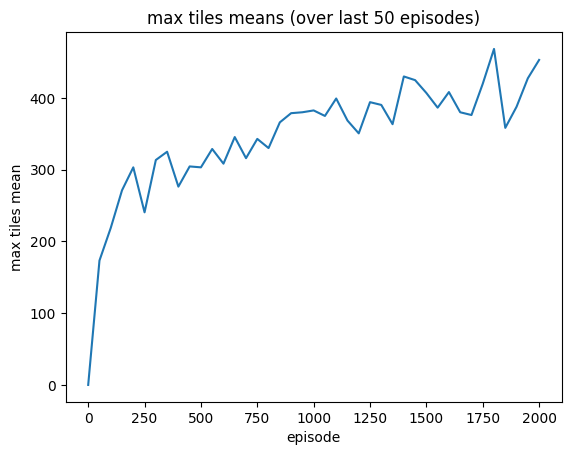

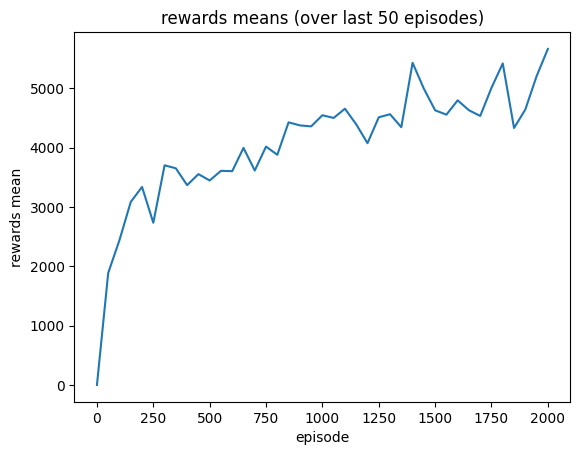

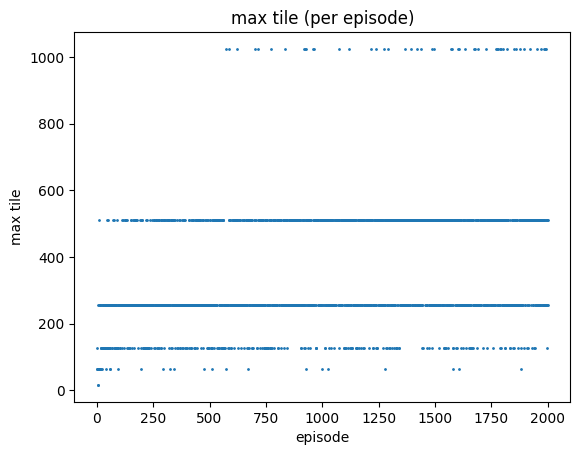

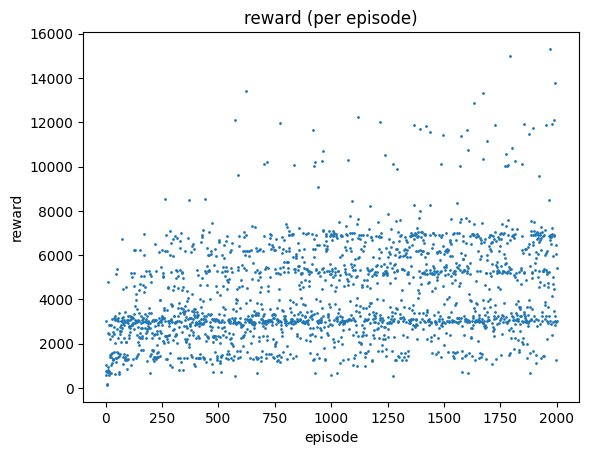

 776887/1000000 - episode: 2001, episode steps: 293, episode reward: 3140.0, max tile: 256.0
 777114/1000000 - episode: 2002, episode steps: 227, episode reward: 2924.0, max tile: 256.0
 777513/1000000 - episode: 2003, episode steps: 399, episode reward: 4964.0, max tile: 512.0
 777900/1000000 - episode: 2004, episode steps: 387, episode reward: 5440.0, max tile: 512.0
 778389/1000000 - episode: 2005, episode steps: 489, episode reward: 5204.0, max tile: 512.0
 778887/1000000 - episode: 2006, episode steps: 498, episode reward: 6724.0, max tile: 512.0
 779254/1000000 - episode: 2007, episode steps: 367, episode reward: 5156.0, max tile: 512.0
 779616/1000000 - episode: 2008, episode steps: 362, episode reward: 3832.0, max tile: 256.0
 779878/1000000 - episode: 2009, episode steps: 262, episode reward: 2916.0, max tile: 256.0
 780119/1000000 - episode: 2010, episode steps: 241, episode reward: 2980.0, max tile: 256.0
 780430/1000000 - episode: 2011, episode steps: 311, episode reward: 3

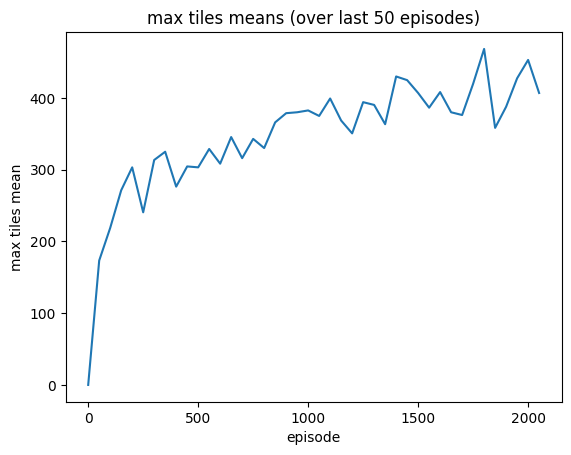

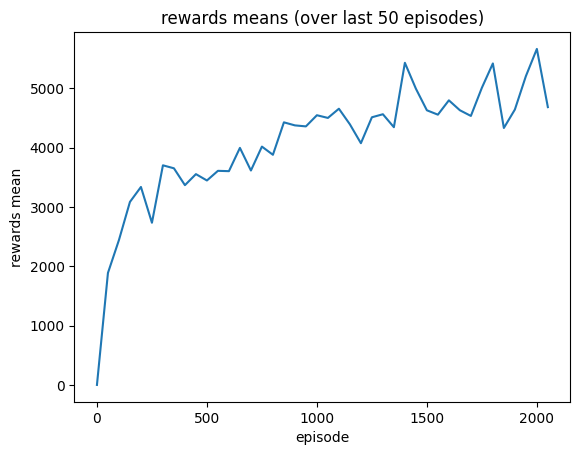

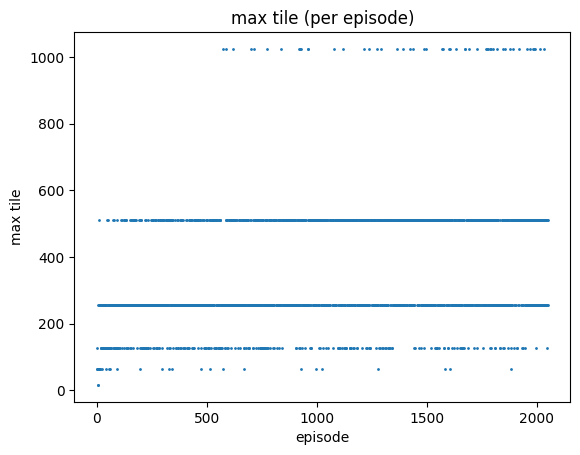

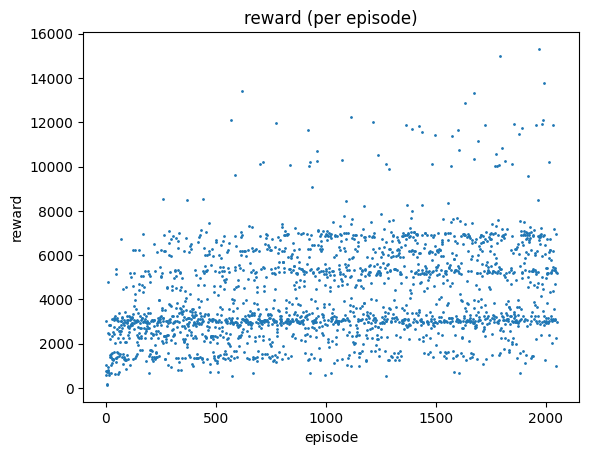

 796897/1000000 - episode: 2051, episode steps: 559, episode reward: 6924.0, max tile: 512.0
 797346/1000000 - episode: 2052, episode steps: 449, episode reward: 5708.0, max tile: 512.0
 797763/1000000 - episode: 2053, episode steps: 417, episode reward: 3436.0, max tile: 256.0
 798038/1000000 - episode: 2054, episode steps: 275, episode reward: 2940.0, max tile: 256.0
 798430/1000000 - episode: 2055, episode steps: 392, episode reward: 4272.0, max tile: 256.0
 798750/1000000 - episode: 2056, episode steps: 320, episode reward: 3380.0, max tile: 256.0
 799076/1000000 - episode: 2057, episode steps: 326, episode reward: 3376.0, max tile: 256.0
 799615/1000000 - episode: 2058, episode steps: 539, episode reward: 6328.0, max tile: 512.0
 800016/1000000 - episode: 2059, episode steps: 401, episode reward: 5312.0, max tile: 512.0
 800196/1000000 - episode: 2060, episode steps: 180, episode reward: 2200.0, max tile: 256.0
 800465/1000000 - episode: 2061, episode steps: 269, episode reward: 3

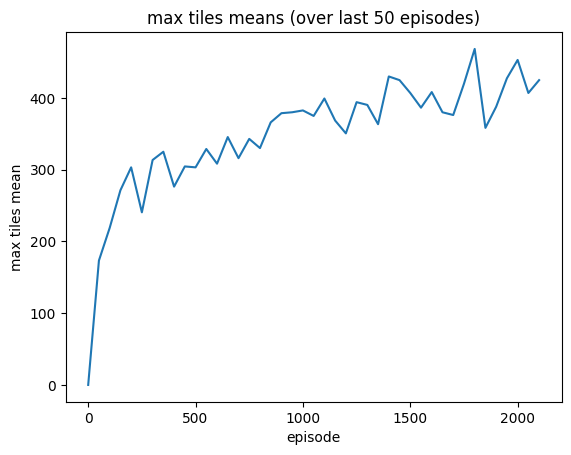

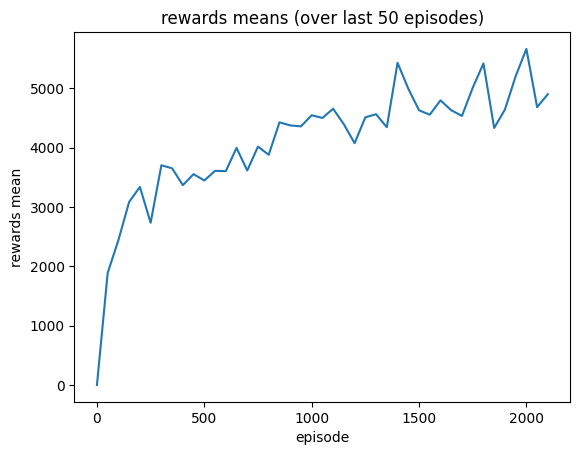

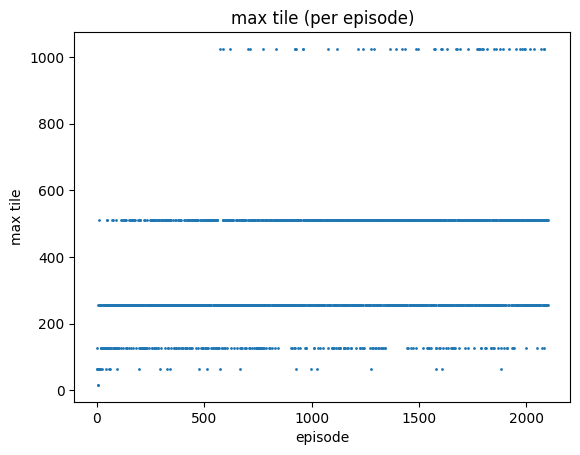

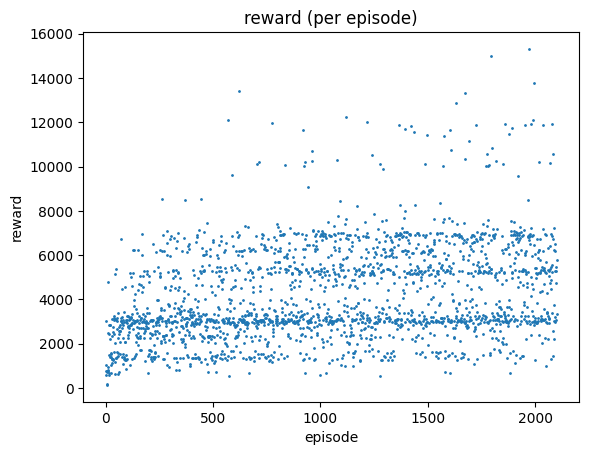

 817506/1000000 - episode: 2101, episode steps: 222, episode reward: 2372.0, max tile: 256.0
 817934/1000000 - episode: 2102, episode steps: 428, episode reward: 6556.0, max tile: 512.0
 818237/1000000 - episode: 2103, episode steps: 303, episode reward: 3224.0, max tile: 256.0
 818774/1000000 - episode: 2104, episode steps: 537, episode reward: 7368.0, max tile: 512.0
 818910/1000000 - episode: 2105, episode steps: 136, episode reward: 1388.0, max tile: 128.0
 819299/1000000 - episode: 2106, episode steps: 389, episode reward: 5360.0, max tile: 512.0
 819954/1000000 - episode: 2107, episode steps: 655, episode reward: 6868.0, max tile: 512.0
 820597/1000000 - episode: 2108, episode steps: 643, episode reward: 6552.0, max tile: 512.0
 820902/1000000 - episode: 2109, episode steps: 305, episode reward: 3088.0, max tile: 256.0
 821519/1000000 - episode: 2110, episode steps: 617, episode reward: 6452.0, max tile: 512.0
 821928/1000000 - episode: 2111, episode steps: 409, episode reward: 5

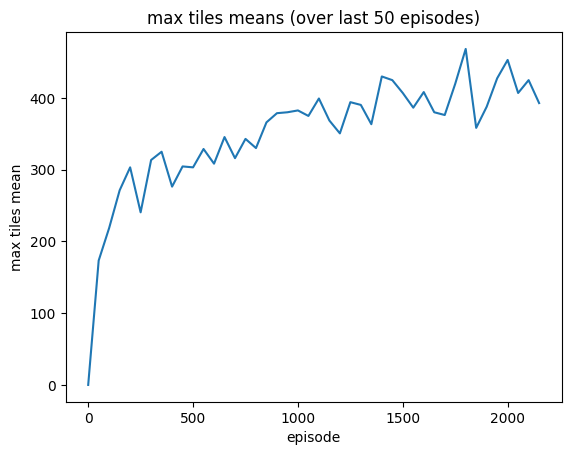

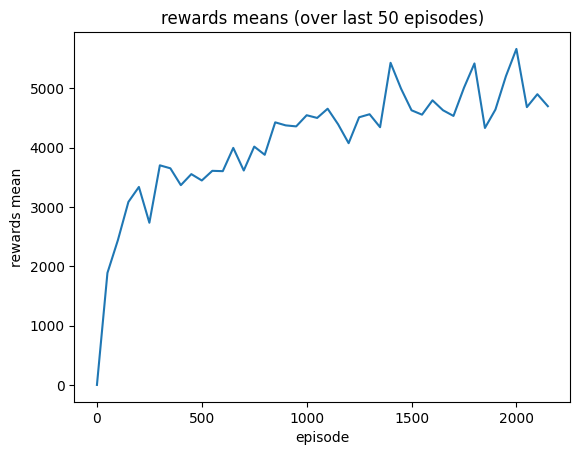

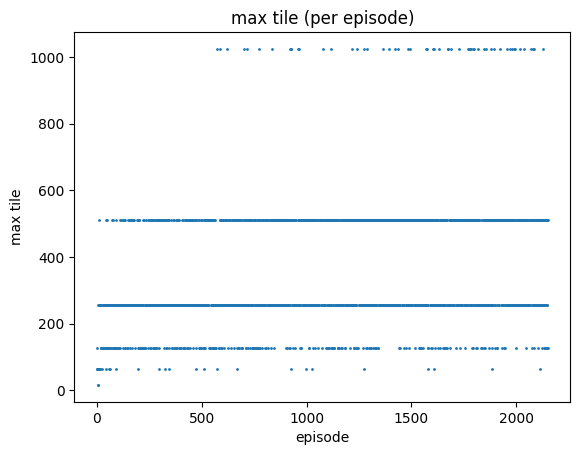

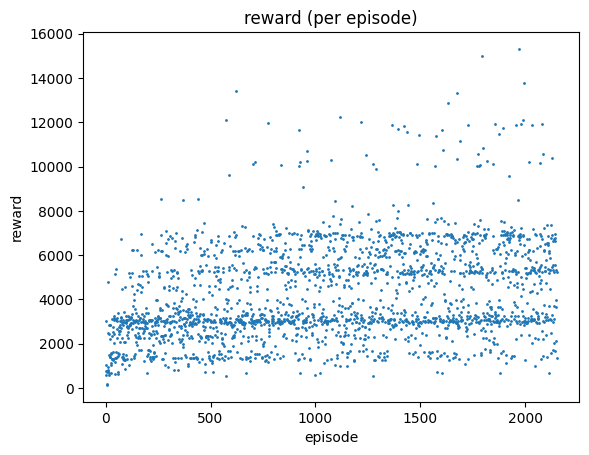

 838431/1000000 - episode: 2151, episode steps: 510, episode reward: 6184.0, max tile: 512.0
 838671/1000000 - episode: 2152, episode steps: 240, episode reward: 1544.0, max tile: 128.0
 839441/1000000 - episode: 2153, episode steps: 770, episode reward: 10968.0, max tile: 1024.0
 839669/1000000 - episode: 2154, episode steps: 228, episode reward: 2900.0, max tile: 256.0
 839869/1000000 - episode: 2155, episode steps: 200, episode reward: 2312.0, max tile: 256.0
 840408/1000000 - episode: 2156, episode steps: 539, episode reward: 6948.0, max tile: 512.0
 840655/1000000 - episode: 2157, episode steps: 247, episode reward: 2960.0, max tile: 256.0
 841167/1000000 - episode: 2158, episode steps: 512, episode reward: 6748.0, max tile: 512.0
 841509/1000000 - episode: 2159, episode steps: 342, episode reward: 4528.0, max tile: 512.0
 842421/1000000 - episode: 2160, episode steps: 912, episode reward: 11892.0, max tile: 1024.0
 842709/1000000 - episode: 2161, episode steps: 288, episode rewar

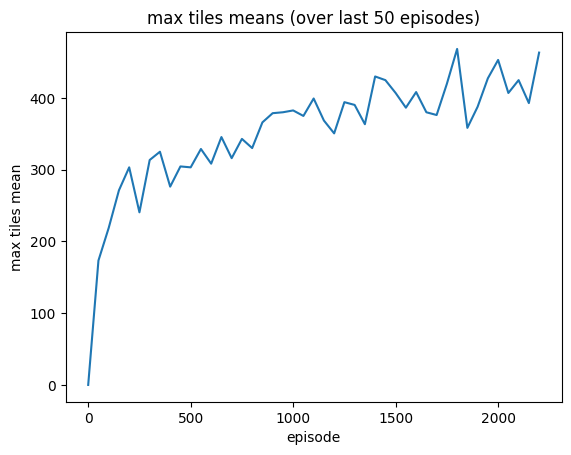

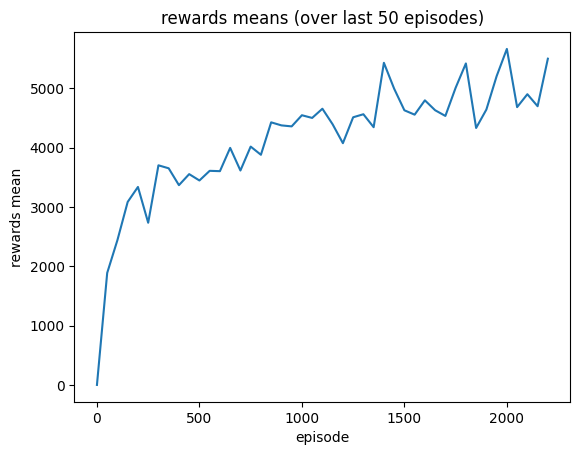

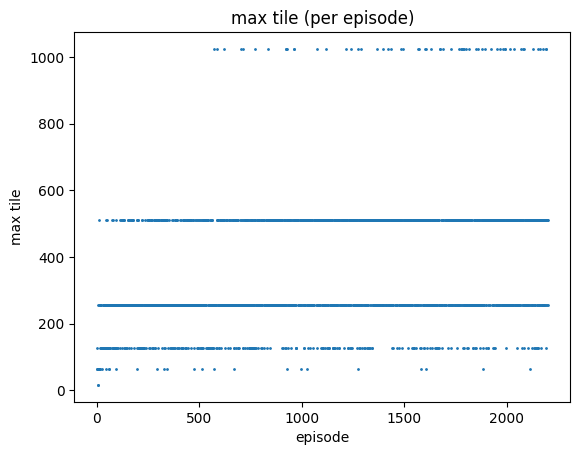

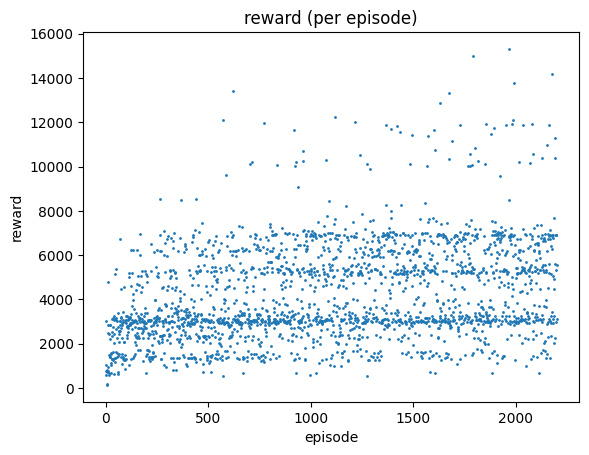

 861541/1000000 - episode: 2201, episode steps: 585, episode reward: 5940.0, max tile: 512.0
 862112/1000000 - episode: 2202, episode steps: 571, episode reward: 7092.0, max tile: 512.0
 862387/1000000 - episode: 2203, episode steps: 275, episode reward: 3008.0, max tile: 256.0
 862754/1000000 - episode: 2204, episode steps: 367, episode reward: 5340.0, max tile: 512.0
 863163/1000000 - episode: 2205, episode steps: 409, episode reward: 6568.0, max tile: 512.0
 863593/1000000 - episode: 2206, episode steps: 430, episode reward: 5856.0, max tile: 512.0
 864072/1000000 - episode: 2207, episode steps: 479, episode reward: 6340.0, max tile: 512.0
 864727/1000000 - episode: 2208, episode steps: 655, episode reward: 11052.0, max tile: 1024.0
 865118/1000000 - episode: 2209, episode steps: 391, episode reward: 3804.0, max tile: 256.0
 865467/1000000 - episode: 2210, episode steps: 349, episode reward: 3492.0, max tile: 256.0
 866457/1000000 - episode: 2211, episode steps: 990, episode reward:

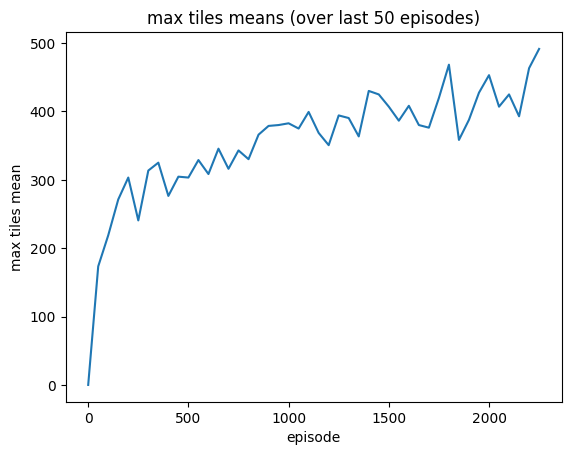

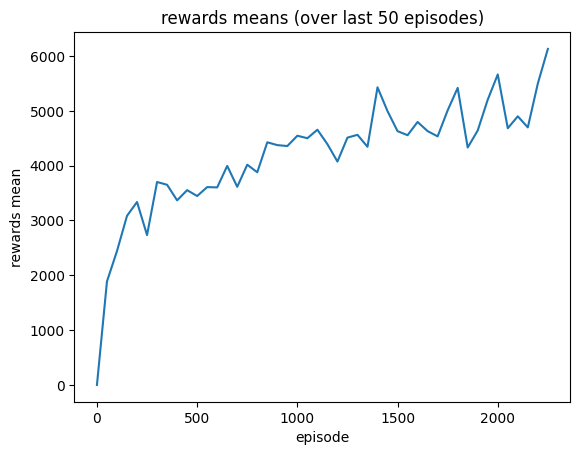

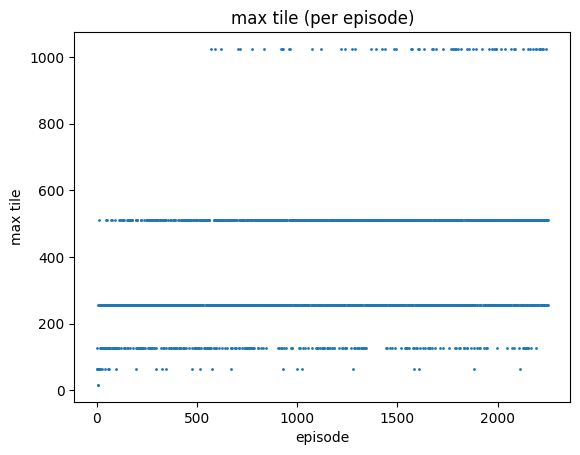

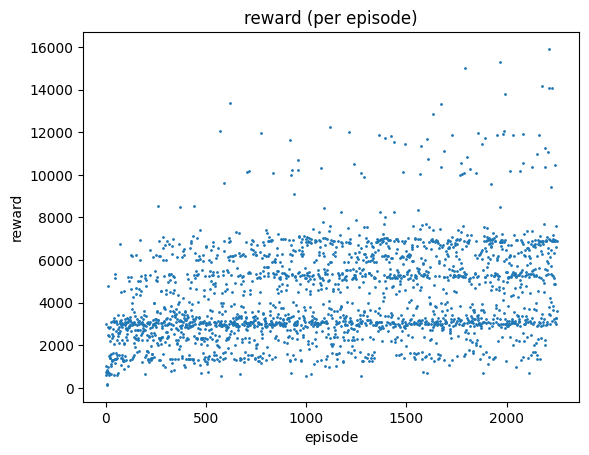

 885697/1000000 - episode: 2251, episode steps: 361, episode reward: 3668.0, max tile: 256.0
 886177/1000000 - episode: 2252, episode steps: 480, episode reward: 6900.0, max tile: 512.0
 886622/1000000 - episode: 2253, episode steps: 445, episode reward: 5772.0, max tile: 512.0
 886865/1000000 - episode: 2254, episode steps: 243, episode reward: 3056.0, max tile: 256.0
 887229/1000000 - episode: 2255, episode steps: 364, episode reward: 4980.0, max tile: 512.0
 887526/1000000 - episode: 2256, episode steps: 297, episode reward: 3268.0, max tile: 256.0
 887823/1000000 - episode: 2257, episode steps: 297, episode reward: 3912.0, max tile: 256.0
 888440/1000000 - episode: 2258, episode steps: 617, episode reward: 10392.0, max tile: 1024.0
 888744/1000000 - episode: 2259, episode steps: 304, episode reward: 2984.0, max tile: 256.0
 889032/1000000 - episode: 2260, episode steps: 288, episode reward: 3680.0, max tile: 256.0
 889755/1000000 - episode: 2261, episode steps: 723, episode reward:

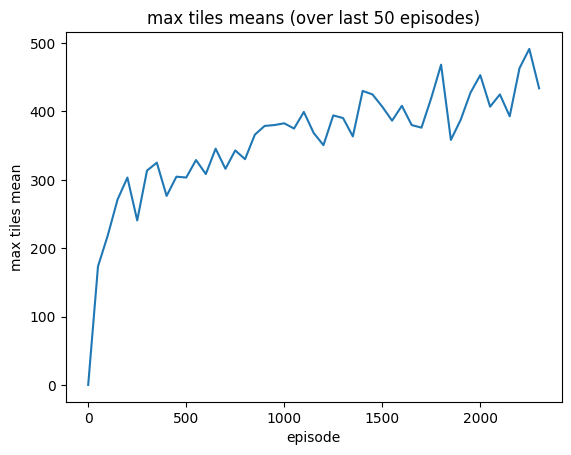

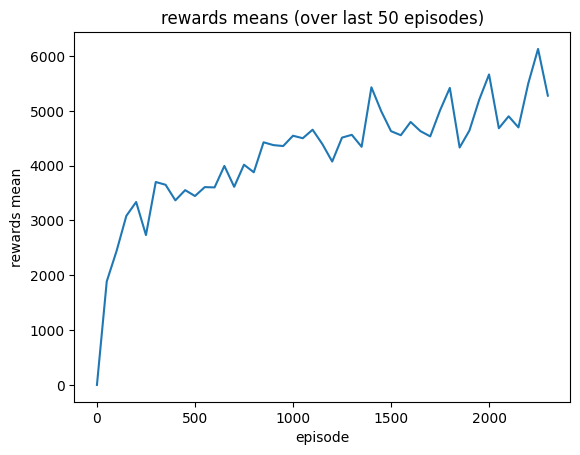

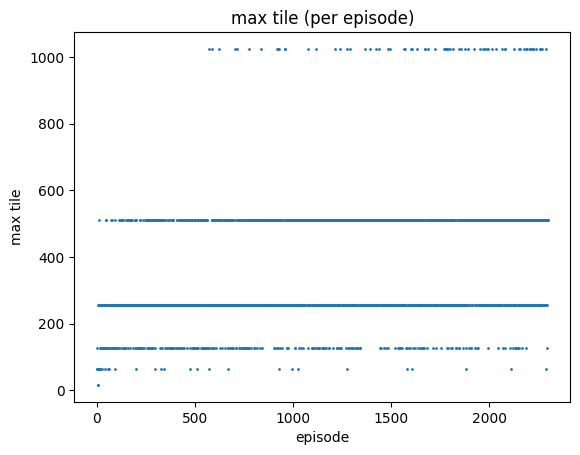

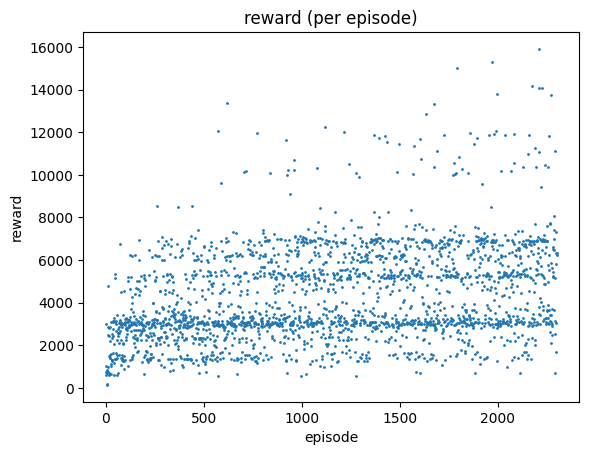

 907219/1000000 - episode: 2301, episode steps: 701, episode reward: 5324.0, max tile: 512.0
 907710/1000000 - episode: 2302, episode steps: 491, episode reward: 6892.0, max tile: 512.0
 908250/1000000 - episode: 2303, episode steps: 540, episode reward: 6308.0, max tile: 512.0
 908629/1000000 - episode: 2304, episode steps: 379, episode reward: 3024.0, max tile: 256.0
 908898/1000000 - episode: 2305, episode steps: 269, episode reward: 3244.0, max tile: 256.0
 909090/1000000 - episode: 2306, episode steps: 192, episode reward: 2052.0, max tile: 256.0
 909437/1000000 - episode: 2307, episode steps: 347, episode reward: 5068.0, max tile: 512.0
 909841/1000000 - episode: 2308, episode steps: 404, episode reward: 5428.0, max tile: 512.0
 910114/1000000 - episode: 2309, episode steps: 273, episode reward: 2936.0, max tile: 256.0
 910512/1000000 - episode: 2310, episode steps: 398, episode reward: 6148.0, max tile: 512.0
 910975/1000000 - episode: 2311, episode steps: 463, episode reward: 7

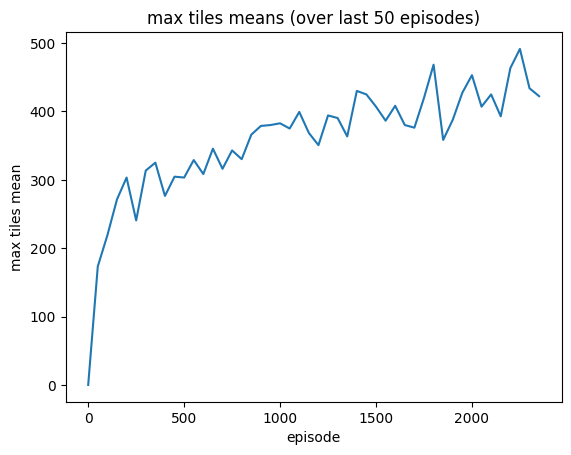

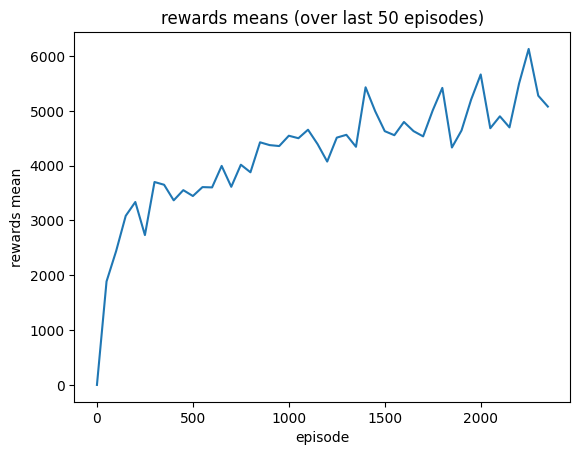

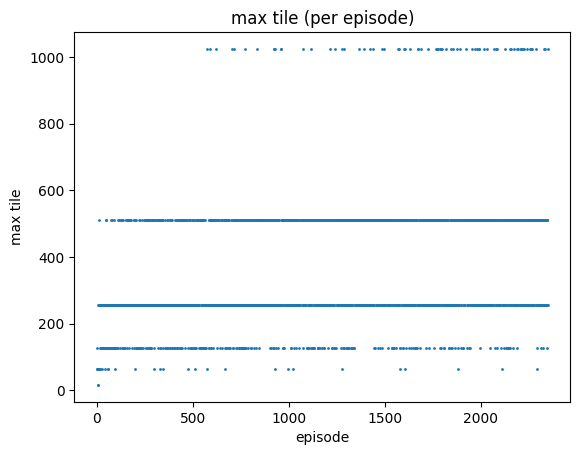

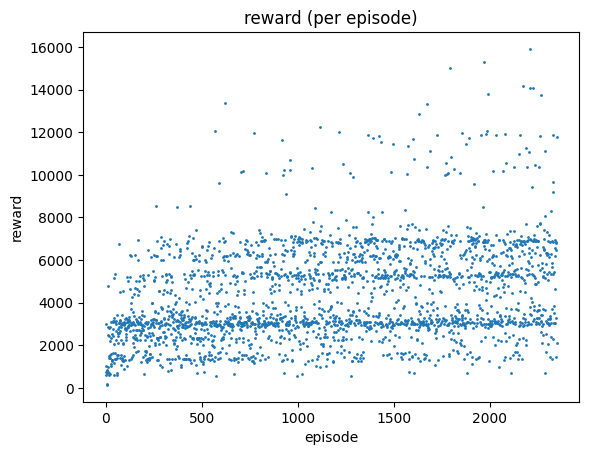

 927878/1000000 - episode: 2351, episode steps: 268, episode reward: 3068.0, max tile: 256.0
 928431/1000000 - episode: 2352, episode steps: 553, episode reward: 7028.0, max tile: 512.0
 928653/1000000 - episode: 2353, episode steps: 222, episode reward: 2756.0, max tile: 256.0
 929304/1000000 - episode: 2354, episode steps: 651, episode reward: 9584.0, max tile: 1024.0
 929582/1000000 - episode: 2355, episode steps: 278, episode reward: 3248.0, max tile: 256.0
 929932/1000000 - episode: 2356, episode steps: 350, episode reward: 3108.0, max tile: 256.0
 930155/1000000 - episode: 2357, episode steps: 223, episode reward: 2868.0, max tile: 256.0
 930480/1000000 - episode: 2358, episode steps: 325, episode reward: 3016.0, max tile: 256.0
 930799/1000000 - episode: 2359, episode steps: 319, episode reward: 3916.0, max tile: 256.0
 930951/1000000 - episode: 2360, episode steps: 152, episode reward: 1412.0, max tile: 128.0
 931582/1000000 - episode: 2361, episode steps: 631, episode reward: 

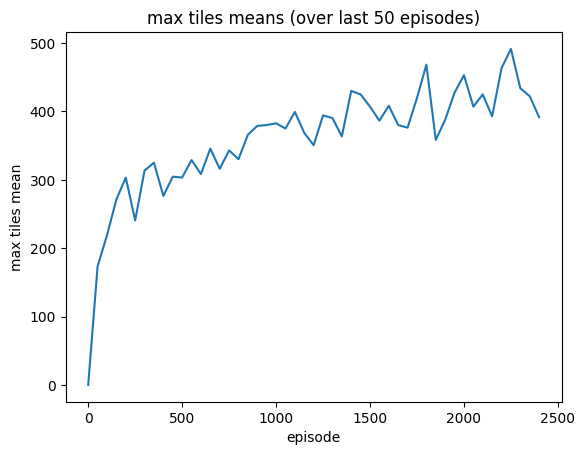

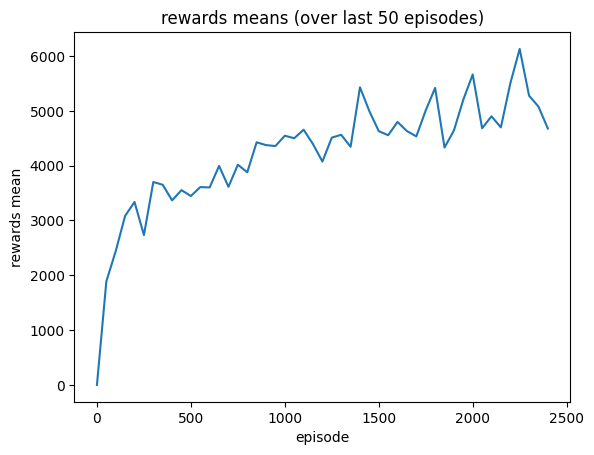

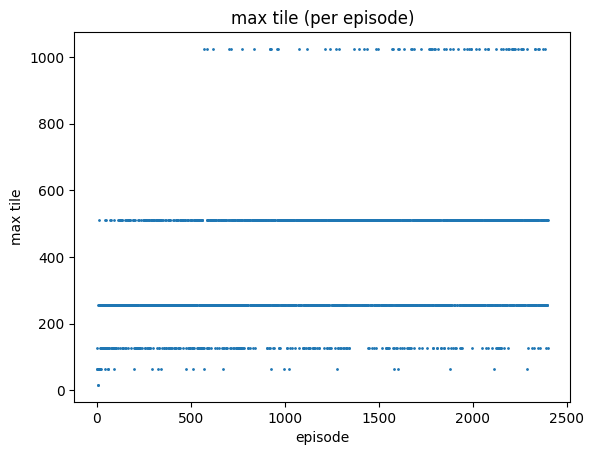

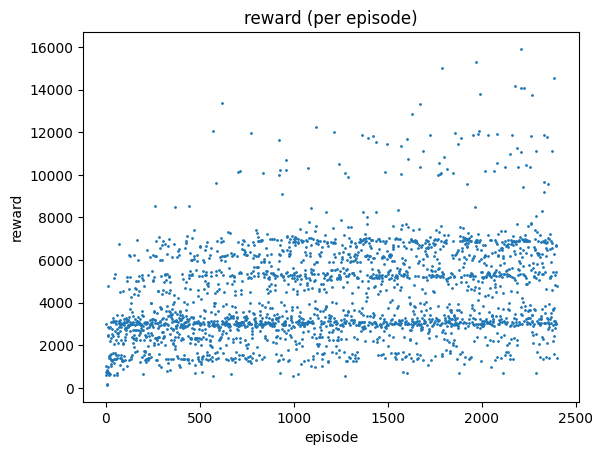

 949578/1000000 - episode: 2401, episode steps: 1109, episode reward: 12024.0, max tile: 1024.0
 950355/1000000 - episode: 2402, episode steps: 777, episode reward: 6172.0, max tile: 512.0
 950749/1000000 - episode: 2403, episode steps: 394, episode reward: 5248.0, max tile: 512.0
 951286/1000000 - episode: 2404, episode steps: 537, episode reward: 6836.0, max tile: 512.0
 951740/1000000 - episode: 2405, episode steps: 454, episode reward: 3672.0, max tile: 256.0
 952281/1000000 - episode: 2406, episode steps: 541, episode reward: 5864.0, max tile: 512.0
 952529/1000000 - episode: 2407, episode steps: 248, episode reward: 1700.0, max tile: 128.0
 952882/1000000 - episode: 2408, episode steps: 353, episode reward: 2872.0, max tile: 256.0
 953067/1000000 - episode: 2409, episode steps: 185, episode reward: 2324.0, max tile: 256.0
 953297/1000000 - episode: 2410, episode steps: 230, episode reward: 2264.0, max tile: 256.0
 953915/1000000 - episode: 2411, episode steps: 618, episode reward

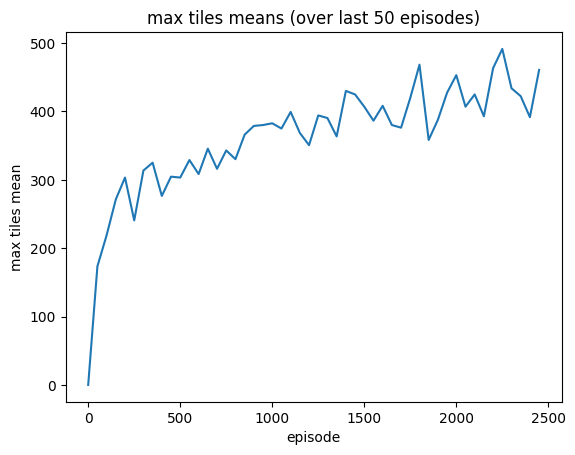

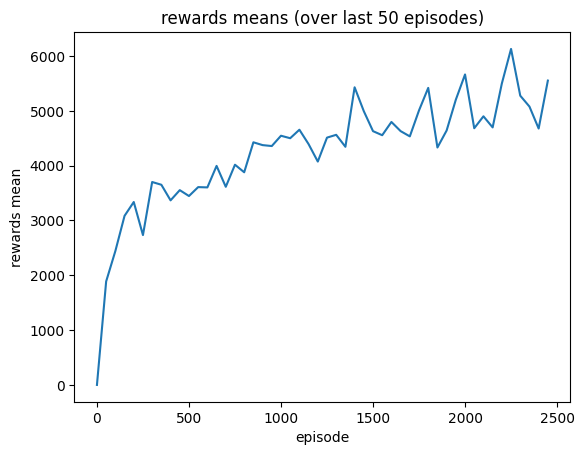

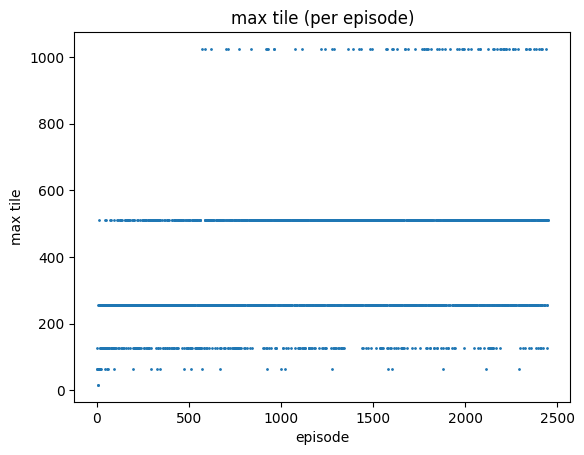

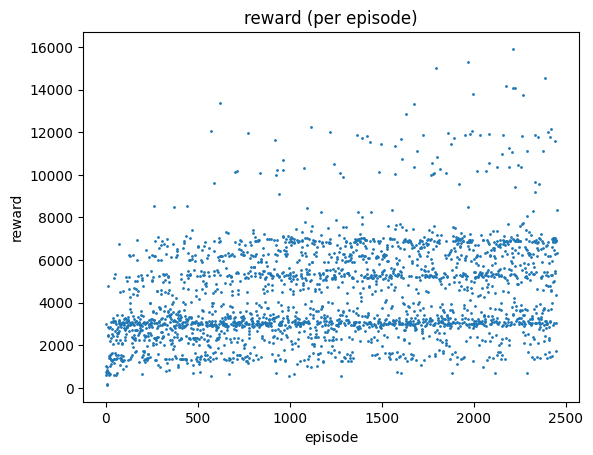

 973299/1000000 - episode: 2451, episode steps: 289, episode reward: 3160.0, max tile: 256.0
 973471/1000000 - episode: 2452, episode steps: 172, episode reward: 1388.0, max tile: 128.0
 973835/1000000 - episode: 2453, episode steps: 364, episode reward: 5196.0, max tile: 512.0
 974050/1000000 - episode: 2454, episode steps: 215, episode reward: 2724.0, max tile: 256.0
 974360/1000000 - episode: 2455, episode steps: 310, episode reward: 3380.0, max tile: 256.0
 974718/1000000 - episode: 2456, episode steps: 358, episode reward: 5536.0, max tile: 512.0
 975566/1000000 - episode: 2457, episode steps: 848, episode reward: 10440.0, max tile: 1024.0
 975850/1000000 - episode: 2458, episode steps: 284, episode reward: 2964.0, max tile: 256.0
 976380/1000000 - episode: 2459, episode steps: 530, episode reward: 7148.0, max tile: 512.0
 976892/1000000 - episode: 2460, episode steps: 512, episode reward: 6208.0, max tile: 512.0
 977284/1000000 - episode: 2461, episode steps: 392, episode reward:

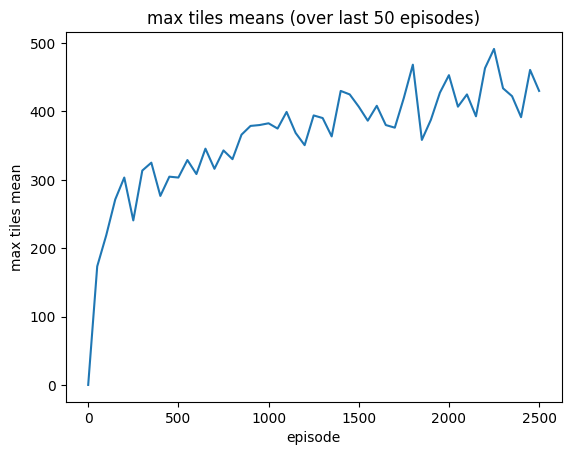

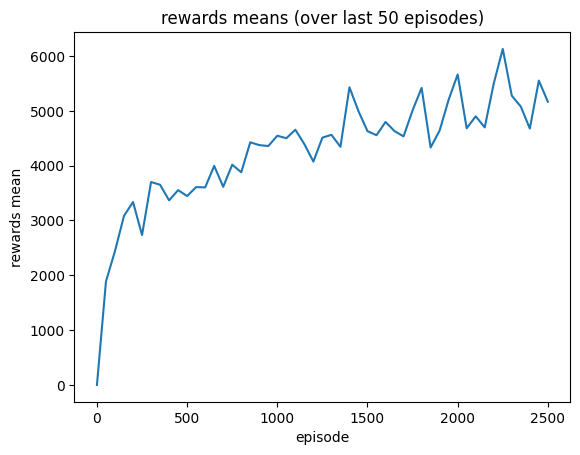

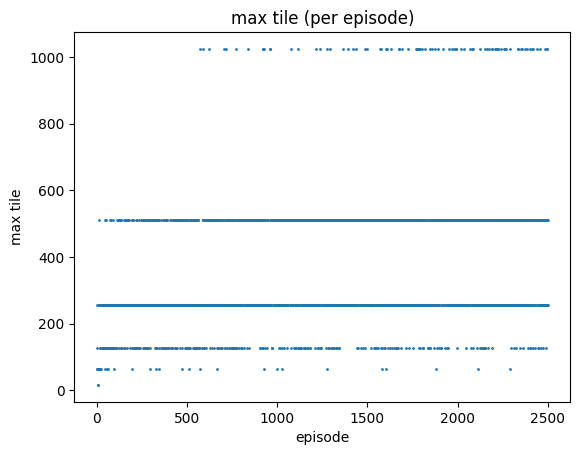

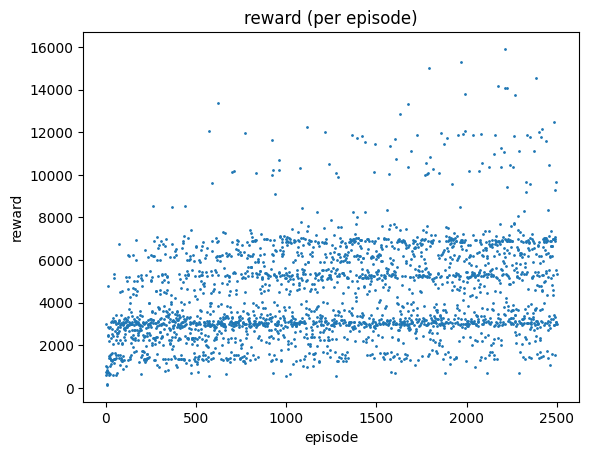

 994312/1000000 - episode: 2501, episode steps: 480, episode reward: 6516.0, max tile: 512.0
 995038/1000000 - episode: 2502, episode steps: 726, episode reward: 11760.0, max tile: 1024.0
 995556/1000000 - episode: 2503, episode steps: 518, episode reward: 5520.0, max tile: 512.0
 996216/1000000 - episode: 2504, episode steps: 660, episode reward: 9800.0, max tile: 1024.0
 996659/1000000 - episode: 2505, episode steps: 443, episode reward: 6120.0, max tile: 512.0
 996925/1000000 - episode: 2506, episode steps: 266, episode reward: 3084.0, max tile: 256.0
 997366/1000000 - episode: 2507, episode steps: 441, episode reward: 6152.0, max tile: 512.0
 997570/1000000 - episode: 2508, episode steps: 204, episode reward: 2676.0, max tile: 256.0
 998116/1000000 - episode: 2509, episode steps: 546, episode reward: 7016.0, max tile: 512.0
 998354/1000000 - episode: 2510, episode steps: 238, episode reward: 2940.0, max tile: 256.0
 998972/1000000 - episode: 2511, episode steps: 618, episode reward

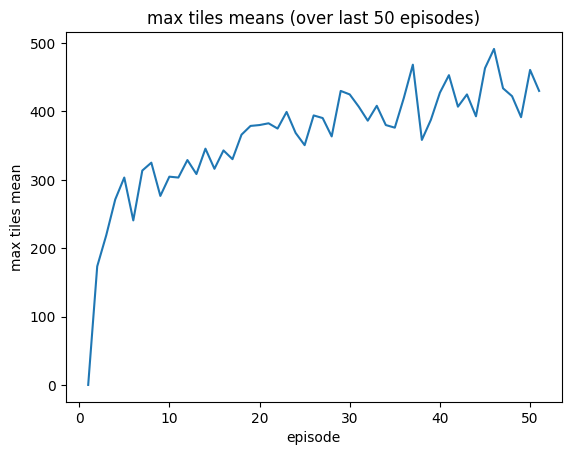

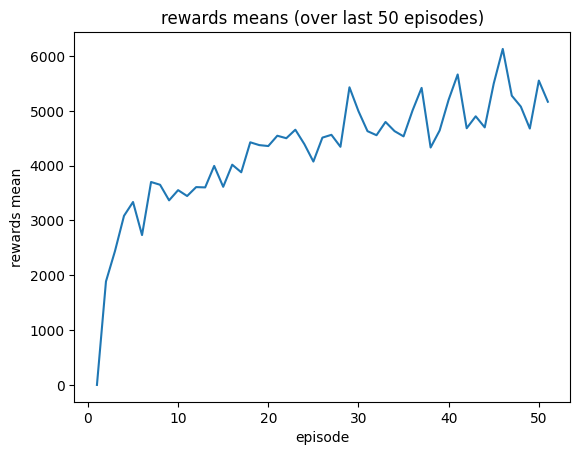

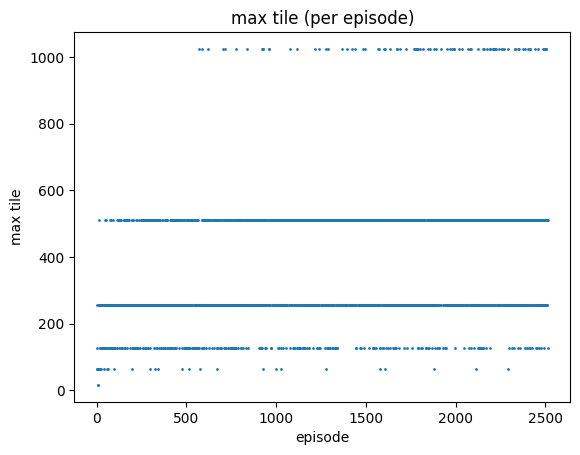

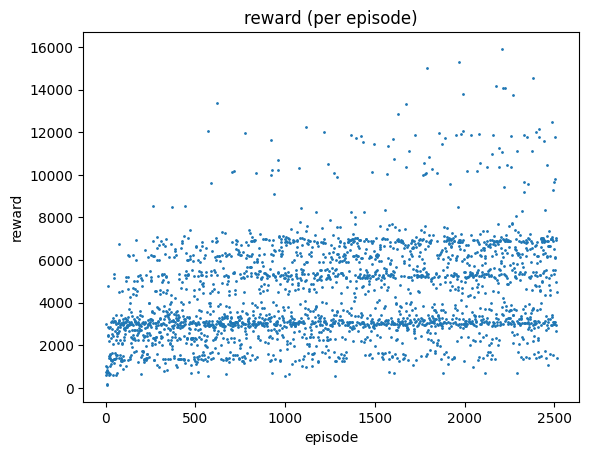

In [10]:
memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)

TRAIN_POLICY = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=0.05, value_min=0.05, value_test=0.01, nb_steps=NB_STEPS_ANNEALED)
TEST_POLICY = EpsGreedyQPolicy(eps=.01)
    
dqn = DQNAgent(model=model, nb_actions=NUM_ACTIONS_OUTPUT_NN, test_policy=TEST_POLICY, policy=TRAIN_POLICY, memory=memory, processor=processor,
    nb_steps_warmup=NB_STEPS_WARMUP, gamma=GAMMA, target_model_update=TARGET_MODEL_UPDATE, train_interval=4, delta_clip=1.)
dqn.compile(Adam(learning_rate=LEARNING_RATE), metrics=['mse'])

train_2048 = Train2048() # 인스턴스 생성
_callbacks = [train_2048] # 훈련 에피소드 로거 콜백

dqn.fit(env, callbacks=_callbacks, nb_steps=NB_STEPS_TRAINING, visualize=False, verbose=0) # 모델 훈련

train_2048.close_csv()

# 훈련 모델 테스트

In [11]:
env.reset() # 환경 재설정
dqn.test(env, nb_episodes=5, visualize=False, verbose=0, callbacks=[Test2048()]) # 모델 테스트

Testing for 5 episodes ...
episode: 1, max tile: 1024, episode reward: 10156.0, episode steps: 867
Final Grid: 
[[   2   16    4    2]
 [   8   32   64    4]
 [  16    8  128   16]
 [   2 1024    8    2]]

episode: 2, max tile: 128, episode reward: 1732.0, episode steps: 539
Final Grid: 
[[  2  32   4   2]
 [  4   8   2   8]
 [  8 128  32 128]
 [  2   8   2   4]]

episode: 3, max tile: 512, episode reward: 7076.0, episode steps: 922
Final Grid: 
[[  4   8  32   8]
 [  8  32 512  64]
 [  4 128   8   4]
 [256  32   4   2]]

episode: 4, max tile: 256, episode reward: 3368.0, episode steps: 584
Final Grid: 
[[  2   8 128   2]
 [  4   2 256   4]
 [  8  32  16   8]
 [  4   8   4 128]]

episode: 5, max tile: 128, episode reward: 1424.0, episode steps: 1455
Final Grid: 
[[  2  16   4   2]
 [  4  32   8  16]
 [ 16  64 128   4]
 [  8   4  32   2]]

